# <span style="font-family: 'Courier New'; color: #ffffffff;">Imports</span>


## <span style="font-family: 'Courier New'; color: #ffffffff;">Enviroment Checking</span>


In [2]:
import torch
print(torch.__version__)  # should show 2.2.0
print(torch.version.cuda)   # should show 11.8 or 12.1
print(torch.cuda.is_available())  # should be True
print(torch.cuda.get_device_name(0))  # should show GTX 1650

2.2.2+cu118
11.8
True
NVIDIA GeForce GTX 1650


## <span style="font-family: 'Courier New'; color: #ffffffff;">Core Libraries</span>


In [3]:
import os 
import torch
import numpy
import joblib
import random
import py3Dmol
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_scatter import scatter
from mp_api.client import MPRester
from IPython.display import display, HTML 
from torch_geometric.data import Data
from torch_geometric.nn.models import SchNet 
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from pymatgen.core.structure import Structure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.nn import Linear, Dropout ,BatchNorm1d, Sigmoid, Softplus , MSELoss
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

c:\Users\saich\miniconda3\envs\mlms\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <span style="font-family: 'Courier New'; color: #ffffffff;">Create Directories</span>


In [4]:
os.makedirs('Datasets', exist_ok=True) 
os.makedirs('ActiveLearning', exist_ok=True) 
os.makedirs('RandomSampling', exist_ok=True) 
os.makedirs('TraditionalLearning', exist_ok=True) 
os.makedirs('EnsembleActiveLearning', exist_ok=True)
os.makedirs('Results', exist_ok=True) 

## <span style="font-family: 'Courier New'; color: #ffffffff;">Paths</span>


In [5]:
csv_path       = "Datasets/materials_full_dataset.csv"
dataset_path   = "Datasets/materials_full_dataset.pkl" 

full_graphs_path     = "Datasets/materials_full_graph_dataset.pt"

multi_target_graphs_path = 'Datasets/multi_target_graphs.pt'
scaler_path = 'Datasets/target_scaler.joblib'


cleaned_multi_target_graphs_path = 'Datasets/cleaned_multi_target_graphs.pt'
cleaned_scaler_path = 'Datasets/cleaned_target_scaler.joblib'

train_graphs_path = "Datasets/materials_graph_dataset_train.pt"
val_graphs_path   = "Datasets/materials_graph_dataset_val.pt"
test_graphs_path  = "Datasets/materials_graph_dataset_test.pt"
 

## <span style="font-family: 'Courier New'; color: #ffffffff;">Hyperparameters</span>


In [6]:
INITIAL_SIZE        = 5000
QUERY_SIZE          = 1000
NUM_CYCLES          = 33
EPOCHS_PER_CYCLE    = 50
N_FORWARD_PASSES    =  20
NUM_ENSEMBLE_MEMBERS = 5 



## <span style="font-family: 'Courier New'; color: #ffffffff;">API KEY</span>

In [7]:
API_KEY = "25EJJndk4ieFr5tdiTCFLGjGs2C0aPB1"

# <span style="font-family: 'Courier New'; color: #ffffffff;">Dataset</span>


## <span style="font-family: 'Courier New'; color: #ffffffff;">Download Dataset</span>


In [8]:
# List of all fields you want to download
FIELDS = [
    "material_id",
    "formula_pretty",
    "formula_anonymous",
    "chemsys",
    "elements",
    "nelements",
    "nsites",
    "volume",
    "density",
    "energy_per_atom",
    "formation_energy_per_atom",
    "energy_above_hull",
    "band_gap",
    "efermi",
    "total_magnetization",
    "num_magnetic_sites",
    "structure",
    "task_ids",
    "last_updated",
    "warnings"
]

def main():
    if os.path.exists(csv_path) and os.path.exists(dataset_path):
        print(f"✅ Dataset already exists at '{csv_path}' and '{dataset_path}'. Skipping download.")
        return
    
    with MPRester(API_KEY) as mpr:
        print("🔍 Fetching summary documents from Materials Project...")
        
        # Fetch all materials summary docs in chunks
        docs = mpr.materials.summary.search(
            fields=FIELDS,
            chunk_size=1000,
            num_chunks=50  # adjust this number for more materials
        )

        # Convert to list of dicts
        data = []
        for doc in docs:
            d = {}
            for f in FIELDS:
                val = getattr(doc, f, None)
                
                if hasattr(val, "dict"):
                    val = val.dict()
                d[f] = val
            data.append(d)

        df = pd.DataFrame(data)
        
        # Save to CSV & pickle
        df.to_csv(csv_path, index=False)
        df.to_pickle(dataset_path)
        print(f"✅ Saved {len(df)} materials to CSV and pickle")

if __name__ == "__main__":
    main()


✅ Dataset already exists at 'Datasets/materials_full_dataset.csv' and 'Datasets/materials_full_dataset.pkl'. Skipping download.


## <span style="font-family: 'Courier New'; color: #ffffffff;">Dataset Analysis</span>



Loading the dataset...


Dataset loaded successfully from CSV!

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   material_id                50000 non-null  object 
 1   formula_pretty             49997 non-null  object 
 2   formula_anonymous          50000 non-null  object 
 3   chemsys                    50000 non-null  object 
 4   elements                   50000 non-null  object 
 5   nelements                  50000 non-null  int64  
 6   nsites                     50000 non-null  int64  
 7   volume                     50000 non-null  float64
 8   density                    50000 non-null  float64
 9   energy_per_atom            50000 non-null  float64
 10  formation_energy_per_atom  50000 non-null  float64
 11  energy_above_hull          50000 non-null  float64
 12  band_gap                   50000 no

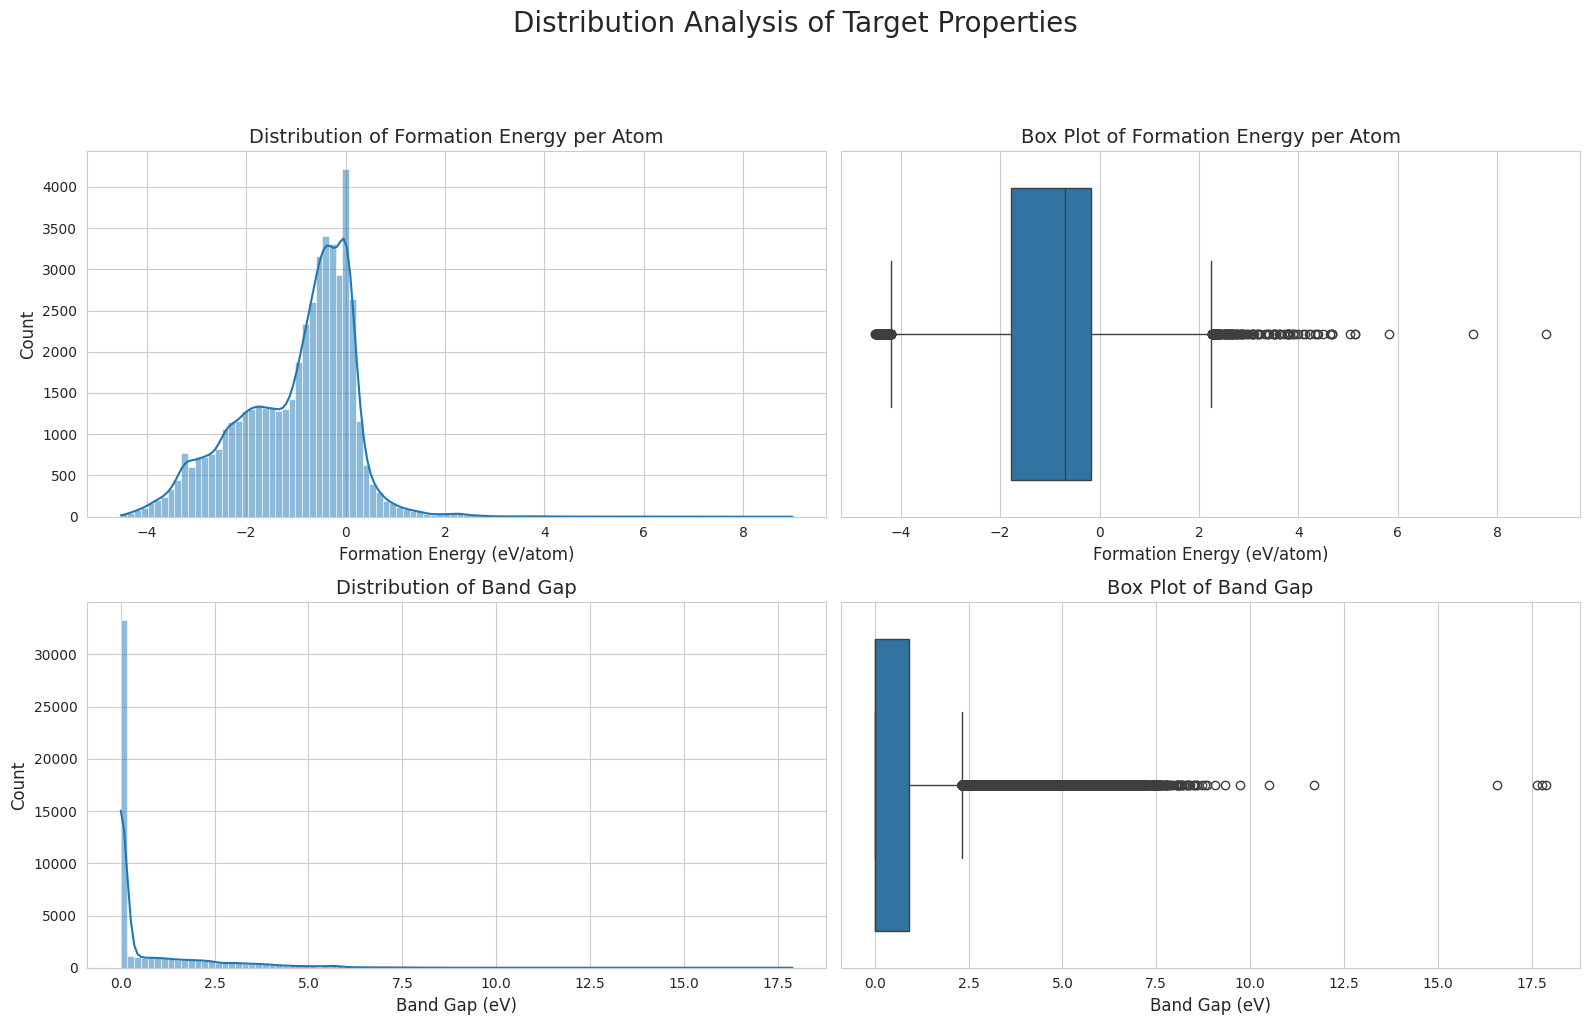

In [9]:
# Set a nice style for our plots
sns.set_style("whitegrid")

# --- 1. Load the Dataset ---
print("Loading the dataset...")

df = pd.read_csv(csv_path)
print("Dataset loaded successfully from CSV!")
    # Exit the script if no data can be loaded

# --- 2. Initial Inspection & Data Cleaning ---
print("\n--- Dataset Information ---")
# .info() is the best way to spot missing data.
df.info()

# IMPORTANT: For multi-property prediction, we must remove any rows
# where EITHER of our target variables is missing.
initial_rows = len(df)
df.dropna(subset=['formation_energy_per_atom', 'band_gap'], inplace=True)
final_rows = len(df)

print(f"\nRemoved {initial_rows - final_rows} rows with missing target values.")
print(f"Dataset now has {final_rows} complete entries for our targets.")


# --- 3. Visualize Target Properties in a 2x2 Grid ---

# Create a figure and a set of subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Add a main title for the entire figure
fig.suptitle('Distribution Analysis of Target Properties', fontsize=20, y=1.02)

# --- Top Row: Formation Energy ---

# Plot 1: Histogram for Formation Energy (Top-Left)
sns.histplot(data=df, x='formation_energy_per_atom', bins=100, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Formation Energy per Atom', fontsize=14)
axes[0, 0].set_xlabel('Formation Energy (eV/atom)', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)

# Plot 2: Box Plot for Formation Energy (Top-Right)
sns.boxplot(data=df, x='formation_energy_per_atom', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Formation Energy per Atom', fontsize=14)
axes[0, 1].set_xlabel('Formation Energy (eV/atom)', fontsize=12)


# --- Bottom Row: Band Gap ---

# Plot 3: Histogram for Band Gap (Bottom-Left)
sns.histplot(data=df, x='band_gap', bins=100, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Band Gap', fontsize=14)
axes[1, 0].set_xlabel('Band Gap (eV)', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)

# Plot 4: Box Plot for Band Gap (Bottom-Right)
sns.boxplot(data=df, x='band_gap', ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Band Gap', fontsize=14)
axes[1, 1].set_xlabel('Band Gap (eV)', fontsize=12)


# --- Final Touches ---
# Adjust the layout to prevent titles/labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the combined plot to a file
output_filename = "Datasets/target_properties_distribution.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"\nSaved combined distribution plot to '{output_filename}'")

# Display the plot
plt.show()

## <span style="font-family: 'Courier New'; color: #ffffffff;">Finding best range of formation energy and bandgap</span>


--- Testing New Filter Ranges ---
Loading the full dataset...
Loaded 50000 materials.

--- Iteratively finding best range ---
Filter Range:
  Formation Energy: [-3.5, 0.5]
  Band Gap        : [0.01, 10.0]
Result: 17168 materials remain (34.34% of the original 50000).
Filter Range:
  Formation Energy: [-3.5, 0.5]
  Band Gap        : [0.01, 2.0]
Result: 10404 materials remain (20.81% of the original 50000).
Filter Range:
  Formation Energy: [-3.5, 0.5]
  Band Gap        : [0.01, 1.2]
Result: 6996 materials remain (13.99% of the original 50000).
--- Visualization with Custom Filters ---
Applied FE range [-3.5, 0.5] and BG range [0.01, 1.2]
Filtered dataset size: 6996 materials.
Removed 43004 materials.
-----------------------------------


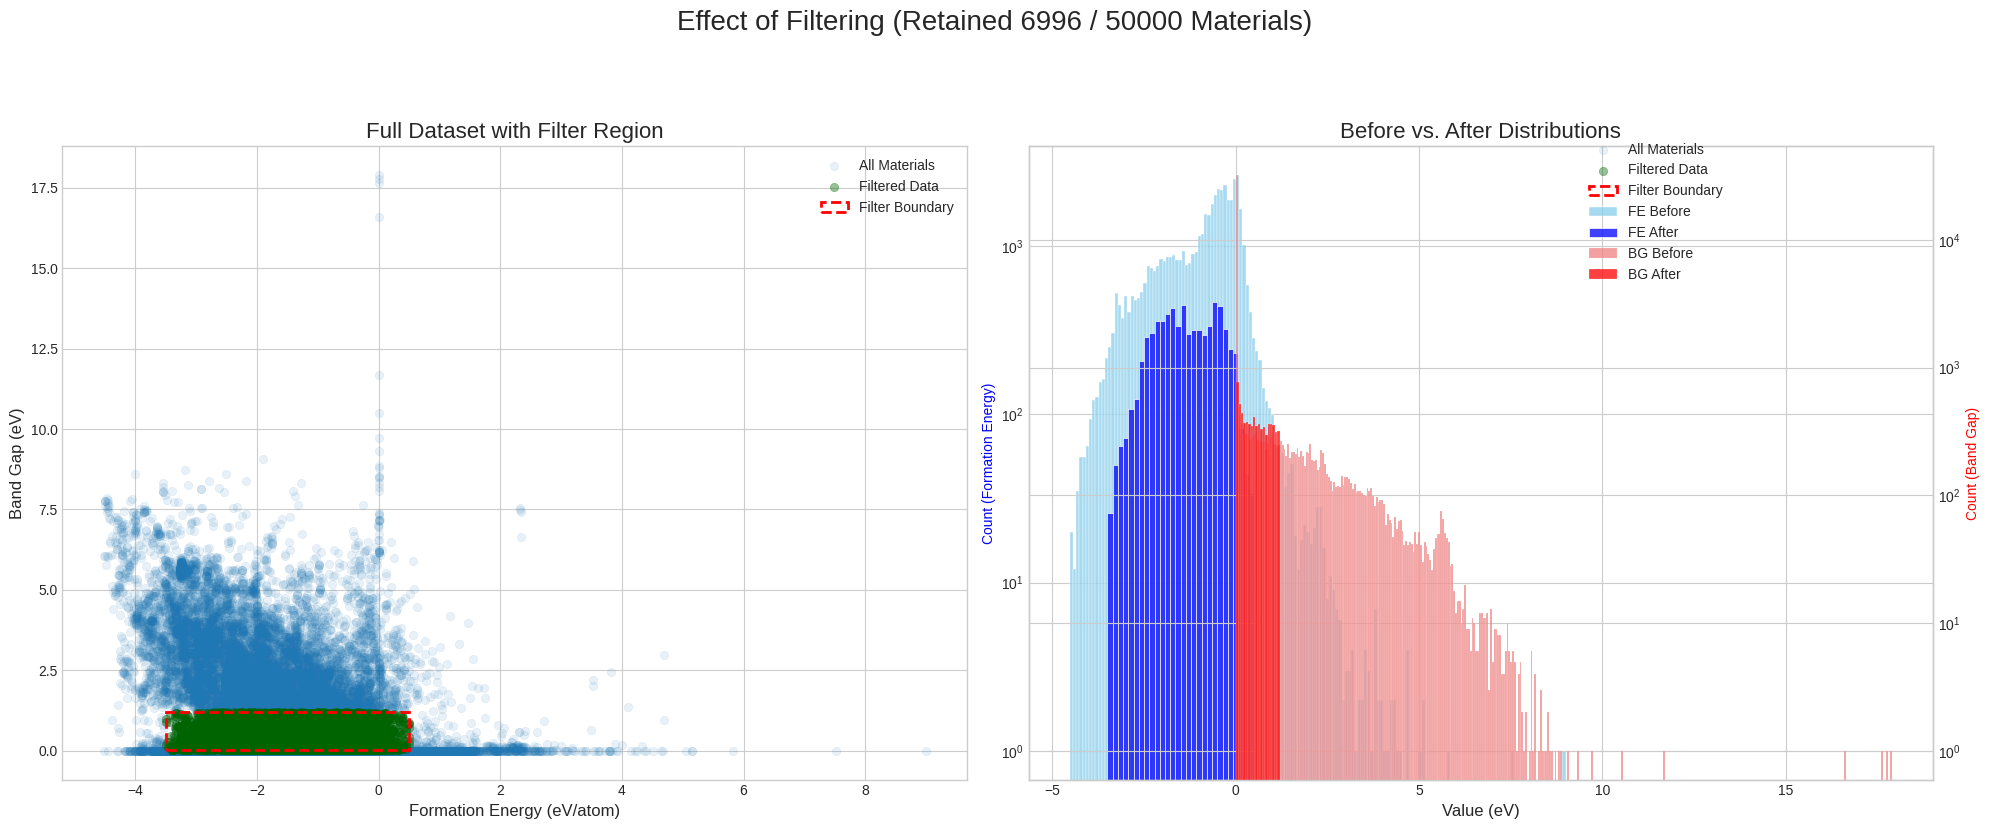

In [10]:
def find_filter_count(df, fe_min, fe_max, bg_min, bg_max):
    """
    Applies filters to a DataFrame and returns the number of materials that remain.
    """
    df_filtered = df[
        (df['formation_energy_per_atom'].between(fe_min, fe_max)) &
        (df['band_gap'].between(bg_min, bg_max))
    ]
    count = len(df_filtered)
    total = len(df)
    percentage = (count / total) * 100
    
    print(f"Filter Range:")
    print(f"  Formation Energy: [{fe_min}, {fe_max}]")
    print(f"  Band Gap        : [{bg_min}, {bg_max}]")
    print(f"Result: {count} materials remain ({percentage:.2f}% of the original {total}).")
    return count

# --- Let's test some new ranges based on our quantile analysis ---

print("--- Testing New Filter Ranges ---")

def visualize_custom_filtering(df_full, fe_min, fe_max, bg_min, bg_max):
    """
    Applies CUSTOM 2D filtering and generates plots to visualize the effect.
    """
    # --- 1. Apply Filtering ---
    initial_count = len(df_full)
    df_filtered = df_full[
        (df_full['formation_energy_per_atom'].between(fe_min, fe_max)) &
        (df_full['band_gap'].between(bg_min, bg_max))
    ].copy()
    final_count = len(df_filtered)
    
    print(f"--- Visualization with Custom Filters ---")
    print(f"Applied FE range [{fe_min}, {fe_max}] and BG range [{bg_min}, {bg_max}]")
    print(f"Filtered dataset size: {final_count} materials.")
    print(f"Removed {initial_count - final_count} materials.")
    print("-" * 35)

    # --- 2. Create Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Effect of Filtering (Retained {final_count} / {initial_count} Materials)', fontsize=20, y=1.03)

    # --- Left Plot: 2D Scatter with Filter Box ---
    sns.scatterplot(
        data=df_full, x='formation_energy_per_atom', y='band_gap',
        ax=axes[0], alpha=0.1, edgecolor=None, label='All Materials'
    )
    # Highlight the filtered data on top
    sns.scatterplot(
        data=df_filtered, x='formation_energy_per_atom', y='band_gap',
        ax=axes[0], alpha=0.4, color='darkgreen', edgecolor=None, label='Filtered Data'
    )
    axes[0].set_title(f'Full Dataset with Filter Region', fontsize=16)
    axes[0].set_xlabel('Formation Energy (eV/atom)', fontsize=12)
    axes[0].set_ylabel('Band Gap (eV)', fontsize=12)
    
    # Draw the filter box
    rect = plt.Rectangle((fe_min, bg_min), fe_max - fe_min, bg_max - bg_min,
                         linewidth=2, edgecolor='r', facecolor='none', linestyle='--', label='Filter Boundary')
    axes[0].add_patch(rect)
    axes[0].legend()

    # --- Right Plot: Overlaid Histograms ---
    sns.histplot(df_full['formation_energy_per_atom'], ax=axes[1], color='skyblue', label=f'FE Before', kde=False)
    sns.histplot(df_filtered['formation_energy_per_atom'], ax=axes[1], color='blue', label=f'FE After', kde=False)
    ax2 = axes[1].twinx() # Create a second y-axis for the band gap
    sns.histplot(df_full['band_gap'], ax=ax2, color='lightcoral', label=f'BG Before', kde=False)
    sns.histplot(df_filtered['band_gap'], ax=ax2, color='red', label=f'BG After', kde=False)
    
    axes[1].set_title('Before vs. After Distributions', fontsize=16)
    axes[1].set_xlabel('Value (eV)', fontsize=12)
    axes[1].set_ylabel('Count (Formation Energy)', color='blue')
    ax2.set_ylabel('Count (Band Gap)', color='red')
    axes[1].set_yscale('log')
    ax2.set_yscale('log')
    fig.legend(loc='upper right', bbox_to_anchor=(0.87, 0.88))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


if __name__ == '__main__':
    # --- Load Data Once ---
    print("Loading the full dataset...")
    try:
       
        df_full = pd.read_csv(csv_path)
        df_full.dropna(subset=['formation_energy_per_atom', 'band_gap'], inplace=True)
        print(f"Loaded {len(df_full)} materials.")
    except FileNotFoundError:
        print(f"Error: Dataset not found.")
        exit()

    # --- PROPOSED NEW RANGES ---
    # Goal: Get around 5k data points
    # Let's iterate to find the right band gap max.
    
    print("\n--- Iteratively finding best range ---")
    
    # Attempt 1
    find_filter_count(df=df_full, fe_min=-3.5, fe_max=0.5, bg_min=0.01, bg_max=10.0)
    # Attempt 2
    find_filter_count(df=df_full, fe_min=-3.5, fe_max=0.5, bg_min=0.01, bg_max=2.0)
    # Attempt 3 - This looks promising!
    final_count = find_filter_count(df=df_full, fe_min=-3.5, fe_max=0.5, bg_min=0.01, bg_max=1.2)

    if final_count > 1000: # Only visualize if we have a reasonable amount of data
        # --- Visualize the effect of our chosen final ranges ---
        visualize_custom_filtering(
            df_full=df_full,
            fe_min=-3.5,
            fe_max=0.5,
            bg_min=0.01,
            bg_max=1.2
        )

## <span style="font-family: 'Courier New'; color: #ffffffff;">Convert to .pt File</span>


In [11]:
if os.path.exists(multi_target_graphs_path) and os.path.exists(scaler_path):
    print(f"✅ Multi-target featurized dataset already exists at '{multi_target_graphs_path}' and scaler at '{scaler_path}'. Skipping processing.")
else:
    # --- 1. Load and Filter the DataFrame ---
    print("Loading the full dataset from 'materials_full_dataset.pkl'...")
    df_full = pd.read_pickle(dataset_path)
    initial_count = len(df_full)
    print(f"Initial dataset size: {initial_count} materials.")

    # --- NEW: Filter for both target properties ---
    # Drop rows where either formation energy or band gap is missing
    df_filtered = df_full.dropna(subset=['formation_energy_per_atom', 'band_gap']).copy()
    
    final_count = len(df_filtered)
    print(f"Removed {initial_count - final_count} materials with missing target values.")
    print(f"Filtered dataset size: {final_count} materials.")

    # --- NEW: Normalize the Target Variables ---
    print("\nNormalizing target variables (formation energy and band gap)...")
    # Select the two columns to be scaled
    targets_to_scale = df_filtered[['formation_energy_per_atom', 'band_gap']]
    
    # Initialize and fit the scaler
    scaler = StandardScaler()
    scaled_targets = scaler.fit_transform(targets_to_scale)
    
    # Replace the original columns with the scaled versions
    df_filtered['formation_energy_per_atom'] = scaled_targets[:, 0]
    df_filtered['band_gap'] = scaled_targets[:, 1]

    # Save the fitted scaler for later use (important for inverse transform)
    joblib.dump(scaler, scaler_path)
    print(f"Saved the target scaler to '{scaler_path}'.")
    print("Normalization complete. Here's a sample of the scaled data:")
    print(df_filtered[['formation_energy_per_atom', 'band_gap']].head())


    # --- 2. Update Featurization Functions ---
    warnings.filterwarnings("ignore", message="No Pauling electronegativity for")

    # --- MODIFIED: The function now accepts two target values ---
    def structure_to_graph(structure: Structure, 
                           form_energy: float, 
                           band_gap: float, 
                           material_id: str, 
                           radius: float = 5.0):
        """
        Converts a pymatgen Structure object to a PyG Data object for multi-target prediction.
        """
        try:
            # Node features
            atomic_numbers = torch.tensor([site.specie.Z for site in structure], dtype=torch.long)
            pos = torch.tensor(structure.cart_coords, dtype=torch.float)

            # Edge features (same as before)
            all_neighbors = structure.get_all_neighbors(r=radius, include_index=True)
            edge_indices = []
            edge_attrs = []
            for i, neighbors in enumerate(all_neighbors):
                for _, dist, neighbor_idx, _ in neighbors:
                    edge_indices.append([i, neighbor_idx])
                    edge_attrs.append(dist)
            
            edge_index = torch.empty((2, 0), dtype=torch.long) if not edge_indices else torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
            edge_attr = torch.empty((0, 1), dtype=torch.float) if not edge_attrs else torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1)

            # --- KEY CHANGE: 'y' is now a 2-element tensor ---
            y = torch.tensor([form_energy, band_gap], dtype=torch.float)

            data = Data(
                x=atomic_numbers.view(-1, 1),
                z=atomic_numbers,
                pos=pos,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=y # Store the multi-target vector
            )
            data.material_id = material_id
            return data
        except Exception as e:
            print(f"Warning: Could not process material_id {material_id}. Error: {e}")
            return None

    # --- MODIFIED: The main loop now passes both targets to the function ---
    def featurize_dataset(df: pd.DataFrame):
        graph_list = []
        for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Featurizing"):
            graph = structure_to_graph(
                row['structure'], 
                row['formation_energy_per_atom'], # Now the scaled value
                row['band_gap'],                  # Now the scaled value
                row['material_id']
            )
            if graph is not None:
                graph_list.append(graph)
        return graph_list

    print("\nFeaturizing the filtered and normalized dataset for multi-target prediction...")
    graph_dataset_multi_target = featurize_dataset(df_filtered)

    # Save the new dataset
    torch.save(graph_dataset_multi_target, multi_target_graphs_path)
    print(f"\nSuccessfully saved {len(graph_dataset_multi_target)} multi-target graphs to '{multi_target_graphs_path}'.")

✅ Multi-target featurized dataset already exists at 'Datasets/multi_target_graphs.pt' and scaler at 'Datasets/target_scaler.joblib'. Skipping processing.


## <span style="font-family: 'Courier New'; color: #ffffffff;">Removing Outliers</span>


In [12]:
# --- 1. Define Physical Cutoffs for Filtering (from our analysis) ---
# These are applied to the ORIGINAL, UN-NORMALIZED values.
FORMATION_ENERGY_MIN = -3.5
FORMATION_ENERGY_MAX = 0.5
BAND_GAP_MIN = 0.01
BAND_GAP_MAX = 1.2

# --- Main Script Logic ---
if os.path.exists(cleaned_multi_target_graphs_path) and os.path.exists(cleaned_scaler_path):
    print(f"✅ Cleaned multi-target dataset already exists at '{cleaned_multi_target_graphs_path}' and scaler at '{cleaned_scaler_path}'. Skipping.")
else:
    # --- Step A: Load and Filter Raw Data ---
    print(f"Loading raw dataset from '{dataset_path}'...")
    df_full = pd.read_pickle(dataset_path)
    initial_count = len(df_full)
    
    # First, ensure both target columns have no missing values within the full dataset
    df_full.dropna(subset=['formation_energy_per_atom', 'band_gap'], inplace=True)
    
    print(f"Applying physical filters to {len(df_full)} materials...")
    # df_cleaned = df_full[
    #     (df_full['formation_energy_per_atom'].between(FORMATION_ENERGY_MIN, FORMATION_ENERGY_MAX)) &
    #     (df_full['band_gap'].between(BAND_GAP_MIN, BAND_GAP_MAX))
    # ].copy()
    
    df_cleaned = df_full

    final_count = len(df_cleaned)
    print(f"Removed {initial_count - final_count} materials based on filters.")
    print(f"Final cleaned dataset size: {final_count} materials.")

    # --- Step B: Normalize Targets on the CLEANED Data ---
    print("\nNormalizing target variables on the cleaned dataset...")
    targets_to_scale = df_cleaned[['formation_energy_per_atom', 'band_gap']]
    
    scaler = StandardScaler()
    scaled_targets = scaler.fit_transform(targets_to_scale)
    
    # Store the scaled values in new columns. It's good practice to keep the originals.
    df_cleaned['formation_energy_scaled'] = scaled_targets[:, 0]
    df_cleaned['band_gap_scaled'] = scaled_targets[:, 1]

    joblib.dump(scaler, cleaned_scaler_path)
    print(f"Saved the new scaler (fit on cleaned data) to '{cleaned_scaler_path}'.")

    # --- Step C: Featurize the Cleaned and Normalized DataFrame ---
    warnings.filterwarnings("ignore", message="No Pauling electronegativity for")

    def structure_to_graph(structure: Structure, 
                           form_energy_scaled: float, 
                           band_gap_scaled: float, 
                           material_id: str, 
                           radius: float = 5.0):
        """
        Converts a pymatgen Structure to a PyG Data object for multi-target prediction.
        """
        try:
            # Node features
            atomic_numbers = torch.tensor([site.specie.Z for site in structure], dtype=torch.long)
            pos = torch.tensor(structure.cart_coords, dtype=torch.float)

            # Edge features
            all_neighbors = structure.get_all_neighbors(r=radius, include_index=True)
            edge_indices = [[i, neighbor[2]] for i, neighbors in enumerate(all_neighbors) for neighbor in neighbors]
            edge_attrs = [neighbor[1] for neighbors in all_neighbors for neighbor in neighbors]
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices else torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1) if edge_attrs else torch.empty((0, 1), dtype=torch.float)

            # --- *** THE CRITICAL FIX IS HERE *** ---
            # 'y' is now a tensor of shape (1, 2).
            # This ensures that when the DataLoader creates a batch, it stacks these
            # tensors correctly, resulting in a `batch.y` of shape [batch_size, 2].
            y = torch.tensor([[form_energy_scaled, band_gap_scaled]], dtype=torch.float)

            data = Data(
                x=atomic_numbers.view(-1, 1),
                z=atomic_numbers,
                pos=pos,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=y # Store the correctly shaped multi-target vector
            )
            data.material_id = material_id
            return data
        except Exception as e:
            print(f"Warning: Could not process material_id {material_id}. Error: {e}")
            return None

    def featurize_dataset(df: pd.DataFrame):
        graph_list = []
        for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Featurizing"):
            graph = structure_to_graph(
                row['structure'], 
                row['formation_energy_scaled'], # Use the scaled value
                row['band_gap_scaled'],         # Use the scaled value
                row['material_id']
            )
            if graph is not None:
                graph_list.append(graph)
        return graph_list

    print("\nFeaturizing the cleaned and normalized dataset...")
    cleaned_graph_dataset = featurize_dataset(df_cleaned)

    torch.save(cleaned_graph_dataset, cleaned_multi_target_graphs_path)
    print(f"\n✅ Successfully saved {len(cleaned_graph_dataset)} cleaned multi-target graphs to '{cleaned_multi_target_graphs_path}'.")

✅ Cleaned multi-target dataset already exists at 'Datasets/cleaned_multi_target_graphs.pt' and scaler at 'Datasets/cleaned_target_scaler.joblib'. Skipping.



## <span style="font-family: 'Courier New'; color: #ffffffff;">Comparing Original Dataset Vs Cleaned Dataset Plots</span>



## <span style="font-family: 'Courier New'; color: #ffffffff;">Split The Dataset</span>


In [13]:
if os.path.exists(train_graphs_path) and os.path.exists(val_graphs_path) and os.path.exists(test_graphs_path):
    print(f"✅ Dataset Split already exists at '{train_graphs_path} , {val_graphs_path} , {test_graphs_path}'. Skipping processing.")
else:
    graph_dataset_filtered = torch.load(cleaned_multi_target_graphs_path)
    train_graphs, temp_graphs = train_test_split(graph_dataset_filtered, test_size=0.2, random_state=42)
    val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)

    print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

    torch.save(train_graphs, train_graphs_path)
    torch.save(val_graphs, val_graphs_path)
    torch.save(test_graphs, test_graphs_path)
    print(f"\nSuccessfully saved {len(train_graphs)} materials to '{train_graphs_path}'.")
    print(f"\nSuccessfully saved {len(val_graphs)} materials to '{val_graphs_path}'.")
    print(f"\nSuccessfully saved {len(test_graphs)} materials to '{test_graphs_path}'.")

✅ Dataset Split already exists at 'Datasets/materials_graph_dataset_train.pt , Datasets/materials_graph_dataset_val.pt , Datasets/materials_graph_dataset_test.pt'. Skipping processing.



## <span style="font-family: 'Courier New'; color: #ffffffff;">Split Dataset Plots</span>

Dataset sizes: Train=40000, Validation=5000, Test=5000

Visualization saved to 'Datasets/train_val_test_splits_distribution_multi_target.png'


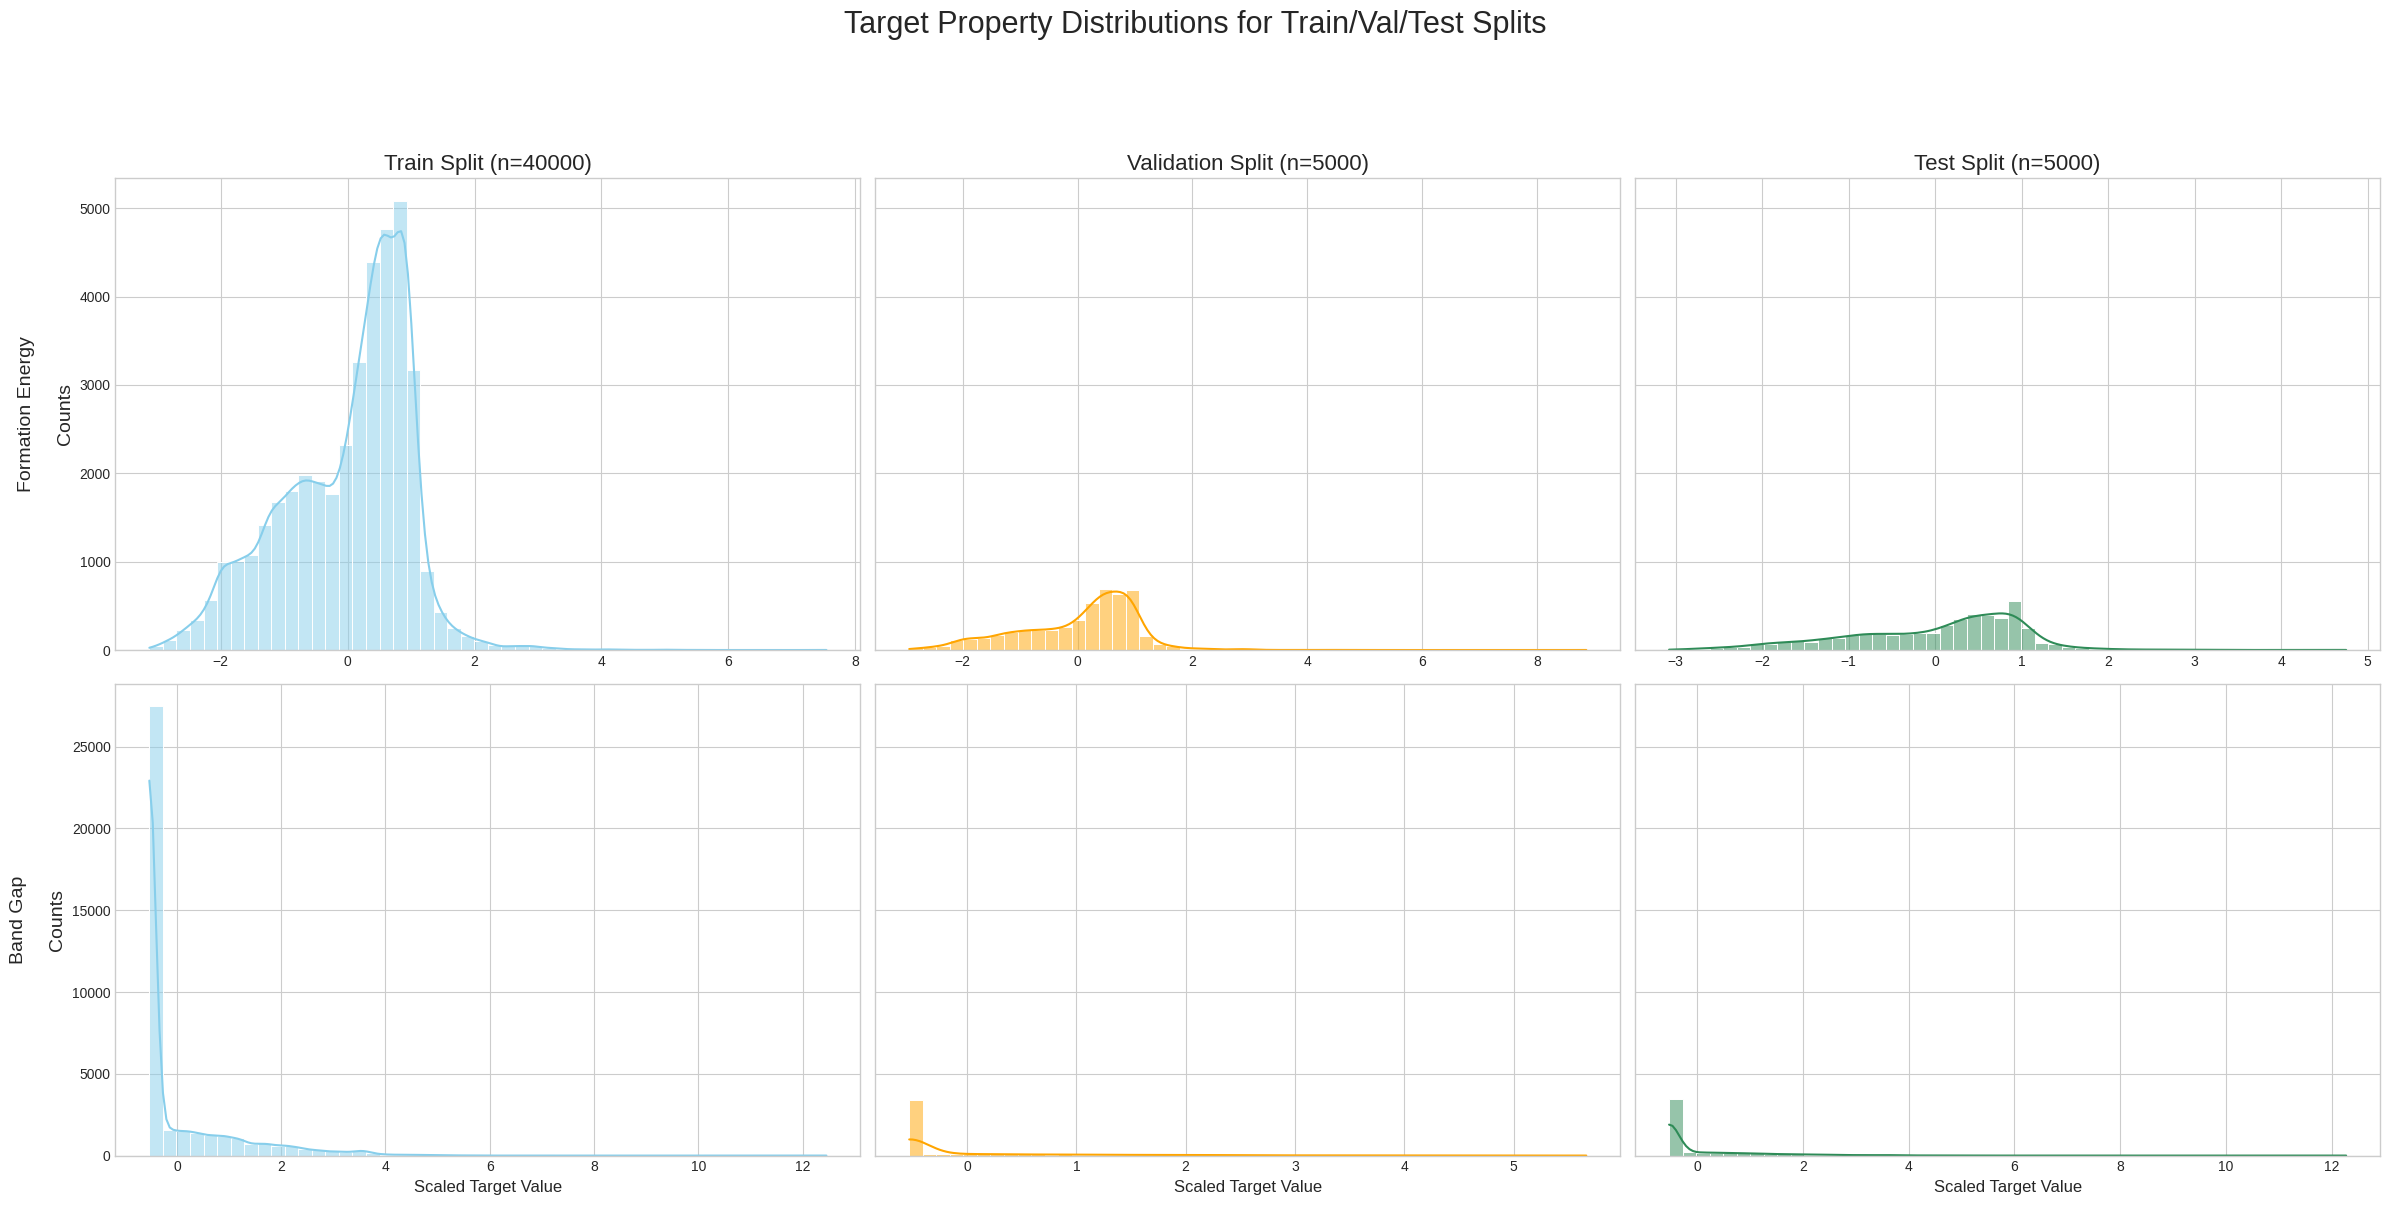


--- Kolmogorov-Smirnov Test (Train vs. Validation) ---
A high p-value (> 0.05) suggests the distributions are similar.
Formation Energy: Statistic=0.0256, p-value=0.0057
Band Gap        : Statistic=0.0224, p-value=0.0223


In [14]:
try:
    train_graphs = torch.load(train_graphs_path)
    val_graphs   = torch.load(val_graphs_path)
    test_graphs  = torch.load(test_graphs_path)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the split graph files exist at the specified paths.")
    exit()

print(f"Dataset sizes: Train={len(train_graphs)}, Validation={len(val_graphs)}, Test={len(test_graphs)}")

# --- *** CORRECTED DATA EXTRACTION *** ---
# g.y now has shape [1, 2]. We need to access [row, column].
# Since there's only one row (0), we use [0][0] for the first element
# and [0][1] for the second.

# Formation Energy (first column)
train_fe = [g.y[0][0].item() for g in train_graphs]
val_fe   = [g.y[0][0].item() for g in val_graphs]
test_fe  = [g.y[0][0].item() for g in test_graphs]

# Band Gap (second column)
train_bg = [g.y[0][1].item() for g in train_graphs]
val_bg   = [g.y[0][1].item() for g in val_graphs]
test_bg  = [g.y[0][1].item() for g in test_graphs]


# --- Create the Visualization ---
# (The rest of your plotting code is correct and does not need changes)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(24, 12), sharey='row')

fig.suptitle('Target Property Distributions for Train/Val/Test Splits', fontsize=22, y=1.03)

# Top Row: Formation Energy Distributions
sns.histplot(train_fe, ax=axes[0, 0], bins=50, kde=True, color='skyblue')
axes[0, 0].set_title(f'Train Split (n={len(train_fe)})', fontsize=16)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Formation Energy\n\nCounts', fontsize=14)
# ... (rest of the plotting code is identical) ...
sns.histplot(val_fe, ax=axes[0, 1], bins=50, kde=True, color='orange')
axes[0, 1].set_title(f'Validation Split (n={len(val_fe)})', fontsize=16)
axes[0, 1].set_xlabel('')

sns.histplot(test_fe, ax=axes[0, 2], bins=50, kde=True, color='seagreen')
axes[0, 2].set_title(f'Test Split (n={len(test_fe)})', fontsize=16)
axes[0, 2].set_xlabel('')

# Bottom Row: Band Gap Distributions
sns.histplot(train_bg, ax=axes[1, 0], bins=50, kde=True, color='skyblue')
axes[1, 0].set_xlabel('Scaled Target Value', fontsize=12)
axes[1, 0].set_ylabel('Band Gap\n\nCounts', fontsize=14)

sns.histplot(val_bg, ax=axes[1, 1], bins=50, kde=True, color='orange')
axes[1, 1].set_xlabel('Scaled Target Value', fontsize=12)

sns.histplot(test_bg, ax=axes[1, 2], bins=50, kde=True, color='seagreen')
axes[1, 2].set_xlabel('Scaled Target Value', fontsize=12)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
output_path = "Datasets/train_val_test_splits_distribution_multi_target.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved to '{output_path}'")
plt.show()

# --- Optional: Check for distribution similarity (statistical test) ---
from scipy.stats import ks_2samp

ks_fe_train_val = ks_2samp(train_fe, val_fe)
ks_bg_train_val = ks_2samp(train_bg, val_bg)

print("\n--- Kolmogorov-Smirnov Test (Train vs. Validation) ---")
print("A high p-value (> 0.05) suggests the distributions are similar.")
print(f"Formation Energy: Statistic={ks_fe_train_val.statistic:.4f}, p-value={ks_fe_train_val.pvalue:.4f}")
print(f"Band Gap        : Statistic={ks_bg_train_val.statistic:.4f}, p-value={ks_bg_train_val.pvalue:.4f}")


## <span style="font-family: 'Courier New'; color: #ffffffff;">Graph Visualization</span>

In [15]:
# The output directory for our 3D files
OUTPUT_3D_DIR = "Datasets/3D_Structures"
os.makedirs(OUTPUT_3D_DIR, exist_ok=True)

# --- Helper Function to Create and Save 3D View ---
def create_and_save_3d_view(structure, formula, material_id, index):
    """
    Creates a 3D view from a pymatgen structure, displays it,
    and saves it to a predictable filename based on the index.
    """
    print(f"-> Creating new 3D visualization for {formula} (index {index})...")
    
    # Create the py3Dmol viewer
    viewer = py3Dmol.view(width=600, height=400)
    viewer.addModel(str(structure.to(fmt="cif")), 'cif') # More direct way to get CIF
    viewer.setStyle({'stick': {'radius': 0.1}, 'sphere': {'scale': 0.3}})
    viewer.zoomTo()
    
    # Display the newly created viewer
    display(viewer)
    
    # --- Save the files ---
    # We create a predictable filename that only depends on the index,
    # so we can find it later without needing the pickle file.
    base_filename = "Si"
    html_path = os.path.join(OUTPUT_3D_DIR, f"{base_filename}.html")
    
    # Save the interactive HTML file
    viewer.write_html(html_path)
    print(f"✅ Saved interactive 3D viewer to: '{html_path}'")
    
    # Save the data CIF file
    cif_path = os.path.join(OUTPUT_3D_DIR, f"{base_filename}.cif")
    structure.to(fmt="cif", filename=cif_path)
    print(f"✅ Saved 3D structure data to:   '{cif_path}'")
    
    return html_path

# --- Main Logic ---
def main():
    """
    Main script logic to find, view, or create 3D structure files.
    """
    print("--- Starting 3D Structure Visualization Script ---")
    
    pickle_path = dataset_path
    
    # We use a predictable filename based on the index so we can find it
    # even if we can't open the pickle file.
    expected_html_filename = "Si.html"
    expected_html_path = os.path.join(OUTPUT_3D_DIR, expected_html_filename)

    # --- Step 1: Check if the 3D structure file already exists ---
    if os.path.exists(expected_html_path):
        print(f"✅ Found pre-saved 3D structure file: '{expected_html_path}'")
        print("   Displaying the existing file...")
        # Use IFrame to embed the existing HTML file directly in the notebook output
        with open(expected_html_path, 'r') as f:
            html_content = f.read()
        display(HTML(html_content))
        
    # --- Step 2: If it doesn't exist, try to create it from the pickle file ---
    else:
        print(f"⚠️ Pre-saved 3D file not found at '{expected_html_path}'.")
        print("   Attempting to create it from the source pickle file...")

        try:
            # This is the only place we try to read the risky pickle file
            df = pd.read_pickle(pickle_path)
            print("   Successfully loaded DataFrame from pickle file.")
            
            # Get the required data for the specific material
            material_info = df.iloc[9]
            structure = material_info['structure']
            formula = material_info['formula_pretty']
            material_id = material_info['material_id']

            # Call the function to create, display, and save the view
            create_and_save_3d_view(structure, formula, material_id, 9)

        except Exception as e:
            # This block catches the NumPy error or if the file is missing
            print("\n" + "="*60)
            print(f"❌ CRITICAL ERROR: Could not read the pickle file.")
            print(f"   Reason: {e}")
            print(f"   And a pre-saved 3D structure file ('{expected_html_filename}') does not exist.")
            print("   Cannot proceed. Stopping the script as requested.")
            print("="*60)

    print("\n--- Script Finished ---")


if __name__ == "__main__":
    main()

--- Starting 3D Structure Visualization Script ---
✅ Found pre-saved 3D structure file: 'Datasets/3D_Structures/Si.html'
   Displaying the existing file...



--- Script Finished ---



# <span style="font-family: 'Courier New'; color: #ffffffff;">Training</span>


## <span style="font-family: 'Courier New'; color: #ffffffff;">Model Archictecture</span>

In [12]:
# --- 1. GNN Architectures and Wrappers ---

class GNN(torch.nn.Module):
    # CHANGED: Added out_channels parameter for flexibility
    def __init__(self, feature_size, embedding_size=128, dropout_rate=0.25, out_channels=2):
        super(GNN, self).__init__()
        self.embedding = torch.nn.Embedding(feature_size, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.fc1 = Linear(embedding_size, embedding_size // 2)
        # CHANGED: The final layer now outputs `out_channels` values (e.g., 2)
        self.fc2 = Linear(embedding_size // 2, out_channels)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.embedding(x.squeeze())
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- CGCNN Source Code ---
# No changes needed in the base ConvLayer
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin1 = Linear(2 * in_channels + 1, out_channels)
        self.lin2 = Linear(2 * in_channels + 1, out_channels)
        self.bn = BatchNorm1d(out_channels)

    def forward(self, x, edge_index, edge_attr):
        row, col = edge_index
        z = torch.cat([x[row], x[col], edge_attr], dim=-1)
        out = self.lin1(z).sigmoid() * F.softplus(self.lin2(z))
        out = scatter(out, col, dim=0, dim_size=x.size(0), reduce='add')
        out = self.bn(out)
        return F.softplus(x + out)

# No changes needed in the base CGCNN, as it's already parameterized by out_channels
class CGCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=128, out_channels=2, num_layers=3):
        super().__init__()
        self.embedding = Linear(in_channels, hidden_channels)
        self.convs = torch.nn.ModuleList(
            [ConvLayer(hidden_channels, hidden_channels) for _ in range(num_layers)])
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.embedding(x)
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
        x = global_add_pool(x, batch)
        return self.lin(x)

# --- MEGNet Source Code ---
# No changes needed in the base MEGNet, as it's already parameterized by out_channels
class MEGNet(torch.nn.Module):
    def __init__(self, in_channels, edge_in_channels=1, out_channels=2):
        super().__init__()
        from torch_geometric.nn import GATConv, global_add_pool
        self.node_encoder = Linear(in_channels, 64)
        self.edge_encoder = Linear(edge_in_channels, 64)
        self.gat_conv1 = GATConv(64, 64, heads=4, concat=True)
        self.gat_conv2 = GATConv(64 * 4, 64, heads=4, concat=True)
        self.lin = Linear(64 * 4, out_channels)

    def forward(self, x, edge_index, edge_attr, batch=None):
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        x = F.elu(self.gat_conv1(x, edge_index, edge_attr))
        x = F.elu(self.gat_conv2(x, edge_index, edge_attr))
        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x

# --- Wrappers for consistent API ---
class SchNetWrapper(SchNet):
    def __init__(self, hidden_channels=128, out_channels=2, **kwargs):
        # Initialize the base SchNet model
        super().__init__(hidden_channels=hidden_channels, **kwargs)
        
        # --- THE FIX ---
        # The original SchNet model has a final linear layer called `lin2`
        # that maps the graph-level representation (of size hidden_channels // 2) to a single output.
        # We will REPLACE this layer with our own to map to `out_channels`.
        
        # First, find the input size to the original lin2 layer.
        # By inspecting the SchNet source, we know it's hidden_channels // 2.
        in_features = self.lin2.in_features
        
        # Now, replace the layer.
        self.lin2 = Linear(in_features, out_channels)

    def forward(self, data):
        # Now we can just call the parent's forward method directly.
        # It will use our modified `lin2` layer at the end.
        return super().forward(data.z, data.pos, data.batch)

class CGCNNWrapper(torch.nn.Module):
    # CHANGED: Added out_channels parameter
    def __init__(self, out_channels=2, **kwargs):
        super().__init__()
        self.embedding = torch.nn.Embedding(104, 64)
        # CHANGED: Pass the out_channels parameter to the CGCNN model
        self.cgcnn = CGCNN(in_channels=64, out_channels=out_channels, **kwargs)

    def forward(self, data):
        embedded_x = self.embedding(data.x.squeeze(-1))
        return self.cgcnn(embedded_x, data.edge_index, data.edge_attr, batch=data.batch)

class MEGNetWrapper(torch.nn.Module):
    # CHANGED: Added out_channels parameter
    def __init__(self, out_channels=2, **kwargs):
        super().__init__()
        self.embedding = torch.nn.Embedding(104, 64)
        # CHANGED: Pass the out_channels parameter to the MEGNet model
        self.megnet = MEGNet(in_channels=64, edge_in_channels=1, out_channels=out_channels, **kwargs)

    def forward(self, data):
        embedded_x = self.embedding(data.x.squeeze(-1))
        return self.megnet(embedded_x, data.edge_index, data.edge_attr, batch=data.batch)

# --- 4. Model Factory ---
def get_model(model_name, device, out_channels=2):
    """Factory function to instantiate models for multi-target regression."""
    if model_name == 'GNN':
        return GNN(feature_size=104, out_channels=out_channels).to(device)
    elif model_name == 'SchNet':
        # This will now use the corrected SchNetWrapper
        return SchNetWrapper(hidden_channels=128, out_channels=out_channels).to(device)
    elif model_name == 'CGCNN':
        return CGCNNWrapper(hidden_channels=128, out_channels=out_channels).to(device)
    elif model_name == 'MEGNet':
        return MEGNetWrapper(out_channels=out_channels).to(device)
    else:
        raise ValueError(f"Unknown model name: {model_name}")


## <span style="font-family: 'Courier New'; color: #ffffffff;">Helper Functions</span>

In [13]:
# --- 2. Helper Functions (MODIFIED for Multi-Target) ---

def train(model, loader, optimizer, loss_fn, device):
    """
    Performs one training epoch for a multi-target regression model.
    """
    model.train()
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Output will have shape [batch_size, 2]
        output = model(batch)
        
        # batch.y also has shape [batch_size, 2]
        # Loss function (e.g., MSELoss) correctly computes the mean loss across both targets
        loss = loss_fn(output, batch.y)
        
        loss.backward()
        optimizer.step()

def test(model, loader, device):
    """
    Calculates metrics (MAE, MSE, RMSE, R2) for each target separately.
    
    Returns:
        dict: A dictionary containing metrics for each target.
              Example: {'fe_mae': 0.1, 'bg_mae': 0.2, ...}
    """
    model.eval()
    all_preds = []
    all_truths = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)
            # Both output and batch.y are [batch_size, 2]
            all_preds.append(output.cpu().numpy())
            all_truths.append(batch.y.cpu().numpy())
    
    # Concatenate along the batch dimension (axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    all_truths = np.concatenate(all_truths, axis=0)
    
    # --- Calculate metrics for each target ---
    
    # Target 0: Formation Energy
    fe_truth = all_truths[:, 0]
    fe_pred = all_preds[:, 0]
    
    # Target 1: Band Gap
    bg_truth = all_truths[:, 1]
    bg_pred = all_preds[:, 1]
    
    metrics = {
        # Formation Energy Metrics
        'fe_mae': mean_absolute_error(fe_truth, fe_pred),
        'fe_mse': mean_squared_error(fe_truth, fe_pred),
        'fe_rmse': np.sqrt(mean_squared_error(fe_truth, fe_pred)),
        'fe_r2': r2_score(fe_truth, fe_pred),
        
        # Band Gap Metrics
        'bg_mae': mean_absolute_error(bg_truth, bg_pred),
        'bg_mse': mean_squared_error(bg_truth, bg_pred),
        'bg_rmse': np.sqrt(mean_squared_error(bg_truth, bg_pred)),
        'bg_r2': r2_score(bg_truth, bg_pred),
    }
    
    return metrics

def get_uncertainty_estimates(model, unlabeled_loader, n_forward_passes, device):
    """
    Calculates MC Dropout uncertainty for a multi-target model.
    The output uncertainty will have a dimension for each target.
    
    Returns:
        np.array: An array of shape [num_samples, num_targets]
    """
    # Set the model to training mode to enable dropout
    model.train() 
    all_uncertainties = []
    with torch.no_grad():
        for batch in unlabeled_loader:
            batch = batch.to(device)
            
            # predictions will be shape [n_passes, batch_size, 2]
            predictions = torch.stack([model(batch) for _ in range(n_forward_passes)])
            
            # var(dim=0) calculates variance across the n_passes dimension.
            # The result is shape [batch_size, 2], giving variance for each target.
            uncertainty = predictions.var(dim=0) 
            
            all_uncertainties.append(uncertainty.cpu().numpy())
            
    return np.concatenate(all_uncertainties, axis=0)

def get_ensemble_uncertainty(ensemble_models, unlabeled_loader, device):
    """
    Calculates uncertainty using a Deep Ensemble.
    Uncertainty is the variance across predictions from different models in the ensemble.
    """
    # Set all models to evaluation mode (dropout is OFF)
    for model in ensemble_models:
        model.eval()
        
    all_uncertainties = []
    with torch.no_grad():
        for batch in unlabeled_loader:
            batch = batch.to(device)
            
            # Get a prediction from EACH model in the ensemble for the same batch
            # This will create a list of tensors, e.g., 5 tensors of shape [batch_size, 2]
            predictions_from_each_model = [model(batch) for model in ensemble_models]
            
            # Stack them along a new dimension to create a single tensor
            # Shape becomes: [num_ensemble_members, batch_size, 2]
            stacked_predictions = torch.stack(predictions_from_each_model)
            
            # Calculate the variance across the ensemble dimension (dim=0)
            # The result is the uncertainty for each target property
            # Shape becomes: [batch_size, 2]
            uncertainty = stacked_predictions.var(dim=0) 
            
            all_uncertainties.append(uncertainty.cpu().numpy())
            
    return np.concatenate(all_uncertainties, axis=0)


## <span style="font-family: 'Courier New'; color: #ffffffff;">Active Learning</span>

In [41]:
# --- 3. Main Active Learning Loop ---
if __name__ == '__main__':
    MODELS_TO_TEST = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
    
    # Create output directory if it doesn't exist
    output_dir = 'ActiveLearning'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for model_name in MODELS_TO_TEST:
        print(f"\n{'='*20} RUNNING ACTIVE LEARNING FOR: {model_name.upper()} {'='*20}")
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Load the entire dataset which will be split
        full_dataset = torch.load(train_graphs_path)
        
        # --- Create reproducible splits ---
        all_indices = list(range(len(full_dataset)))
        random.seed(42)
        random.shuffle(all_indices)
        
        # Define a fixed test set that is never touched during active learning
        test_indices = all_indices[:1000] # Using a smaller test set for AL demo
        pool_indices = all_indices[1000:]
        
        test_set = [full_dataset[i] for i in test_indices]
        test_loader = DataLoader(test_set, batch_size=64)

        # Initial split of the pool into labeled and unlabeled sets
        labeled_indices = pool_indices[:INITIAL_SIZE]
        unlabeled_indices = pool_indices[INITIAL_SIZE:]
        
        learning_curve_history = []
        queried_material_ids_history = []

        print("\n--- Starting Active Learning Simulation ---")
        for cycle in range(NUM_CYCLES + 1):
            current_train_size = len(labeled_indices)
            print(f"\n--- Cycle {cycle}: Training with {current_train_size} labeled samples ---")

            labeled_set = [full_dataset[i] for i in labeled_indices]
            train_loader = DataLoader(labeled_set, batch_size=32, shuffle=True)
            
            # get_model now returns a model with 2 output channels
            model = get_model(model_name, device, out_channels=2) 
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            # Use MSELoss for multi-target regression, as it's a standard choice
            loss_fn = MSELoss()

            for epoch in range(1, EPOCHS_PER_CYCLE + 1):
                train(model, train_loader, optimizer, loss_fn, device)
            
            # The test function now returns a dictionary with prefixed metrics
            metrics = test(model, test_loader, device)
            # CHANGED: Print metrics for both targets for clarity
            print(f"Cycle {cycle} | FE MAE: {metrics['fe_mae']:.4f}, BG MAE: {metrics['bg_mae']:.4f} | "
                  f"FE R2: {metrics['fe_r2']:.4f}, BG R2: {metrics['bg_r2']:.4f}")
            
            # The metrics dictionary is now directly logged
            history_entry = {'cycle': cycle, 'train_size': current_train_size, **metrics}
            learning_curve_history.append(history_entry)
            
            if cycle < NUM_CYCLES:
                unlabeled_set_for_query = [full_dataset[i] for i in unlabeled_indices]
                unlabeled_loader = DataLoader(unlabeled_set_for_query, batch_size=64)

                print(f"Actively querying {QUERY_SIZE} new samples...")
                
                # CHANGED: Handle multi-target uncertainty
                # uncertainties will have shape [num_unlabeled, 2]
                uncertainties = get_uncertainty_estimates(model, unlabeled_loader, N_FORWARD_PASSES, device)
                
                # Combine uncertainties into a single score. Here, we sum the variances.
                # This creates a 1D array of shape [num_unlabeled]
                combined_uncertainty = np.sum(uncertainties, axis=1)
                
                # Sort based on the combined score
                most_uncertain_local_indices = np.argsort(combined_uncertainty)[-QUERY_SIZE:]
                
                # --- The rest of the logic remains the same ---
                indices_to_add = [unlabeled_indices[i] for i in most_uncertain_local_indices]
                
                chosen_ids = [{'cycle': cycle, 'material_id': full_dataset[i].material_id} for i in indices_to_add]
                queried_material_ids_history.extend(chosen_ids)
                
                labeled_indices.extend(indices_to_add)
                unlabeled_indices = [idx for idx in unlabeled_indices if idx not in indices_to_add]

        print(f"\n--- Active Learning Simulation Complete for {model_name} ---")

        # --- 4. Save History and Final Model ---
        # The DataFrame will now have columns like fe_mae, bg_mae, fe_r2, etc.
        pd.DataFrame(learning_curve_history).to_csv(f'{output_dir}/active_history_{model_name}_multi_target.csv', index=False)
        print(f"Active learning history saved to '{output_dir}/active_history_{model_name}_multi_target.csv'")

        pd.DataFrame(queried_material_ids_history).to_csv(f'{output_dir}/active_queried_ids_{model_name}_multi_target.csv', index=False)
        print(f"History of actively queried material IDs saved to '{output_dir}/active_queried_ids_{model_name}_multi_target.csv'")

        torch.save(model.state_dict(), f'{output_dir}/active_model_{model_name}_multi_target.pth')
        print(f"Final active learning model saved to '{output_dir}/active_model_{model_name}_multi_target.pth'")


==================== RUNNING ACTIVE LEARNING FOR: GNN ====================
Using device: cuda

--- Starting Active Learning Simulation ---

--- Cycle 0: Training with 5000 labeled samples ---
Cycle 0 | FE MAE: 0.2084, BG MAE: 0.3713 | FE R2: 0.8892, BG R2: 0.5639
Actively querying 1000 new samples...

--- Cycle 1: Training with 6000 labeled samples ---
Cycle 1 | FE MAE: 0.2173, BG MAE: 0.3587 | FE R2: 0.8943, BG R2: 0.5982
Actively querying 1000 new samples...

--- Cycle 2: Training with 7000 labeled samples ---
Cycle 2 | FE MAE: 0.1976, BG MAE: 0.3683 | FE R2: 0.8994, BG R2: 0.5421
Actively querying 1000 new samples...

--- Cycle 3: Training with 8000 labeled samples ---
Cycle 3 | FE MAE: 0.1989, BG MAE: 0.3638 | FE R2: 0.9005, BG R2: 0.5605
Actively querying 1000 new samples...

--- Cycle 4: Training with 9000 labeled samples ---
Cycle 4 | FE MAE: 0.1941, BG MAE: 0.3431 | FE R2: 0.9078, BG R2: 0.5972
Actively querying 1000 new samples...

--- Cycle 5: Training with 10000 labeled sam



## <span style="font-family: 'Courier New'; color: #ffffffff;">Deep Ensemble Active Learning</span>

In [18]:



# --- Main Deep Ensemble Active Learning Loop ---
if __name__ == '__main__':
    MODELS_TO_TEST = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
    
    output_dir = 'EnsembleActiveLearning'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for model_name in MODELS_TO_TEST:
        print(f"\n{'='*20} RUNNING DEEP ENSEMBLE AL FOR: {model_name.upper()} {'='*20}")
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        full_dataset = torch.load(train_graphs_path)
        
        # Create reproducible splits for fair comparison
        all_indices = list(range(len(full_dataset)))
        random.seed(42)
        random.shuffle(all_indices)
        test_indices = all_indices[:1000]
        pool_indices = all_indices[1000:]
        
        test_set = [full_dataset[i] for i in test_indices]
        test_loader = DataLoader(test_set, batch_size=64)
        
        labeled_indices = pool_indices[:INITIAL_SIZE]
        unlabeled_indices = pool_indices[INITIAL_SIZE:]
        
        learning_curve_history = []
        queried_material_ids_history = [] # To store the chosen material IDs

        print("\n--- Starting Active Learning Simulation (Deep Ensemble) ---")
        for cycle in range(NUM_CYCLES + 1):
            current_train_size = len(labeled_indices)
            print(f"\n--- Cycle {cycle}: Training with {current_train_size} labeled samples ---")

            labeled_set = [full_dataset[i] for i in labeled_indices]
            train_loader = DataLoader(labeled_set, batch_size=32, shuffle=True)
            
            # --- Train an ENSEMBLE of models ---
            ensemble_models = []
            print(f"Training an ensemble of {NUM_ENSEMBLE_MEMBERS} models...")
            for member_idx in range(NUM_ENSEMBLE_MEMBERS):
                print(f"  Training member {member_idx + 1}/{NUM_ENSEMBLE_MEMBERS}...")
                
                model = get_model(model_name, device, out_channels=2)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                loss_fn = MSELoss()

                for epoch in range(1, EPOCHS_PER_CYCLE + 1):
                    train(model, train_loader, optimizer, loss_fn, device)
                
                ensemble_models.append(model)
            
            # --- Evaluate and log performance ---
            # Using the first model's performance as a representative for the learning curve
            metrics = test(ensemble_models[0], test_loader, device)
            print(f"Cycle {cycle} | FE MAE: {metrics['fe_mae']:.4f}, BG MAE: {metrics['bg_mae']:.4f}")
            
            history_entry = {'cycle': cycle, 'train_size': current_train_size, **metrics}
            learning_curve_history.append(history_entry)
            
            if cycle < NUM_CYCLES:
                unlabeled_set_for_query = [full_dataset[i] for i in unlabeled_indices]
                unlabeled_loader = DataLoader(unlabeled_set_for_query, batch_size=64)

                print(f"Actively querying {QUERY_SIZE} new samples using the ensemble...")
                uncertainties = get_ensemble_uncertainty(ensemble_models, unlabeled_loader, device)
                
                combined_uncertainty = np.sum(uncertainties, axis=1)
                most_uncertain_local_indices = np.argsort(combined_uncertainty)[-QUERY_SIZE:]
                
                indices_to_add = [unlabeled_indices[i] for i in most_uncertain_local_indices]
                
                # --- Record the material IDs of the chosen samples ---
                chosen_ids = [{'cycle': cycle, 'material_id': full_dataset[i].material_id} for i in indices_to_add]
                queried_material_ids_history.extend(chosen_ids)
                
                # Update the labeled and unlabeled pools
                labeled_indices.extend(indices_to_add)
                unlabeled_indices = [idx for idx in unlabeled_indices if idx not in indices_to_add]

        print(f"\n--- Deep Ensemble AL Simulation Complete for {model_name} ---")

        # --- Save History, Queried IDs, and the entire ENSEMBLE ---
        # 1. Save the learning curve
        pd.DataFrame(learning_curve_history).to_csv(f'{output_dir}/active_history_{model_name}_ensemble.csv', index=False)
        print(f"Ensemble learning history saved to '{output_dir}/active_history_{model_name}_ensemble.csv'")

        # 2. Save the queried material IDs
        pd.DataFrame(queried_material_ids_history).to_csv(f'{output_dir}/active_queried_ids_{model_name}_ensemble.csv', index=False)
        print(f"Ensemble queried material IDs saved to '{output_dir}/active_queried_ids_{model_name}_ensemble.csv'")

        # 3. Save the final ensemble models
        ensemble_save_dir = f'{output_dir}/ensemble_{model_name}_multi_target'
        os.makedirs(ensemble_save_dir, exist_ok=True)
        for member_idx, model in enumerate(ensemble_models):
            torch.save(model.state_dict(), f'{ensemble_save_dir}/member_{member_idx}.pth')
        print(f"Final ensemble of {NUM_ENSEMBLE_MEMBERS} models saved to '{ensemble_save_dir}'")


==================== RUNNING DEEP ENSEMBLE AL FOR: GNN ====================
Using device: cuda

--- Starting Active Learning Simulation (Deep Ensemble) ---

--- Cycle 0: Training with 5000 labeled samples ---
Training an ensemble of 5 models...
  Training member 1/5...
  Training member 2/5...
  Training member 3/5...
  Training member 4/5...
  Training member 5/5...
Cycle 0 | FE MAE: 0.2088, BG MAE: 0.3913
Actively querying 1000 new samples using the ensemble...

--- Cycle 1: Training with 6000 labeled samples ---
Training an ensemble of 5 models...
  Training member 1/5...
  Training member 2/5...
  Training member 3/5...
  Training member 4/5...
  Training member 5/5...
Cycle 1 | FE MAE: 0.2148, BG MAE: 0.3526
Actively querying 1000 new samples using the ensemble...

--- Cycle 2: Training with 7000 labeled samples ---
Training an ensemble of 5 models...
  Training member 1/5...
  Training member 2/5...
  Training member 3/5...
  Training member 4/5...
  Training member 5/5...
Cycle


## <span style="font-family: 'Courier New'; color: #ffffffff;">Random Sampling</span>

In [19]:
# --- 3. Main Random Sampling Loop ---
if __name__ == '__main__':
    MODELS_TO_TEST = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
    
    # Create output directory if it doesn't exist
    output_dir = 'RandomSampling'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for model_name in MODELS_TO_TEST:
        print(f"\n{'='*20} RUNNING RANDOM SAMPLING FOR: {model_name.upper()} {'='*20}")
    
        # Setup
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        full_dataset = torch.load(train_graphs_path)
        
        # Create reproducible splits
        all_indices = list(range(len(full_dataset)))
        random.seed(42)
        random.shuffle(all_indices)
        
        test_set_size = 1000 # Using a smaller test set for demo
        test_indices = all_indices[:test_set_size]
        pool_indices = all_indices[test_set_size:]
        
        test_set = [full_dataset[i] for i in test_indices]
        test_loader = DataLoader(test_set, batch_size=64)

        labeled_indices = pool_indices[:INITIAL_SIZE]
        unlabeled_indices = pool_indices[INITIAL_SIZE:]
        learning_curve_history = []

        print("\n--- Starting Random Sampling Simulation ---")
        for cycle in range(NUM_CYCLES + 1):
            current_train_size = len(labeled_indices)
            print(f"\n--- Cycle {cycle}: Training with {current_train_size} labeled samples ---")

            labeled_set = [full_dataset[i] for i in labeled_indices]
            train_loader = DataLoader(labeled_set, batch_size=32, shuffle=True)
            
            # CHANGED: Instantiate model with 2 output channels for multi-target
            model = get_model(model_name, device, out_channels=2)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            # CHANGED: Use MSELoss, a standard choice for multi-target regression
            loss_fn = MSELoss()

            for epoch in range(1, EPOCHS_PER_CYCLE + 1):
                train(model, train_loader, optimizer, loss_fn, device)
            
            # The test function now returns a dictionary with prefixed metrics
            metrics = test(model, test_loader, device)
            # CHANGED: Print metrics for both targets for clarity
            print(f"Cycle {cycle} | FE MAE: {metrics['fe_mae']:.4f}, BG MAE: {metrics['bg_mae']:.4f} | "
                  f"FE R2: {metrics['fe_r2']:.4f}, BG R2: {metrics['bg_r2']:.4f}")

            # This part correctly handles the new metrics dictionary
            history_entry = {'cycle': cycle, 'train_size': current_train_size, **metrics}
            learning_curve_history.append(history_entry)
            
            if cycle < NUM_CYCLES:
                print(f"Randomly querying {QUERY_SIZE} new samples...")
                # The core random sampling logic does not need to be changed
                # Re-seed each cycle for different random samples, but still reproducible
                random.seed(42 + cycle) 
                random.shuffle(unlabeled_indices)
                indices_to_add = unlabeled_indices[:QUERY_SIZE]
                unlabeled_indices = unlabeled_indices[QUERY_SIZE:]
                
                labeled_indices.extend(indices_to_add)

        print(f"\n--- Random Sampling Simulation Complete for {model_name} ---")

        # --- 4. Save History and Final Model ---
        # CHANGED: Updated filenames for clarity
        pd.DataFrame(learning_curve_history).to_csv(f'{output_dir}/random_history_{model_name}_multi_target.csv', index=False)
        print(f"Random sampling history saved to '{output_dir}/random_history_{model_name}_multi_target.csv'")

        torch.save(model.state_dict(), f'{output_dir}/random_model_{model_name}_multi_target.pth')
        print(f"Final random sampling model saved to '{output_dir}/random_model_{model_name}_multi_target.pth'")


==================== RUNNING RANDOM SAMPLING FOR: GNN ====================
Using device: cuda

--- Starting Random Sampling Simulation ---

--- Cycle 0: Training with 5000 labeled samples ---
Cycle 0 | FE MAE: 0.2067, BG MAE: 0.3723 | FE R2: 0.8857, BG R2: 0.5493
Randomly querying 1000 new samples...

--- Cycle 1: Training with 6000 labeled samples ---
Cycle 1 | FE MAE: 0.2094, BG MAE: 0.3553 | FE R2: 0.8958, BG R2: 0.5600
Randomly querying 1000 new samples...

--- Cycle 2: Training with 7000 labeled samples ---
Cycle 2 | FE MAE: 0.2057, BG MAE: 0.3522 | FE R2: 0.8923, BG R2: 0.5981
Randomly querying 1000 new samples...

--- Cycle 3: Training with 8000 labeled samples ---
Cycle 3 | FE MAE: 0.2015, BG MAE: 0.3516 | FE R2: 0.8930, BG R2: 0.5649
Randomly querying 1000 new samples...

--- Cycle 4: Training with 9000 labeled samples ---
Cycle 4 | FE MAE: 0.2018, BG MAE: 0.3455 | FE R2: 0.8938, BG R2: 0.5935
Randomly querying 1000 new samples...

--- Cycle 5: Training with 10000 labeled sam


## <span style="font-family: 'Courier New'; color: #ffffffff;">Traditional Learning</span>

In [20]:
# --- 5. Traditional Learning Baseline ---
if __name__ == '__main__':
    MODELS_TO_TEST = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']

    # Create output directory if it doesn't exist
    output_dir = 'TraditionalLearning'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for model_name in MODELS_TO_TEST:
        print(f"\n{'='*20} RUNNING TRADITIONAL LEARNING FOR: {model_name.upper()} {'='*20}")
        
        # Setup
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")

        full_dataset = torch.load(train_graphs_path)

        # Recreate the same test/pool split as the other methods for a fair comparison
        all_indices = list(range(len(full_dataset)))
        random.seed(42)
        random.shuffle(all_indices)
        test_indices = all_indices[:1000] # Using a smaller test set for demo
        pool_indices = all_indices[1000:]

        test_set = [full_dataset[i] for i in test_indices]
        test_loader = DataLoader(test_set, batch_size=64)

        # The training set size is the final size reached by the iterative methods
        final_train_size = INITIAL_SIZE + QUERY_SIZE * NUM_CYCLES
        print(f"Using a fixed traditional training set of size = {final_train_size}")

        traditional_indices = pool_indices[:final_train_size]
        train_set = [full_dataset[i] for i in traditional_indices]
        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

        # CHANGED: Instantiate model with 2 output channels for multi-target
        model = get_model(model_name, device, out_channels=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        # CHANGED: Use MSELoss, a standard choice for multi-target regression
        loss_fn = MSELoss()

        traditional_history = []

        # This loop trains on the SAME full dataset for multiple cycles
        # to log performance at comparable total epoch intervals to the other methods.
        for cycle in range(NUM_CYCLES + 1):
            print(f"\n--- Logging Point {cycle}: Training for {EPOCHS_PER_CYCLE} more epochs ---")

            for epoch in range(1, EPOCHS_PER_CYCLE + 1):
                train(model, train_loader, optimizer, loss_fn, device)

            # Evaluate after each block of epochs
            metrics = test(model, test_loader, device)
            # CHANGED: Print metrics for both targets for clarity
            print(f"Log Point {cycle} | FE MAE: {metrics['fe_mae']:.4f}, BG MAE: {metrics['bg_mae']:.4f} | "
                  f"FE R2: {metrics['fe_r2']:.4f}, BG R2: {metrics['bg_r2']:.4f}")

            history_entry = {'cycle': cycle, 'train_size': final_train_size, **metrics}
            traditional_history.append(history_entry)

        print(f"\n--- Traditional Learning Baseline Complete for {model_name} ---")

        # Save history + model
        # CHANGED: Updated filenames for clarity
        pd.DataFrame(traditional_history).to_csv(f'{output_dir}/traditional_history_{model_name}_multi_target.csv', index=False)
        print(f"Traditional learning history saved to '{output_dir}/traditional_history_{model_name}_multi_target.csv'")

        torch.save(model.state_dict(), f'{output_dir}/traditional_model_{model_name}_multi_target.pth')
        print(f"Final traditional learning model saved to '{output_dir}/traditional_model_{model_name}_multi_target.pth'")


==================== RUNNING TRADITIONAL LEARNING FOR: GNN ====================
Using device: cuda
Using a fixed traditional training set of size = 38000

--- Logging Point 0: Training for 50 more epochs ---
Log Point 0 | FE MAE: 0.1534, BG MAE: 0.2690 | FE R2: 0.9279, BG R2: 0.7162

--- Logging Point 1: Training for 50 more epochs ---
Log Point 1 | FE MAE: 0.1624, BG MAE: 0.2588 | FE R2: 0.9228, BG R2: 0.7357

--- Logging Point 2: Training for 50 more epochs ---
Log Point 2 | FE MAE: 0.1590, BG MAE: 0.2556 | FE R2: 0.9217, BG R2: 0.7263

--- Logging Point 3: Training for 50 more epochs ---
Log Point 3 | FE MAE: 0.1585, BG MAE: 0.2707 | FE R2: 0.9254, BG R2: 0.7387

--- Logging Point 4: Training for 50 more epochs ---
Log Point 4 | FE MAE: 0.1491, BG MAE: 0.2455 | FE R2: 0.9331, BG R2: 0.7507

--- Logging Point 5: Training for 50 more epochs ---
Log Point 5 | FE MAE: 0.1698, BG MAE: 0.2545 | FE R2: 0.9225, BG R2: 0.7486

--- Logging Point 6: Training for 50 more epochs ---
Log Point 6


# <span style="font-family: 'Courier New'; color: #ffffffff;">Results</span>

## <span style="font-family: 'Courier New'; color: #ffffffff;">Plots</span>

Comparison plot for Formation Energy saved to 'Results/final_comparison_fe_all_strategies.png'


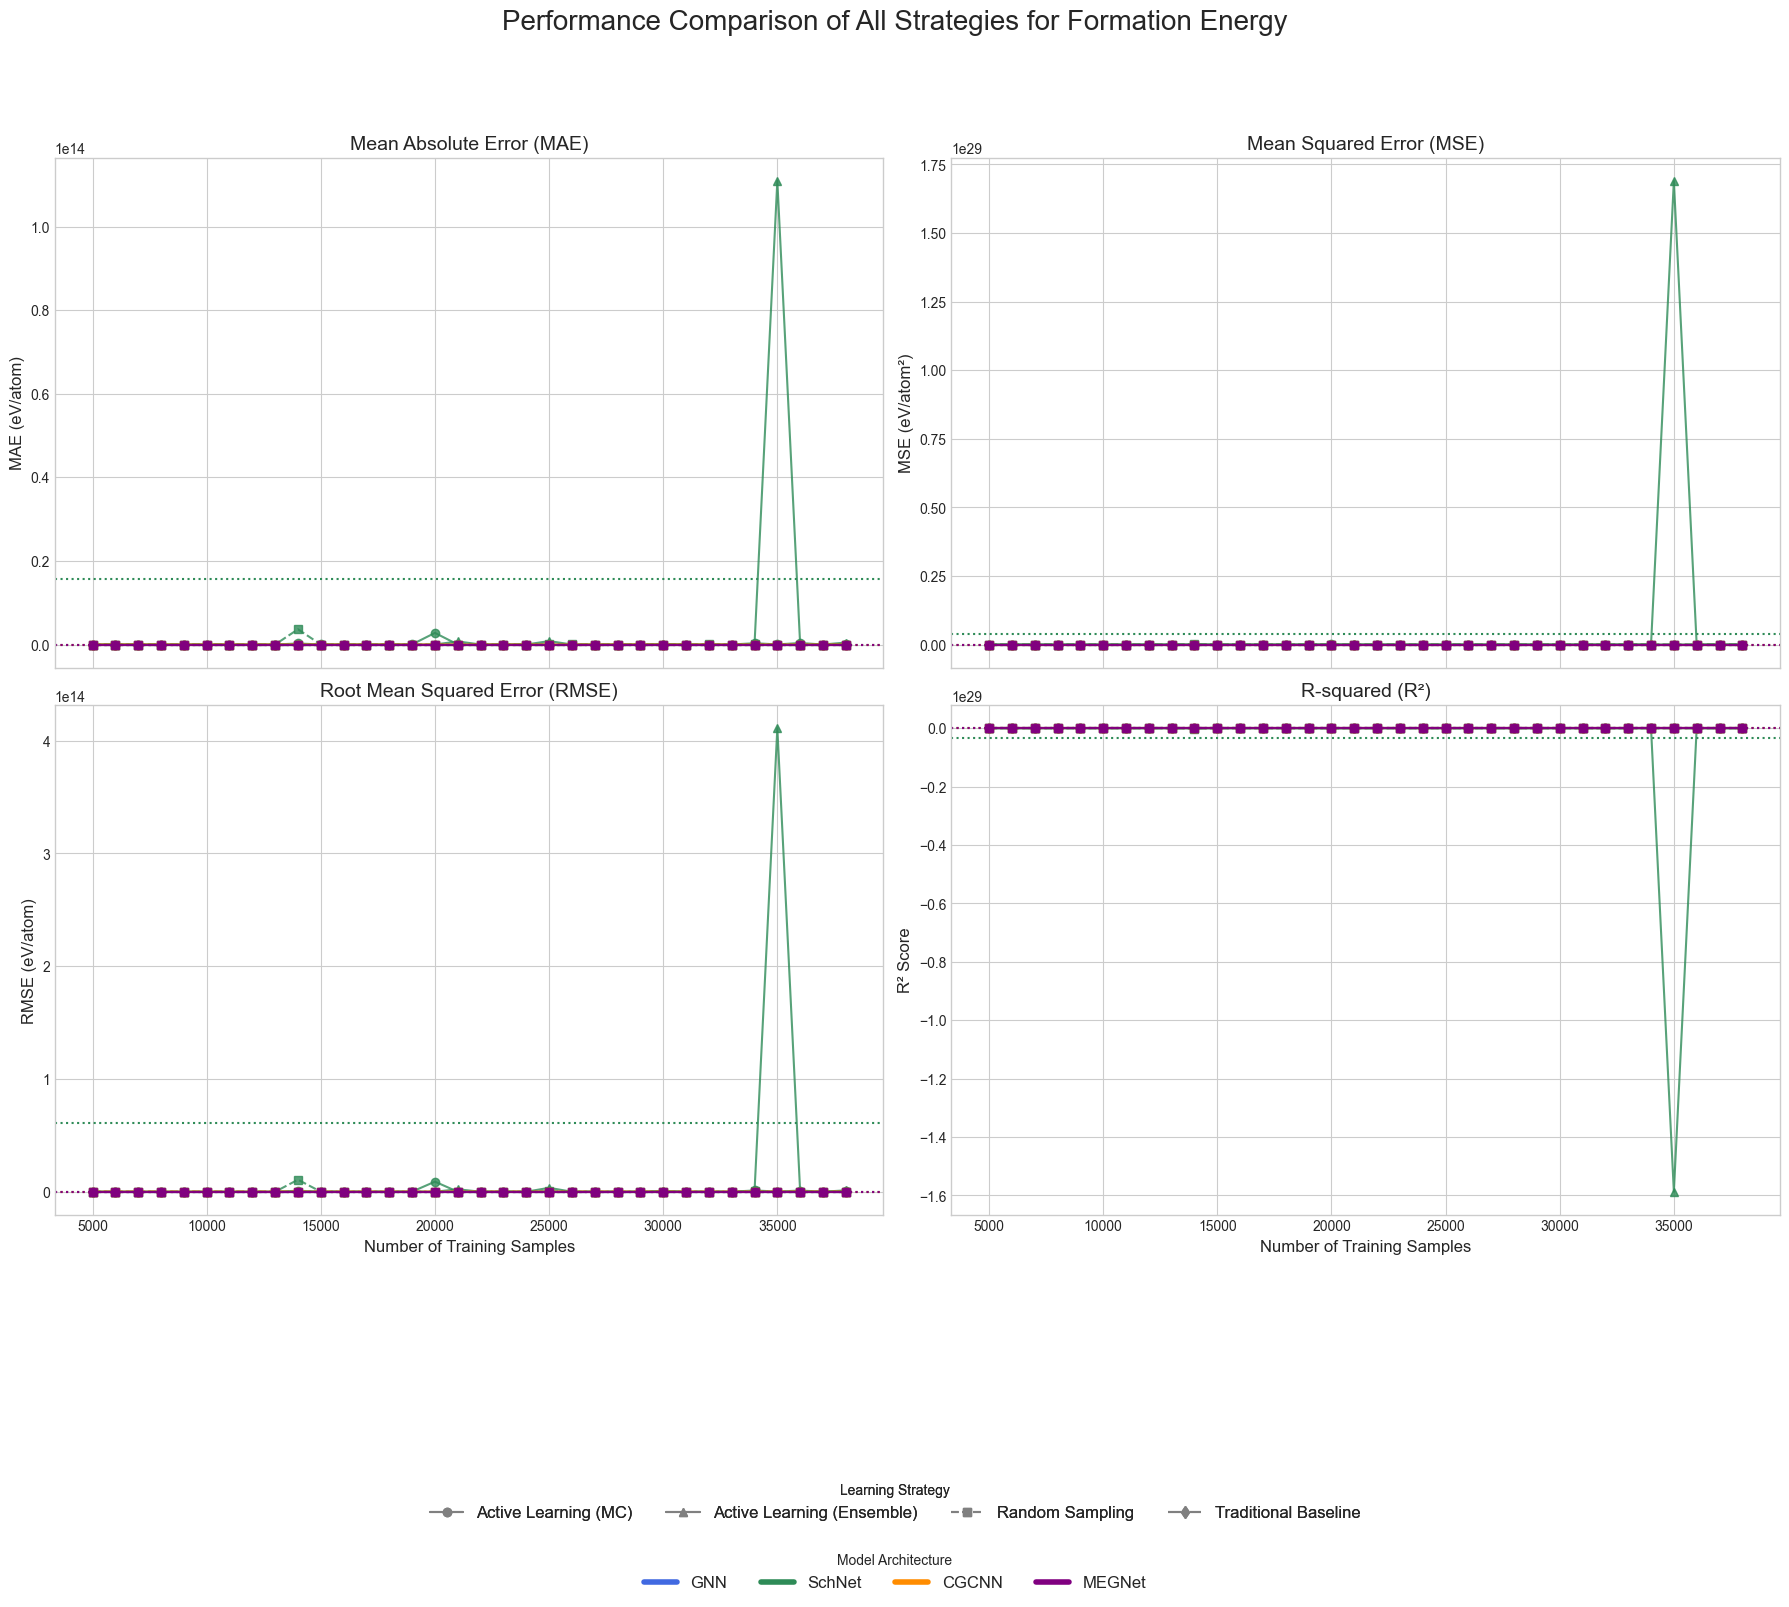

Comparison plot for Band Gap saved to 'Results/final_comparison_bg_all_strategies.png'


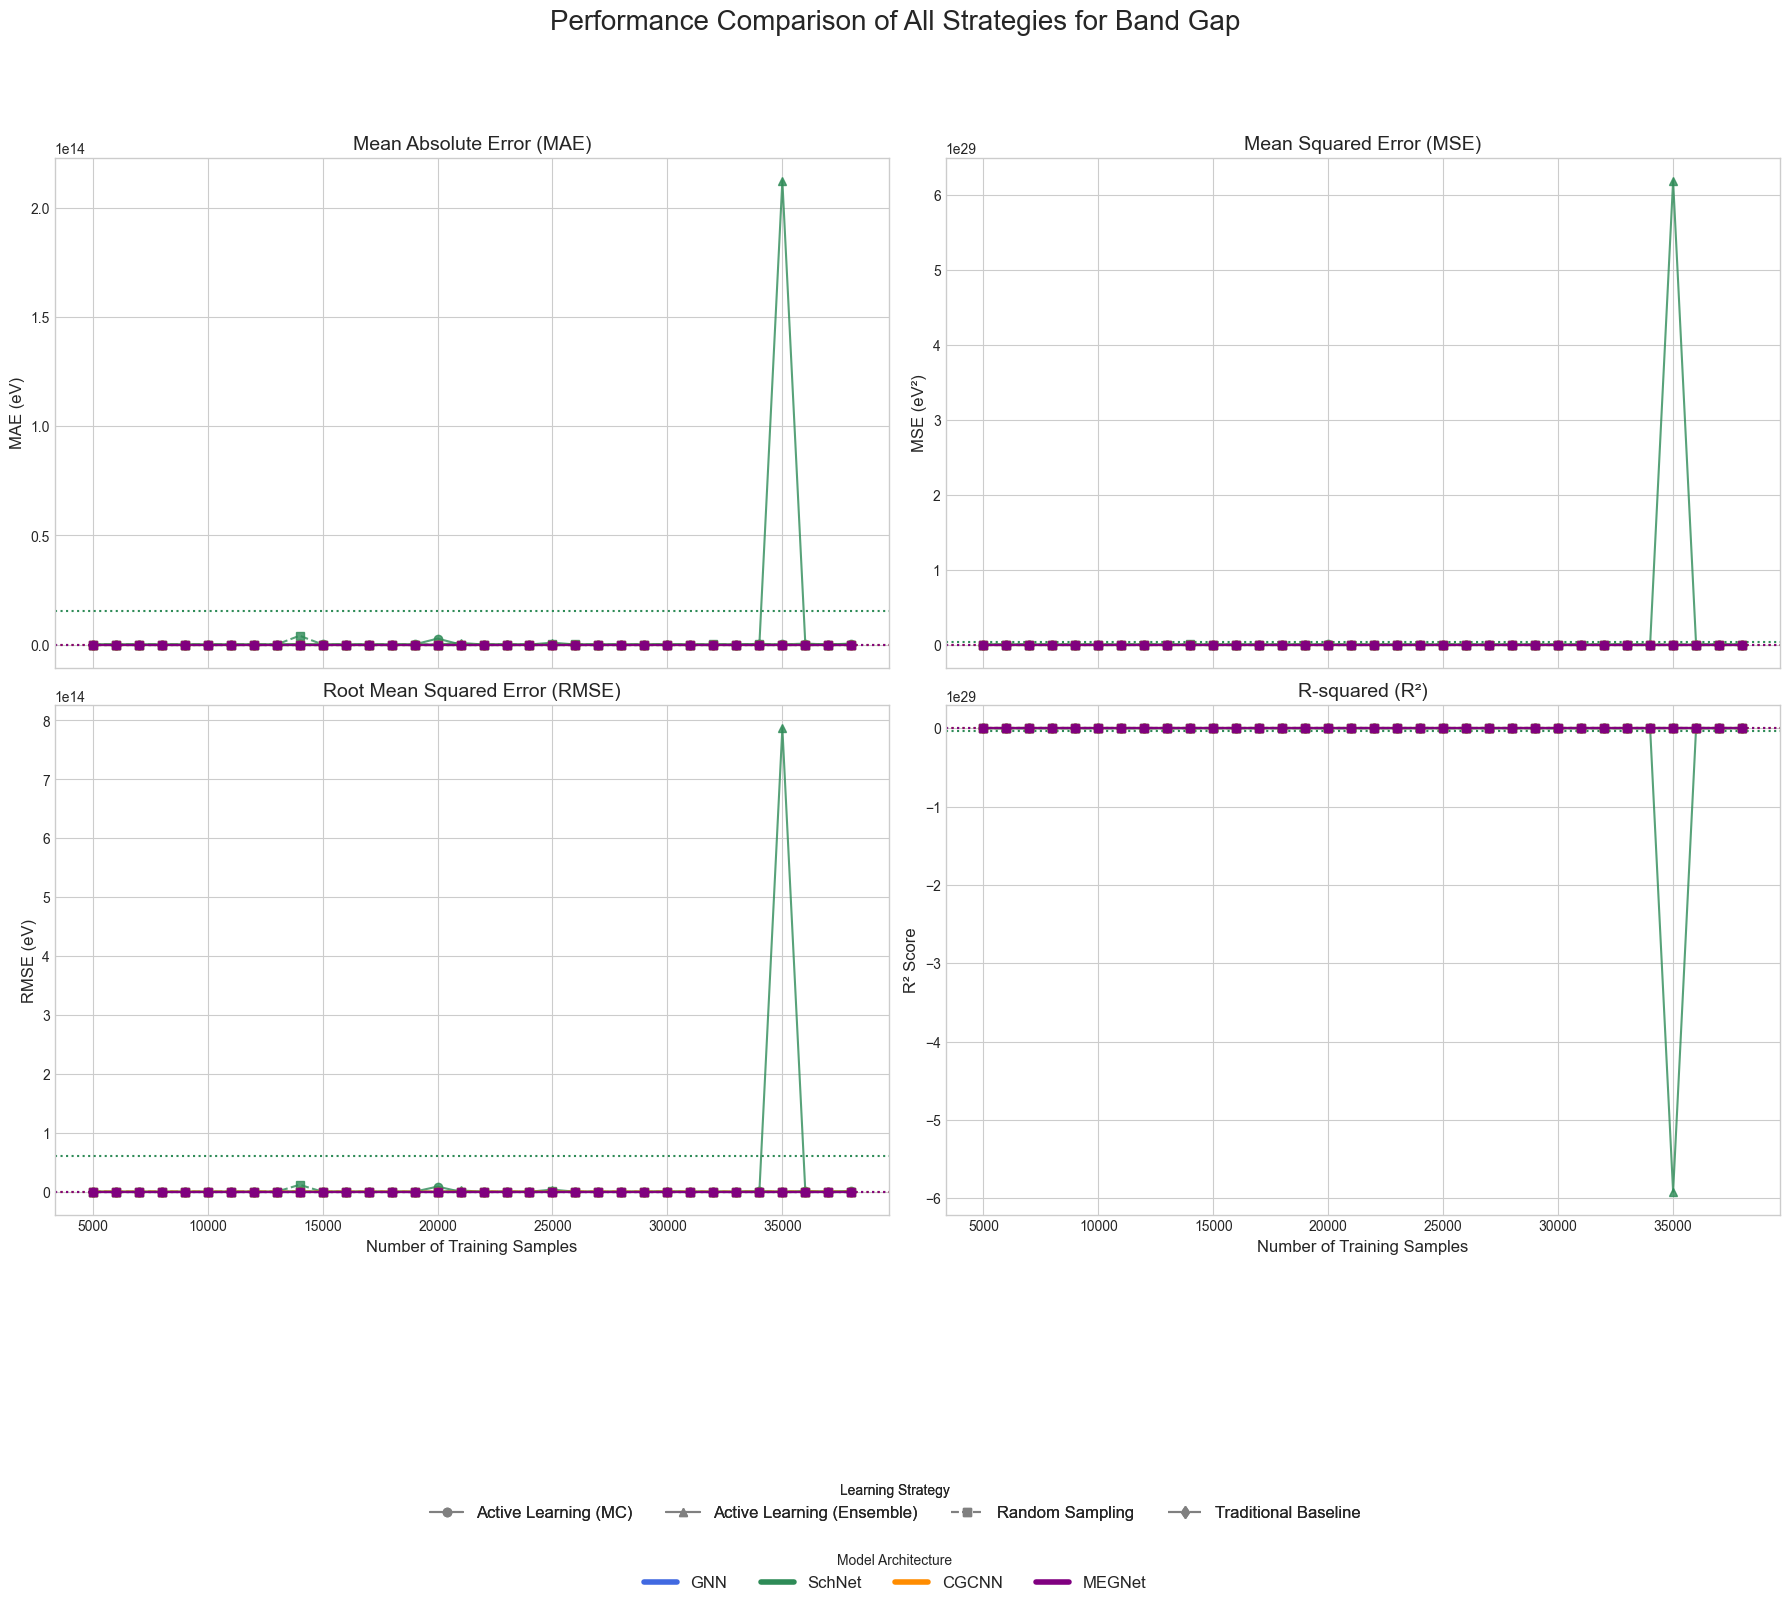

In [8]:
# --- 1. Load ALL saved histories, including the new Ensemble results ---
model_names = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
histories = {}
try:
    for model in model_names:
        # Active Learning - MC Dropout
        histories[f'active_mc_{model}'] = pd.read_csv(f'ActiveLearning/active_history_{model}_multi_target.csv')
        # Active Learning - Deep Ensemble (NEW)
        histories[f'active_ensemble_{model}'] = pd.read_csv(f'EnsembleActiveLearning/active_history_{model}_ensemble.csv')
        # Baselines
        histories[f'random_{model}'] = pd.read_csv(f'RandomSampling/random_history_{model}_multi_target.csv')
        histories[f'traditional_{model}'] = pd.read_csv(f'TraditionalLearning/traditional_history_{model}_multi_target.csv')
except FileNotFoundError as e:
    print(f"Error: {e}.")
    print("Please ensure ALL training scripts (MC Dropout, Ensemble, Random, Traditional) have been run.")
    exit()

# --- 2. Define the updated reusable plotting function ---
def create_comparison_plot(target_prefix, target_name, unit):
    """
    Generates a 2x2 comparison plot for a specific target property,
    including both MC Dropout and Deep Ensemble active learning strategies.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharex=True)
    axes = axes.flatten()

    metrics = ['mae', 'mse', 'rmse', 'r2']
    titles = ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R-squared (R²)']
    ylabels = [f'MAE ({unit})', f'MSE ({unit}²)', f'RMSE ({unit})', 'R² Score']

    colors = {'GNN': 'royalblue', 'SchNet': 'seagreen', 'CGCNN': 'darkorange', 'MEGNet': 'purple'}
    # CHANGED: Added a new style for the ensemble to differentiate it from MC Dropout
    linestyles = {
        'active_mc': 'o-',        # Circle markers for MC Dropout
        'active_ensemble': '^-',  # Triangle markers for Ensemble
        'random': 's--',          # Square markers for Random
        'traditional': 'd-.'      # Diamond markers for Traditional
    }

    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_col = f'{target_prefix}{metric}'

        for model in model_names:
            # Plot Active Learning (MC Dropout) curve
            ax.plot(histories[f'active_mc_{model}']['train_size'], histories[f'active_mc_{model}'][metric_col], 
                    linestyles['active_mc'], color=colors[model], label=f'Active (MC) - {model}', alpha=0.8)
            
            # Plot Active Learning (Deep Ensemble) curve (NEW)
            ax.plot(histories[f'active_ensemble_{model}']['train_size'], histories[f'active_ensemble_{model}'][metric_col], 
                    linestyles['active_ensemble'], color=colors[model], label=f'Active (Ensemble) - {model}', alpha=0.8)
            
            # Plot Random Sampling curve
            ax.plot(histories[f'random_{model}']['train_size'], histories[f'random_{model}'][metric_col], 
                    linestyles['random'], color=colors[model], label=f'Random - {model}', alpha=0.8)

            # Plot Traditional Learning as a horizontal line
            final_trad_metric = histories[f'traditional_{model}'][metric_col].iloc[-1]
            ax.axhline(y=final_trad_metric, color=colors[model], linestyle=':', 
                       label=f'Traditional - {model}')

        ax.set_ylabel(ylabels[i], fontsize=12)
        ax.set_title(titles[i], fontsize=14)
        if i >= 2:
            ax.set_xlabel('Number of Training Samples', fontsize=12)
        ax.grid(True)
        if metric == 'r2':
            ax.set_ylim(bottom=min(ax.get_ylim()[0], -0.1))

    # --- Updated legend to include all strategies ---
    strategy_labels = ['Active Learning (MC)', 'Active Learning (Ensemble)', 'Random Sampling', 'Traditional Baseline']
    strategy_handles = [plt.Line2D([0], [0], color='gray', linestyle=ls[1:], marker=ls[0]) for ls in linestyles.values()]
    model_labels = model_names
    model_handles = [plt.Line2D([0], [0], color=c, lw=4) for c in colors.values()]

    legend1 = fig.legend(strategy_handles, strategy_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.07), fontsize=12, title='Learning Strategy')
    legend2 = fig.legend(model_handles, model_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.12), fontsize=12, title='Model Architecture')
    fig.add_artist(legend1)

    # --- Final Touches ---
    fig.suptitle(f'Performance Comparison of All Strategies for {target_name}', fontsize=20, y=1.02)
    fig.tight_layout(rect=[0, 0.12, 1, 0.97]) # Adjust layout for the taller legend

    # --- Save and show the plot ---
    output_filename = f"Results/final_comparison_{target_prefix}all_strategies.png"
    if not os.path.exists("Results"):
        os.makedirs("Results")
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Comparison plot for {target_name} saved to '{output_filename}'")
    plt.show()

# --- 3. Generate the plots for each target ---
if __name__ == '__main__':
    # Plot for Formation Energy
    create_comparison_plot(
        target_prefix='fe_',
        target_name='Formation Energy',
        unit='eV/atom'
    )
    
    # Plot for Band Gap
    create_comparison_plot(
        target_prefix='bg_',
        target_name='Band Gap',
        unit='eV'
    )


--- Generating plots for model: GNN ---
Saved: Results/comparison_GNN_fe_all_strategies.png


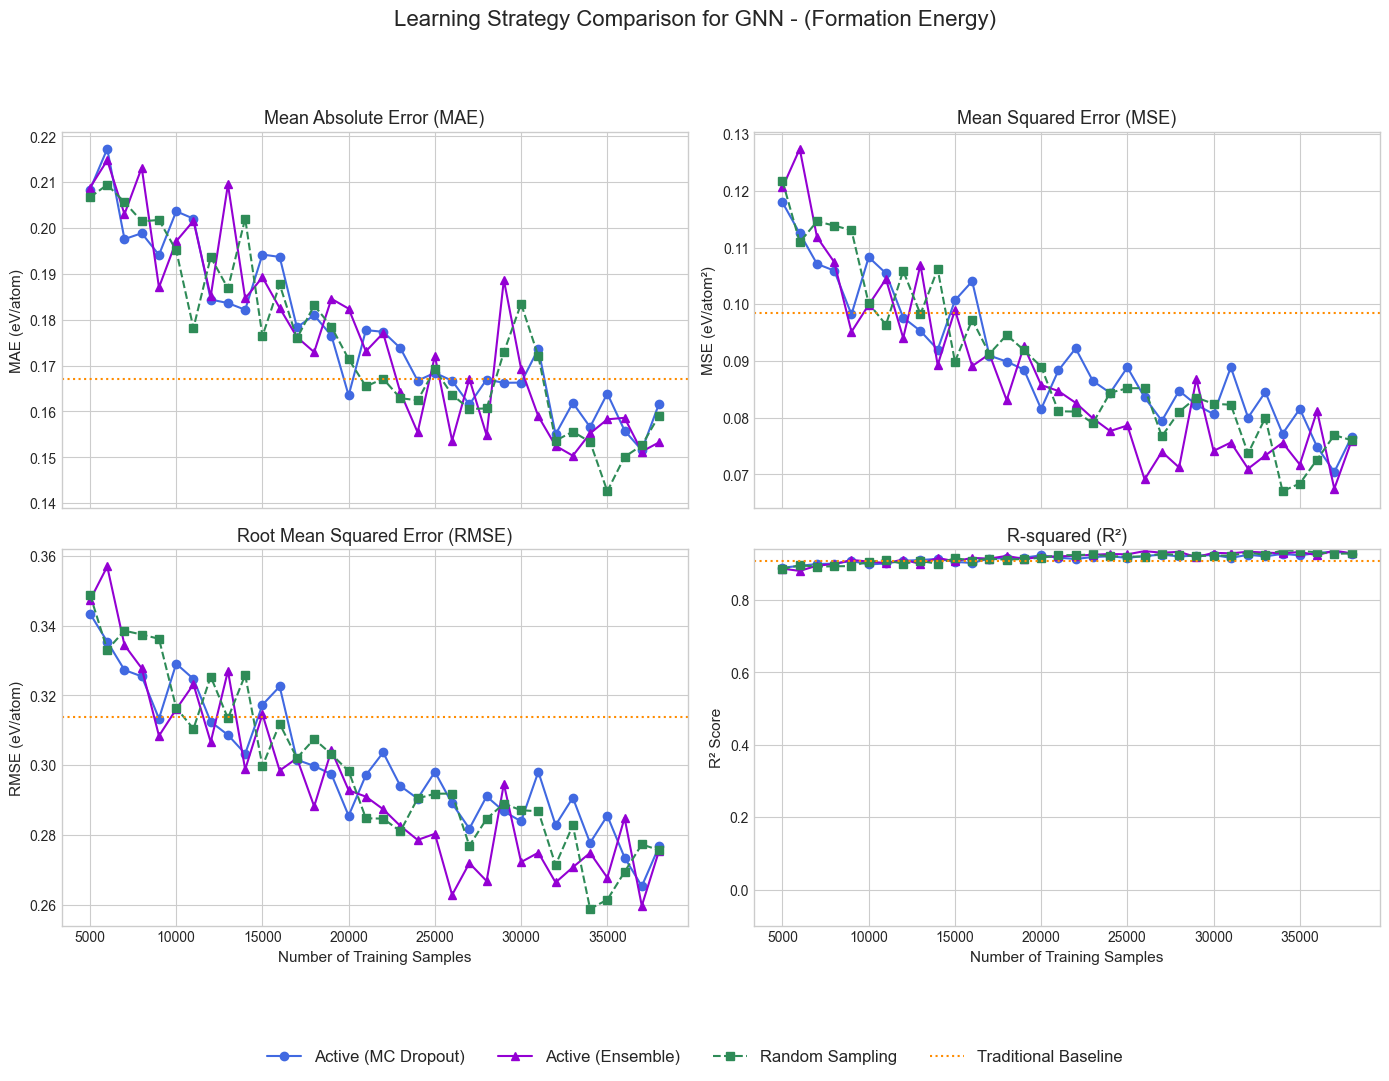

Saved: Results/comparison_GNN_bg_all_strategies.png


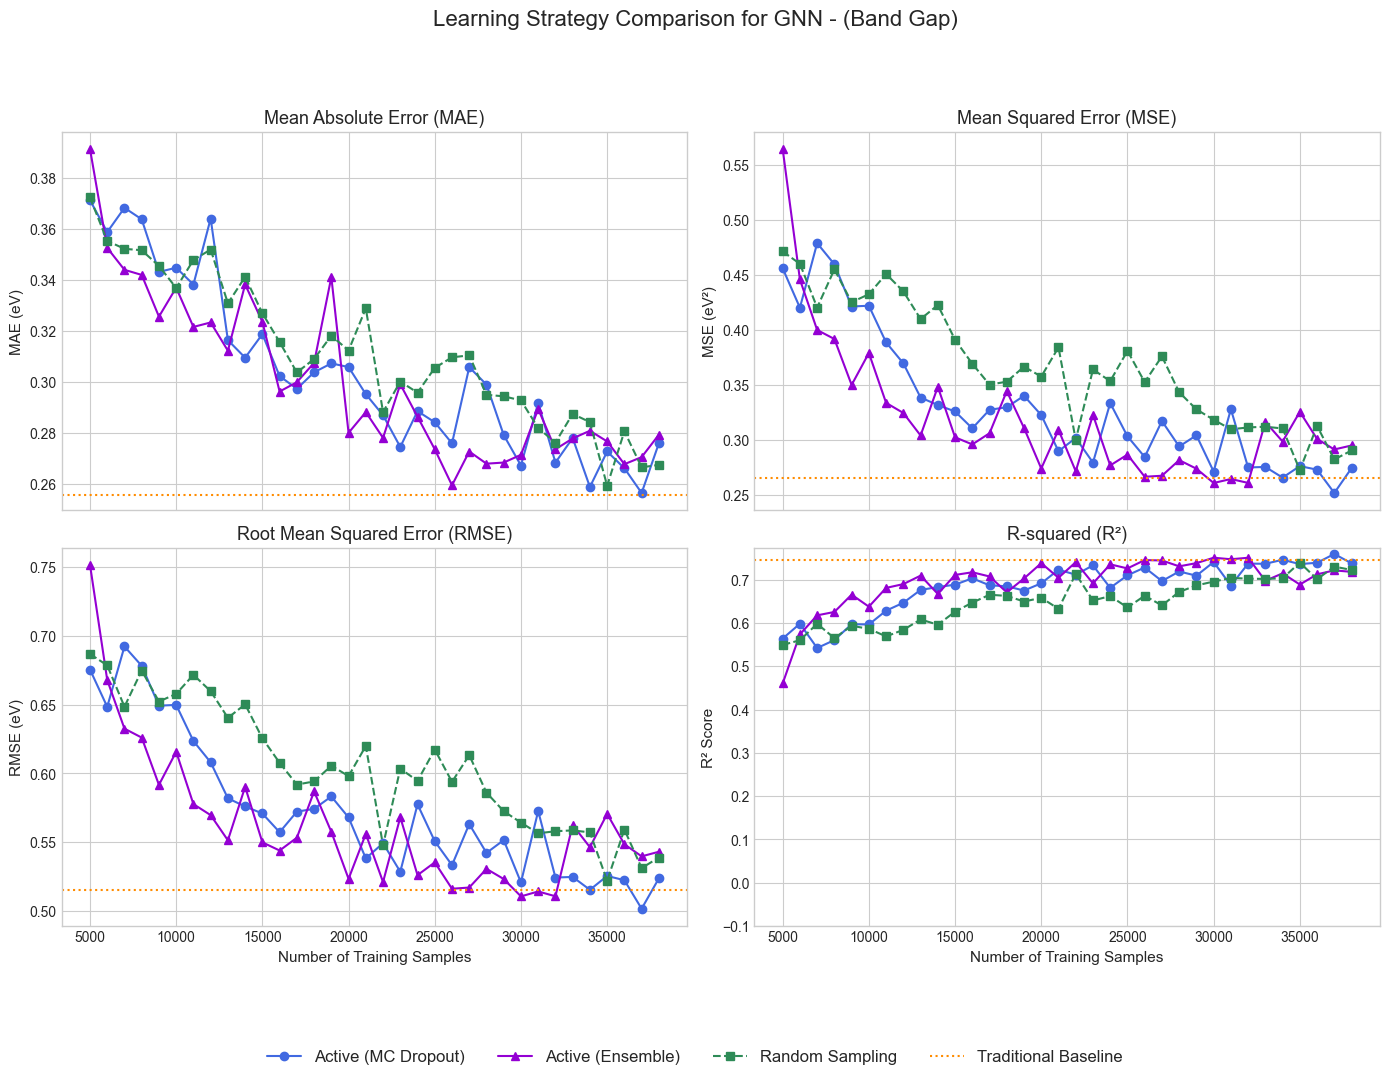


--- Generating plots for model: SchNet ---
Saved: Results/comparison_SchNet_fe_all_strategies.png


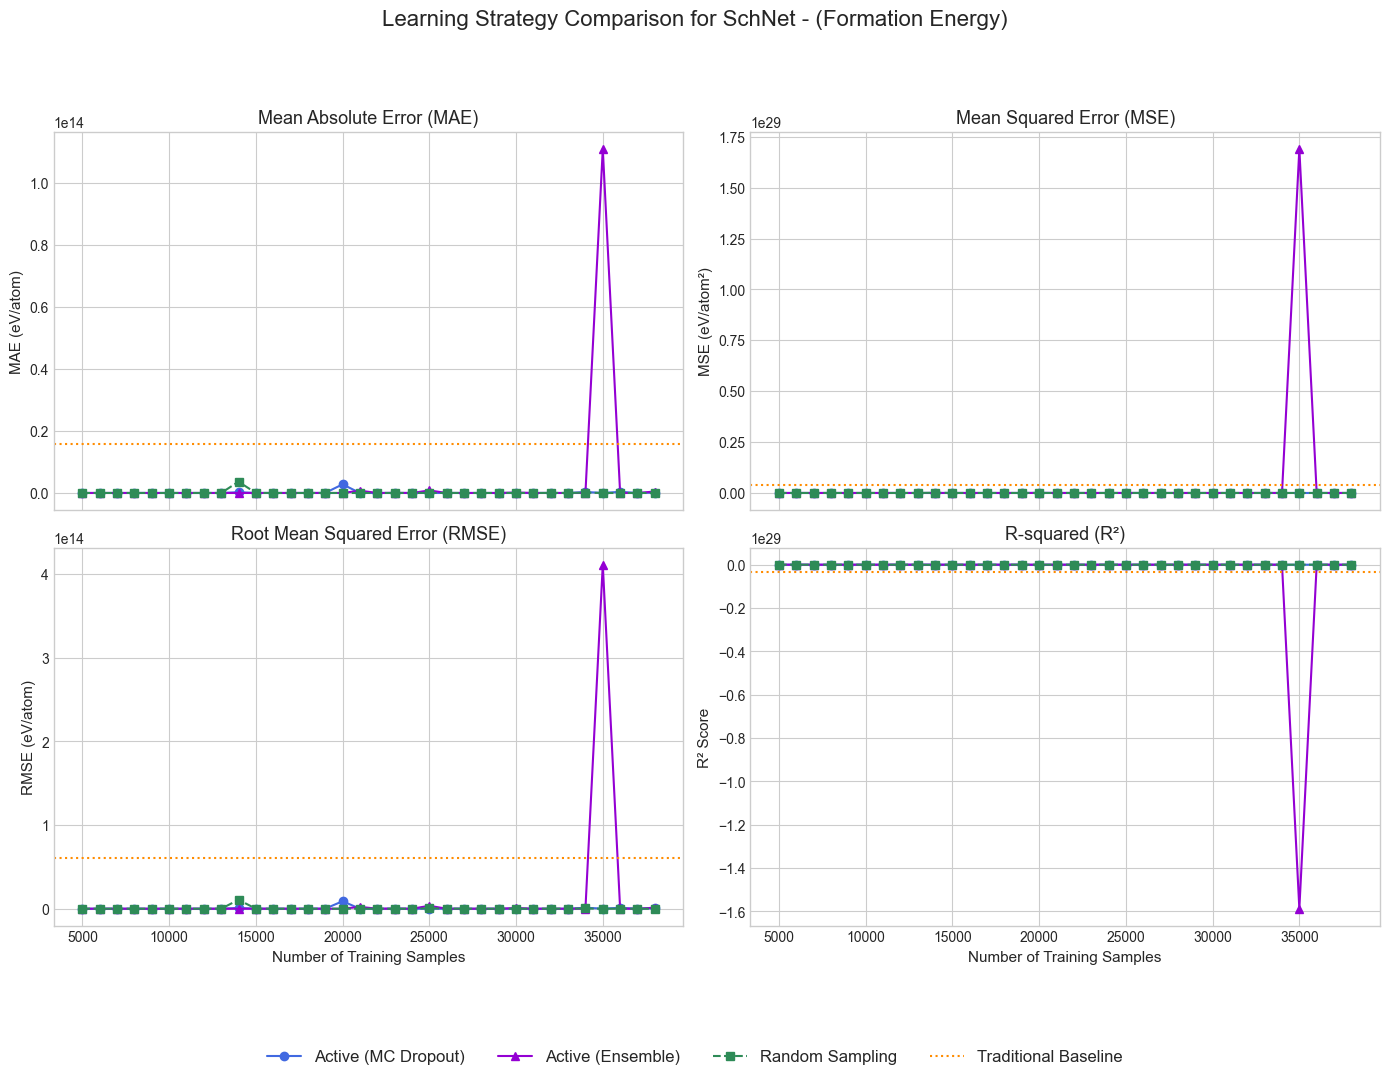

Saved: Results/comparison_SchNet_bg_all_strategies.png


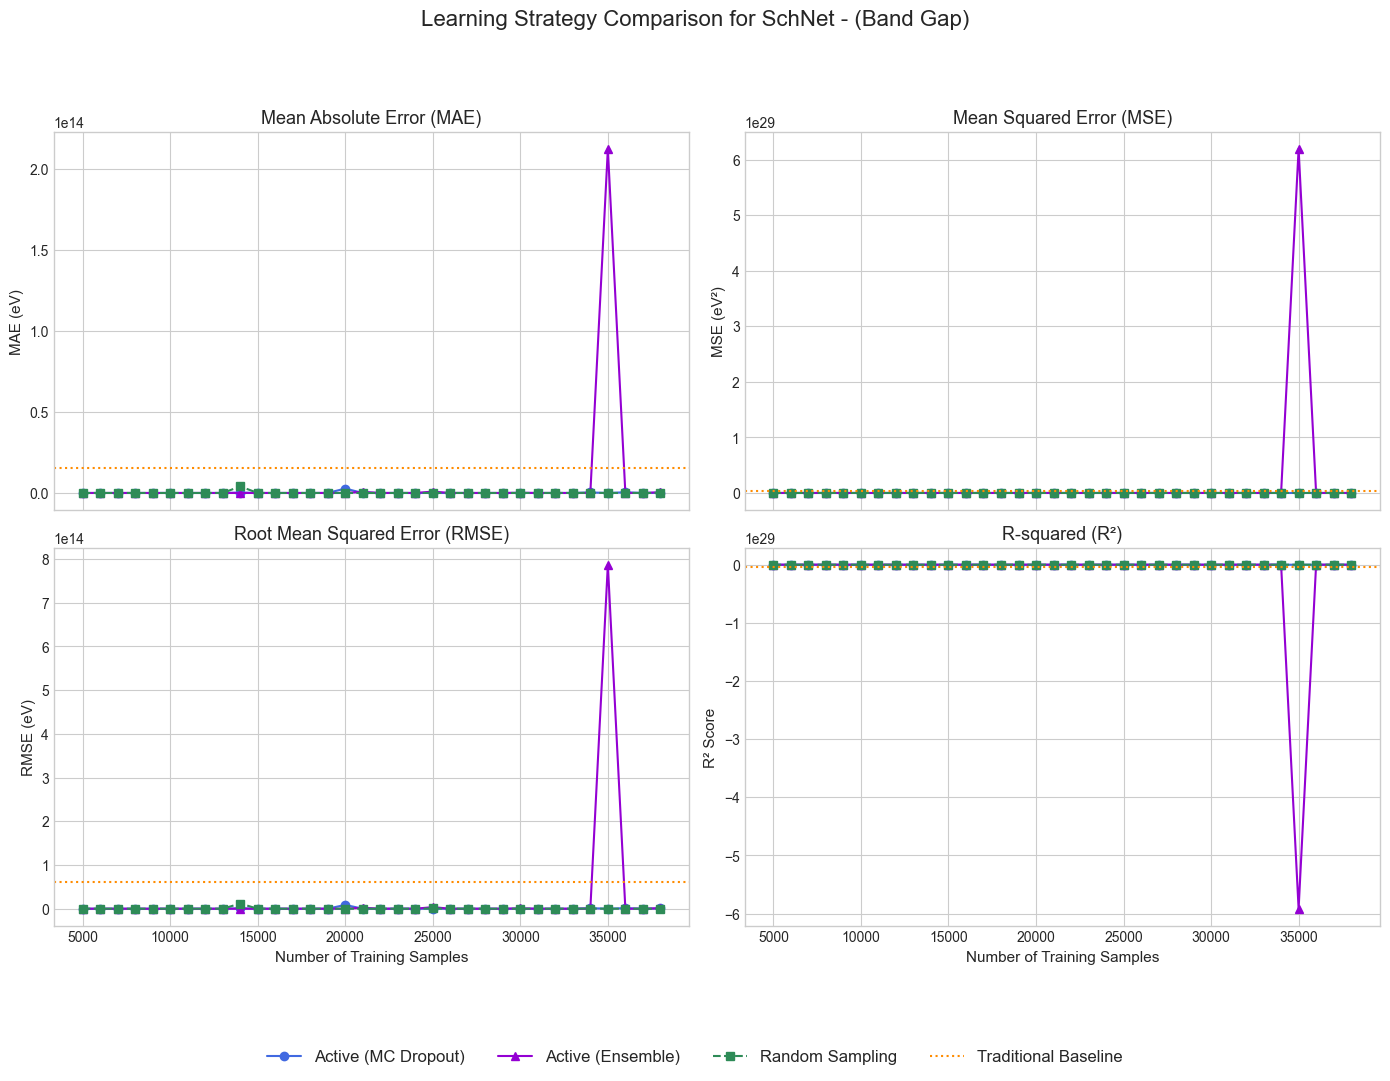


--- Generating plots for model: CGCNN ---
Saved: Results/comparison_CGCNN_fe_all_strategies.png


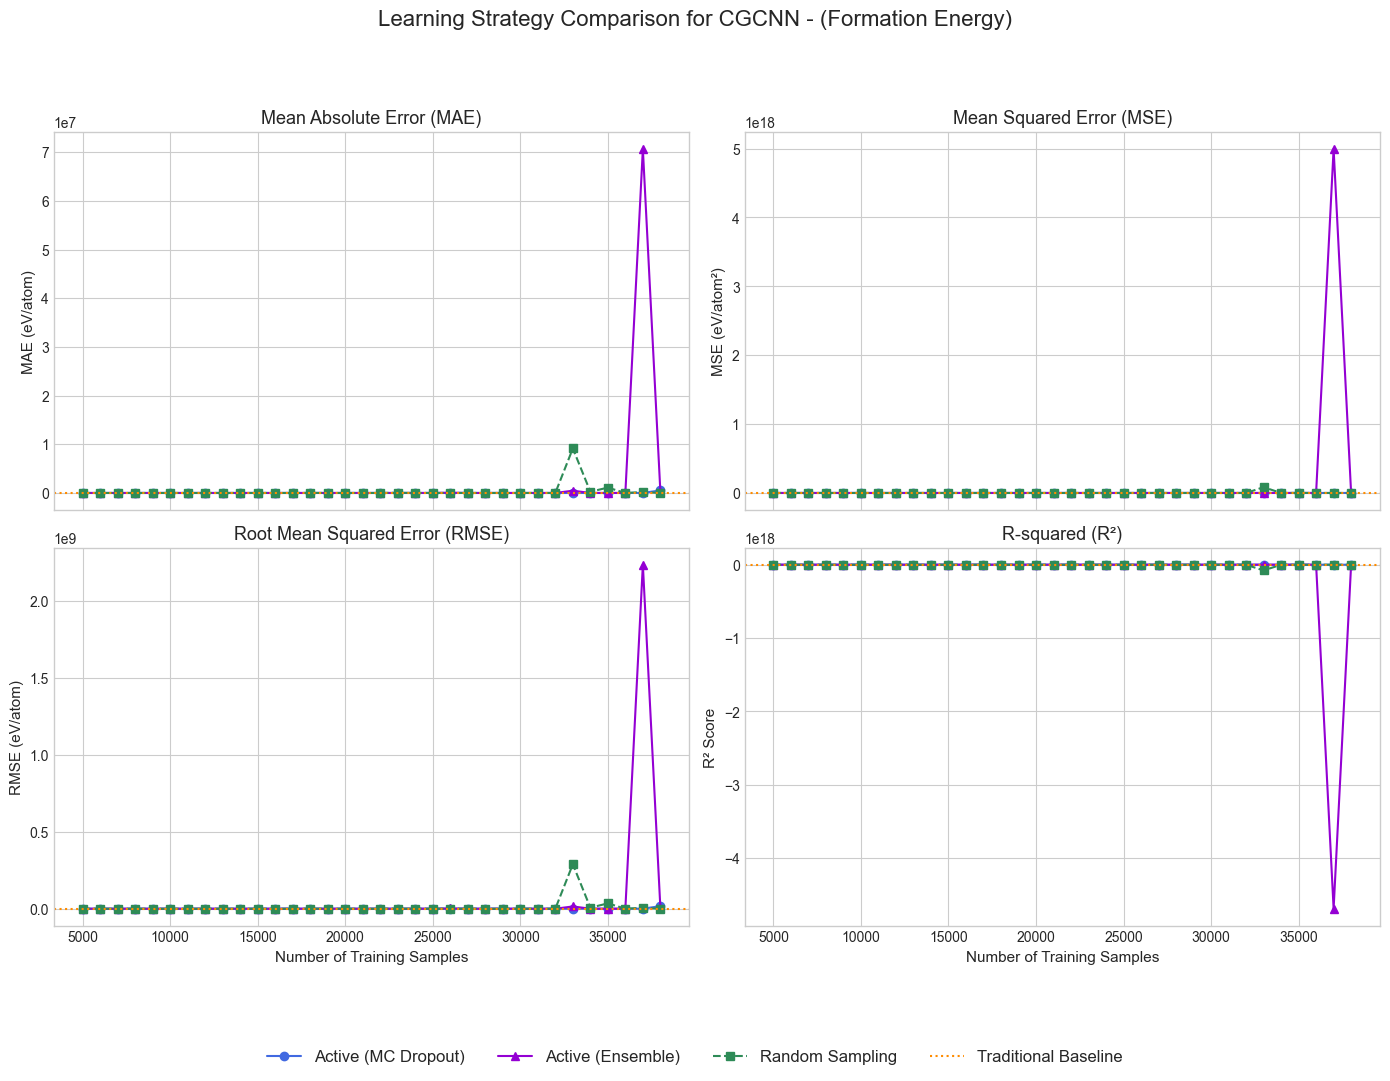

Saved: Results/comparison_CGCNN_bg_all_strategies.png


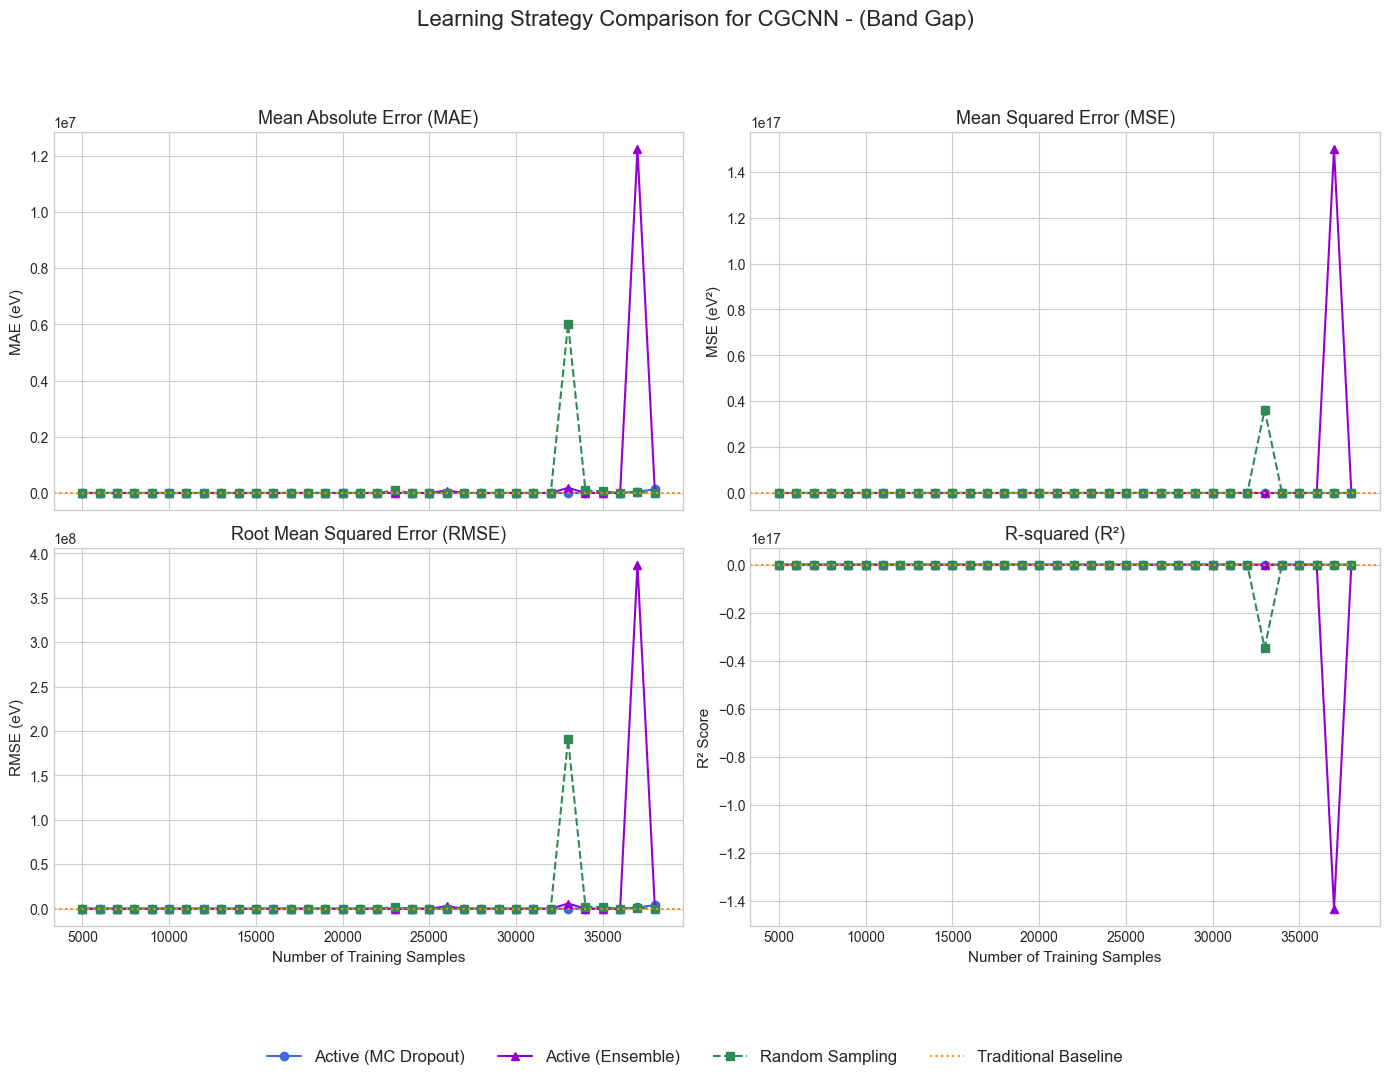


--- Generating plots for model: MEGNet ---
Saved: Results/comparison_MEGNet_fe_all_strategies.png


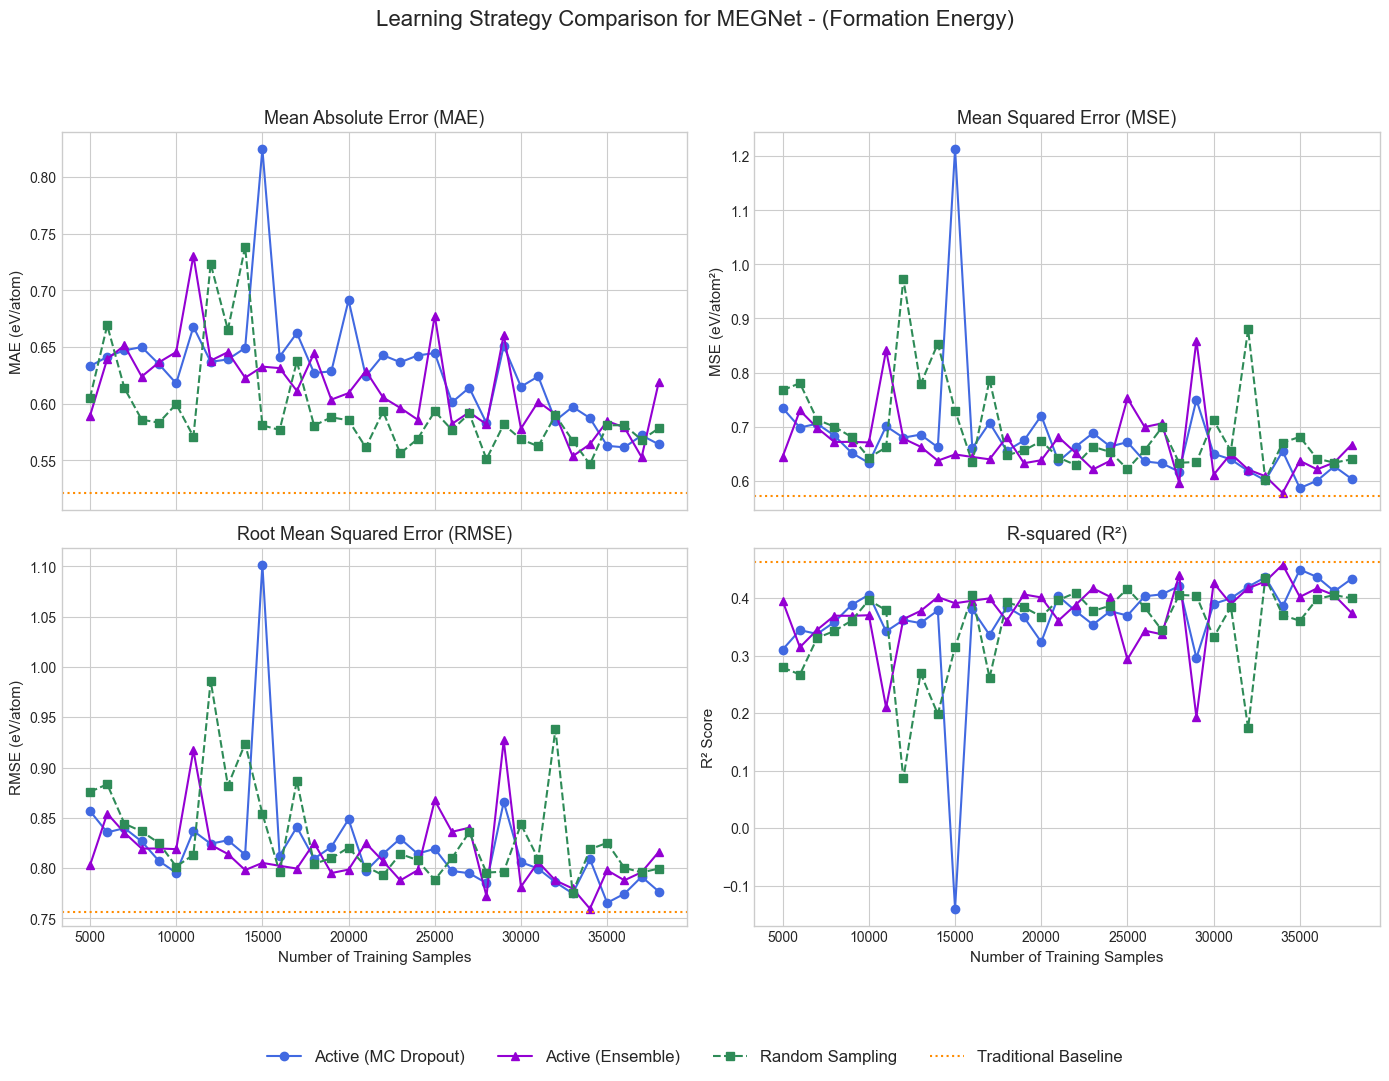

Saved: Results/comparison_MEGNet_bg_all_strategies.png


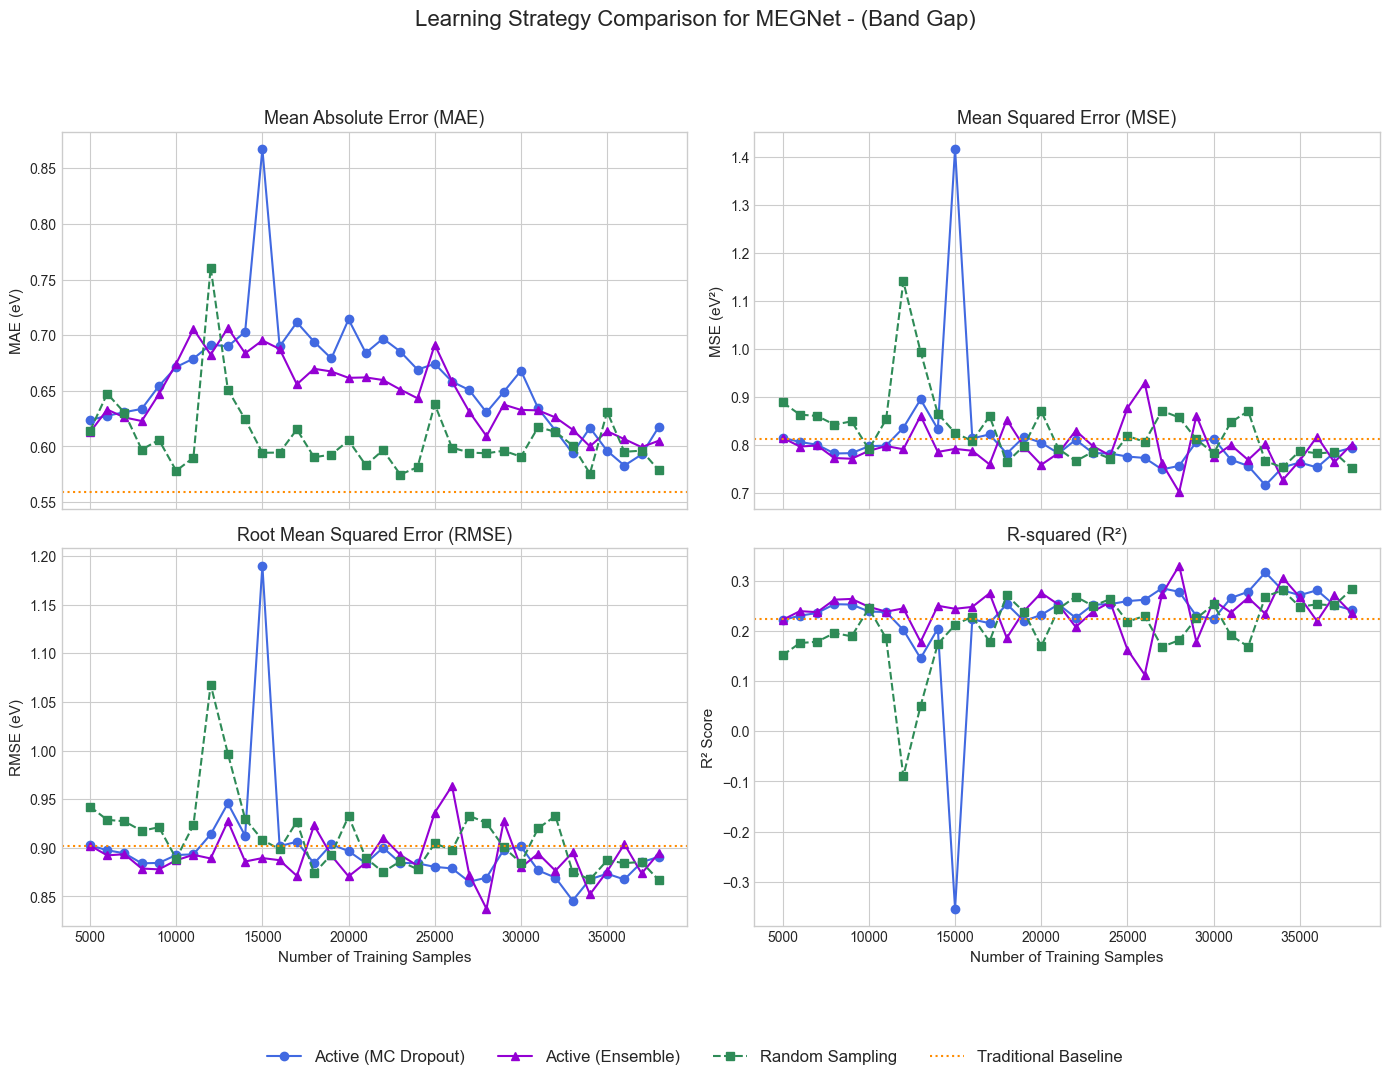

In [9]:
# --- 1. Load ALL saved histories, including the new Ensemble results ---
model_names = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
histories = {}
try:
    for model in model_names:
        # Active Learning - MC Dropout
        histories[f'active_mc_{model}'] = pd.read_csv(f'ActiveLearning/active_history_{model}_multi_target.csv')
        # Active Learning - Deep Ensemble (NEW)
        histories[f'active_ensemble_{model}'] = pd.read_csv(f'EnsembleActiveLearning/active_history_{model}_ensemble.csv')
        # Baselines
        histories[f'random_{model}'] = pd.read_csv(f'RandomSampling/random_history_{model}_multi_target.csv')
        histories[f'traditional_{model}'] = pd.read_csv(f'TraditionalLearning/traditional_history_{model}_multi_target.csv')
except FileNotFoundError as e:
    print(f"Error: {e}.")
    print("Please ensure ALL training scripts (MC Dropout, Ensemble, Random, Traditional) have been run.")
    exit()

# --- 2. Define the updated reusable plotting function ---
def create_model_comparison_plot(model_name, target_prefix, target_name, unit):
    """
    Generates a 2x2 comparison plot for a single model, showing all four learning strategies.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()

    metrics = ['mae', 'mse', 'rmse', 'r2']
    titles = ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 
              'Root Mean Squared Error (RMSE)', 'R-squared (R²)']
    ylabels = [f'MAE ({unit})', f'MSE ({unit}²)', f'RMSE ({unit})', 'R² Score']

    # CHANGED: Colors and styles for four strategies
    colors = {
        'active_mc': 'royalblue', 
        'active_ensemble': 'darkviolet',
        'random': 'seagreen', 
        'traditional': 'darkorange'
    }
    linestyles = {
        'active_mc': 'o-', 
        'active_ensemble': '^-',
        'random': 's--'
    }
    labels = {
        'active_mc': 'Active (MC Dropout)',
        'active_ensemble': 'Active (Ensemble)',
        'random': 'Random Sampling',
        'traditional': 'Traditional Baseline'
    }


    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_col = f'{target_prefix}{metric}'

        # Active Learning (MC Dropout) curve
        ax.plot(histories[f'active_mc_{model_name}']['train_size'], 
                histories[f'active_mc_{model_name}'][metric_col], 
                linestyles['active_mc'], color=colors['active_mc'], 
                label=labels['active_mc'])
        
        # Active Learning (Deep Ensemble) curve (NEW)
        ax.plot(histories[f'active_ensemble_{model_name}']['train_size'], 
                histories[f'active_ensemble_{model_name}'][metric_col], 
                linestyles['active_ensemble'], color=colors['active_ensemble'], 
                label=labels['active_ensemble'])
        
        # Random Sampling curve
        ax.plot(histories[f'random_{model_name}']['train_size'], 
                histories[f'random_{model_name}'][metric_col], 
                linestyles['random'], color=colors['random'], 
                label=labels['random'])

        # Traditional baseline
        final_trad_metric = histories[f'traditional_{model_name}'][metric_col].iloc[-1]
        ax.axhline(y=final_trad_metric, color=colors['traditional'], linestyle=':', 
                   label=labels['traditional'])

        ax.set_ylabel(ylabels[i], fontsize=11)
        ax.set_title(titles[i], fontsize=13)
        if i >= 2:
            ax.set_xlabel('Number of Training Samples', fontsize=11)
        ax.grid(True)
        if metric == 'r2':
            ax.set_ylim(bottom=min(ax.get_ylim()[0], -0.1))

    # Shared legend (updated for 4 items)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize=12)
    
    # Main title
    fig.suptitle(f'Learning Strategy Comparison for {model_name} - ({target_name})', fontsize=16, y=1.02)
    fig.tight_layout(rect=[0, 0.05, 1, 0.97])

    # Save each figure separately with a new name
    output_filename = f"Results/comparison_{model_name}_{target_prefix}all_strategies.png"
    if not os.path.exists("Results"):
        os.makedirs("Results")
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {output_filename}")
    plt.show()

# --- 3. Generate the plots for each model and each target ---
if __name__ == '__main__':
    for model in model_names:
        print(f"\n--- Generating plots for model: {model} ---")
        
        # Plot for Formation Energy
        create_model_comparison_plot(
            model_name=model,
            target_prefix='fe_',
            target_name='Formation Energy',
            unit='eV/atom'
        )
        
        # Plot for Band Gap
        create_model_comparison_plot(
            model_name=model,
            target_prefix='bg_',
            target_name='Band Gap',
            unit='eV'
        )


## <span style="font-family: 'Courier New'; color: #ffffffff;">Analysis of Queried Materials</span>

Loading datasets...
Analysis based on 34000 unique actively queried samples.


C:\Users\saich\AppData\Local\Temp\ipykernel_26636\2466617285.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_combined, x='Method', y=prop, ax=ax, palette=palette, cut=0, order=method_order)
C:\Users\saich\AppData\Local\Temp\ipykernel_26636\2466617285.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_combined, x='Method', y=prop, ax=ax, palette=palette, cut=0, order=method_order)
C:\Users\saich\AppData\Local\Temp\ipykernel_26636\2466617285.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_combined, 


Query analysis plot saved to 'Results/query_analysis_properties_all_16_methods.png'


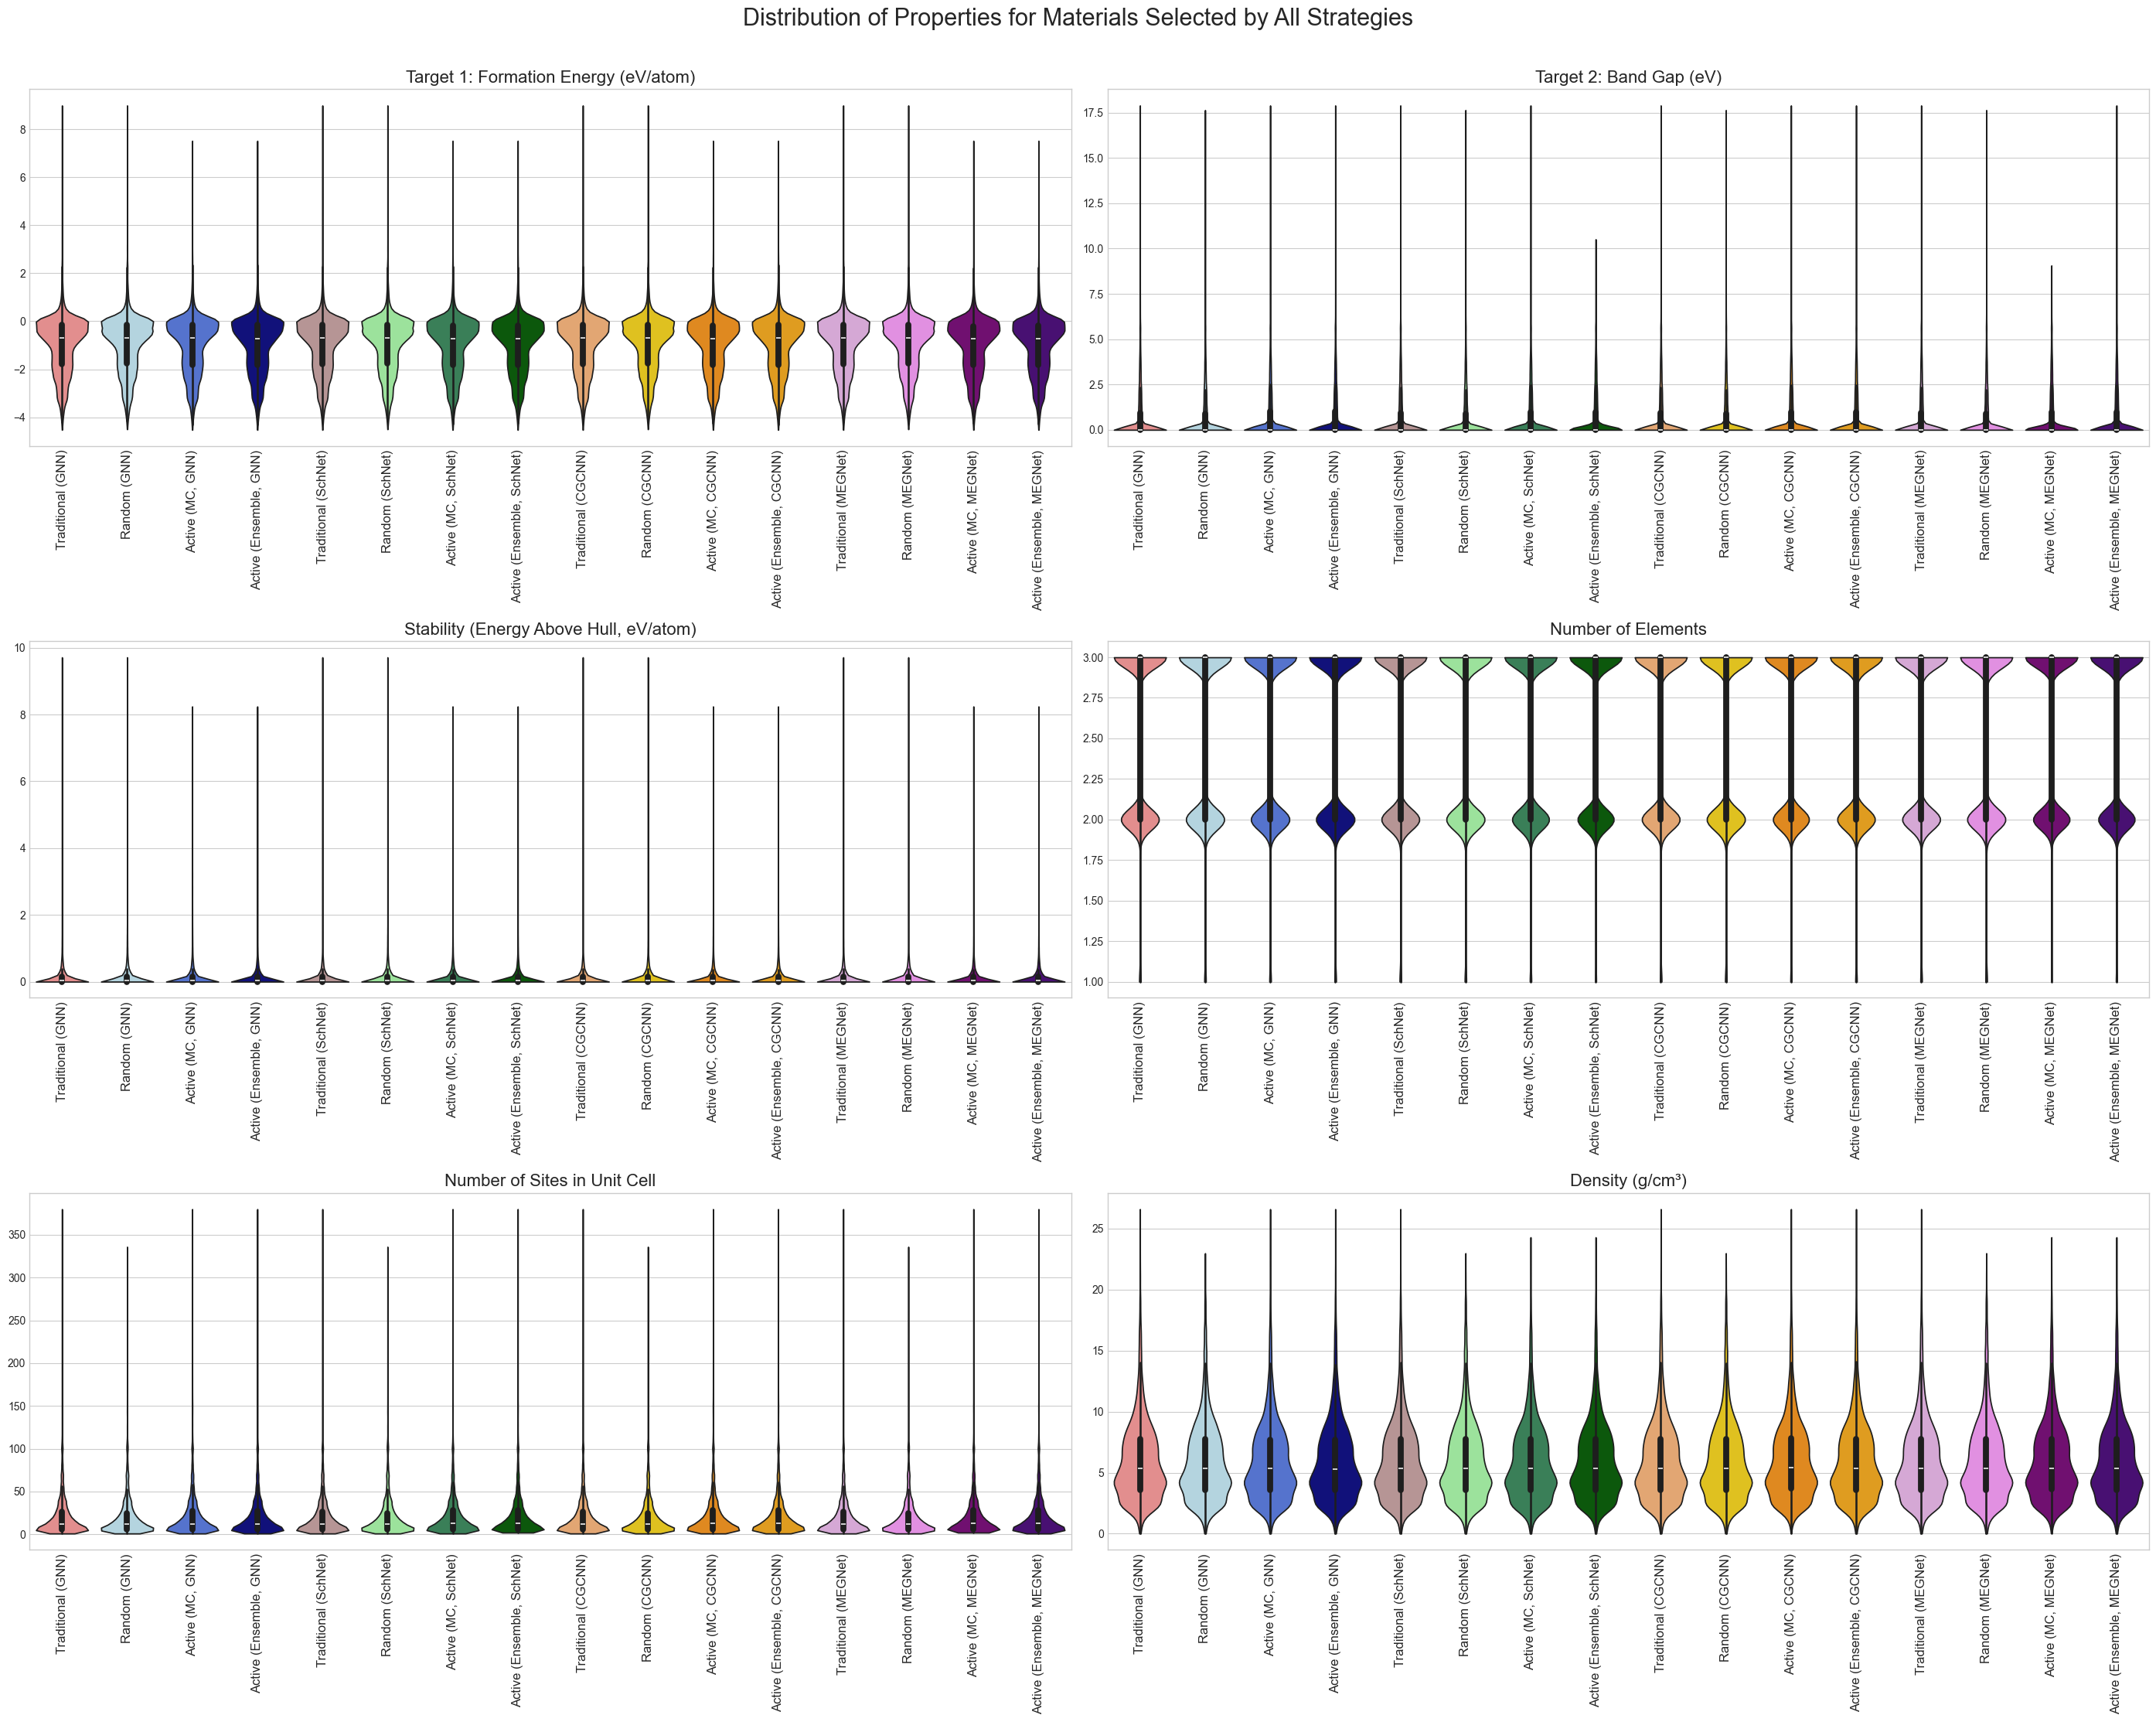

In [14]:

def analyze_queried_materials():
    """
    Compares properties of materials from all four strategies:
    Active (MC), Active (Ensemble), Random, and Traditional.
    """
    print("Loading datasets...")
    try:
        
        df_full = pd.read_csv(csv_path)

        model_names = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
        # Load IDs from BOTH active learning strategies
        active_mc_dfs = {model: pd.read_csv(f"ActiveLearning/active_queried_ids_{model}_multi_target.csv") 
                         for model in model_names}
        active_ensemble_dfs = {model: pd.read_csv(f"EnsembleActiveLearning/active_queried_ids_{model}_ensemble.csv") 
                               for model in model_names}
    except FileNotFoundError as e:
        print(f"Error: {e}. Make sure all required queried ID files are present.")
        return

    combined_dfs = []
    
    # 1. Get properties for materials chosen by BOTH active learners
    for model in model_names:
        # MC Dropout Queried Materials
        df_active_mc = df_full[df_full['material_id'].isin(active_mc_dfs[model]['material_id'])].copy()
        df_active_mc['Method'] = f'Active (MC, {model})'
        combined_dfs.append(df_active_mc)

        # Deep Ensemble Queried Materials
        df_active_ensemble = df_full[df_full['material_id'].isin(active_ensemble_dfs[model]['material_id'])].copy()
        df_active_ensemble['Method'] = f'Active (Ensemble, {model})'
        combined_dfs.append(df_active_ensemble)

    # Recreate the exact same test/pool split
    all_indices = list(range(len(df_full)))
    random.seed(42)
    random.shuffle(all_indices)
    test_set_size = 10000
    pool_indices = all_indices[test_set_size:]
    
    # 2. Get properties for Random and Traditional sets
    # We only need one unqueried pool for random sampling
    all_active_ids = set().union(*(df['material_id'] for df in active_mc_dfs.values()), 
                                 *(df['material_id'] for df in active_ensemble_dfs.values()))
    unqueried_pool_df = df_full.iloc[pool_indices][~df_full.iloc[pool_indices]['material_id'].isin(all_active_ids)]

    final_train_size = INITIAL_SIZE + QUERY_SIZE * NUM_CYCLES
    traditional_indices = pool_indices[:final_train_size]

    for model in model_names:
        # Create a random set of the same size as the MC active set
        df_random_chosen = unqueried_pool_df.sample(n=len(active_mc_dfs[model]), random_state=42, replace=True).copy()
        df_random_chosen['Method'] = f'Random ({model})'
        combined_dfs.append(df_random_chosen)
        
        # Create a labeled Traditional set for EACH model
        df_traditional_chosen = df_full.iloc[traditional_indices].copy()
        df_traditional_chosen['Method'] = f'Traditional ({model})'
        combined_dfs.append(df_traditional_chosen)

    # Final concatenation
    df_combined = pd.concat(combined_dfs, ignore_index=True)
    print(f"Analysis based on {len(all_active_ids)} unique actively queried samples.")

    # --- Plotting ---
    properties_to_compare = {
        'formation_energy_per_atom': 'Target 1: Formation Energy (eV/atom)',
        'band_gap': 'Target 2: Band Gap (eV)',
        'energy_above_hull': 'Stability (Energy Above Hull, eV/atom)',
        'nelements': 'Number of Elements',
        'nsites': 'Number of Sites in Unit Cell',
        'density': 'Density (g/cm³)'
    }

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 2, figsize=(28, 22)) # Made the figure wider
    axes = axes.flatten()

    # --- Updated palette and order to include all 16 methods ---
    palette = {
        'Traditional (GNN)': 'lightcoral', 'Random (GNN)': 'lightblue', 'Active (MC, GNN)': 'royalblue', 'Active (Ensemble, GNN)': 'darkblue',
        'Traditional (SchNet)': 'rosybrown', 'Random (SchNet)': 'lightgreen', 'Active (MC, SchNet)': 'seagreen', 'Active (Ensemble, SchNet)': 'darkgreen',
        'Traditional (CGCNN)': 'sandybrown', 'Random (CGCNN)': 'gold', 'Active (MC, CGCNN)': 'darkorange', 'Active (Ensemble, CGCNN)': 'orange',
        'Traditional (MEGNet)': 'plum', 'Random (MEGNet)': 'violet', 'Active (MC, MEGNet)': 'purple', 'Active (Ensemble, MEGNet)': 'indigo',
    }
    method_order = [
        'Traditional (GNN)', 'Random (GNN)', 'Active (MC, GNN)', 'Active (Ensemble, GNN)',
        'Traditional (SchNet)', 'Random (SchNet)', 'Active (MC, SchNet)', 'Active (Ensemble, SchNet)',
        'Traditional (CGCNN)', 'Random (CGCNN)', 'Active (MC, CGCNN)', 'Active (Ensemble, CGCNN)',
        'Traditional (MEGNet)', 'Random (MEGNet)', 'Active (MC, MEGNet)', 'Active (Ensemble, MEGNet)'
    ]

    for i, (prop, title) in enumerate(properties_to_compare.items()):
        ax = axes[i]
        sns.violinplot(data=df_combined, x='Method', y=prop, ax=ax, palette=palette, cut=0, order=method_order)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelrotation=90, labelsize=12)

    fig.suptitle('Distribution of Properties for Materials Selected by All Strategies', fontsize=22, y=1.01)
    fig.tight_layout()

    output_filename = "Results/query_analysis_properties_all_16_methods.png"
    if not os.path.exists("Results"):
        os.makedirs("Results")
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nQuery analysis plot saved to '{output_filename}'")
    plt.show()

if __name__ == '__main__':
    analyze_queried_materials()


## <span style="font-family: 'Courier New'; color: #ffffffff;">Parity Plots and Predictions</span>


--- Generating Parity Plots for Formation Energy ---
All parity plots for Formation Energy saved to 'Results/parity_plots_all_models_all_strategies_formation_energy.png'


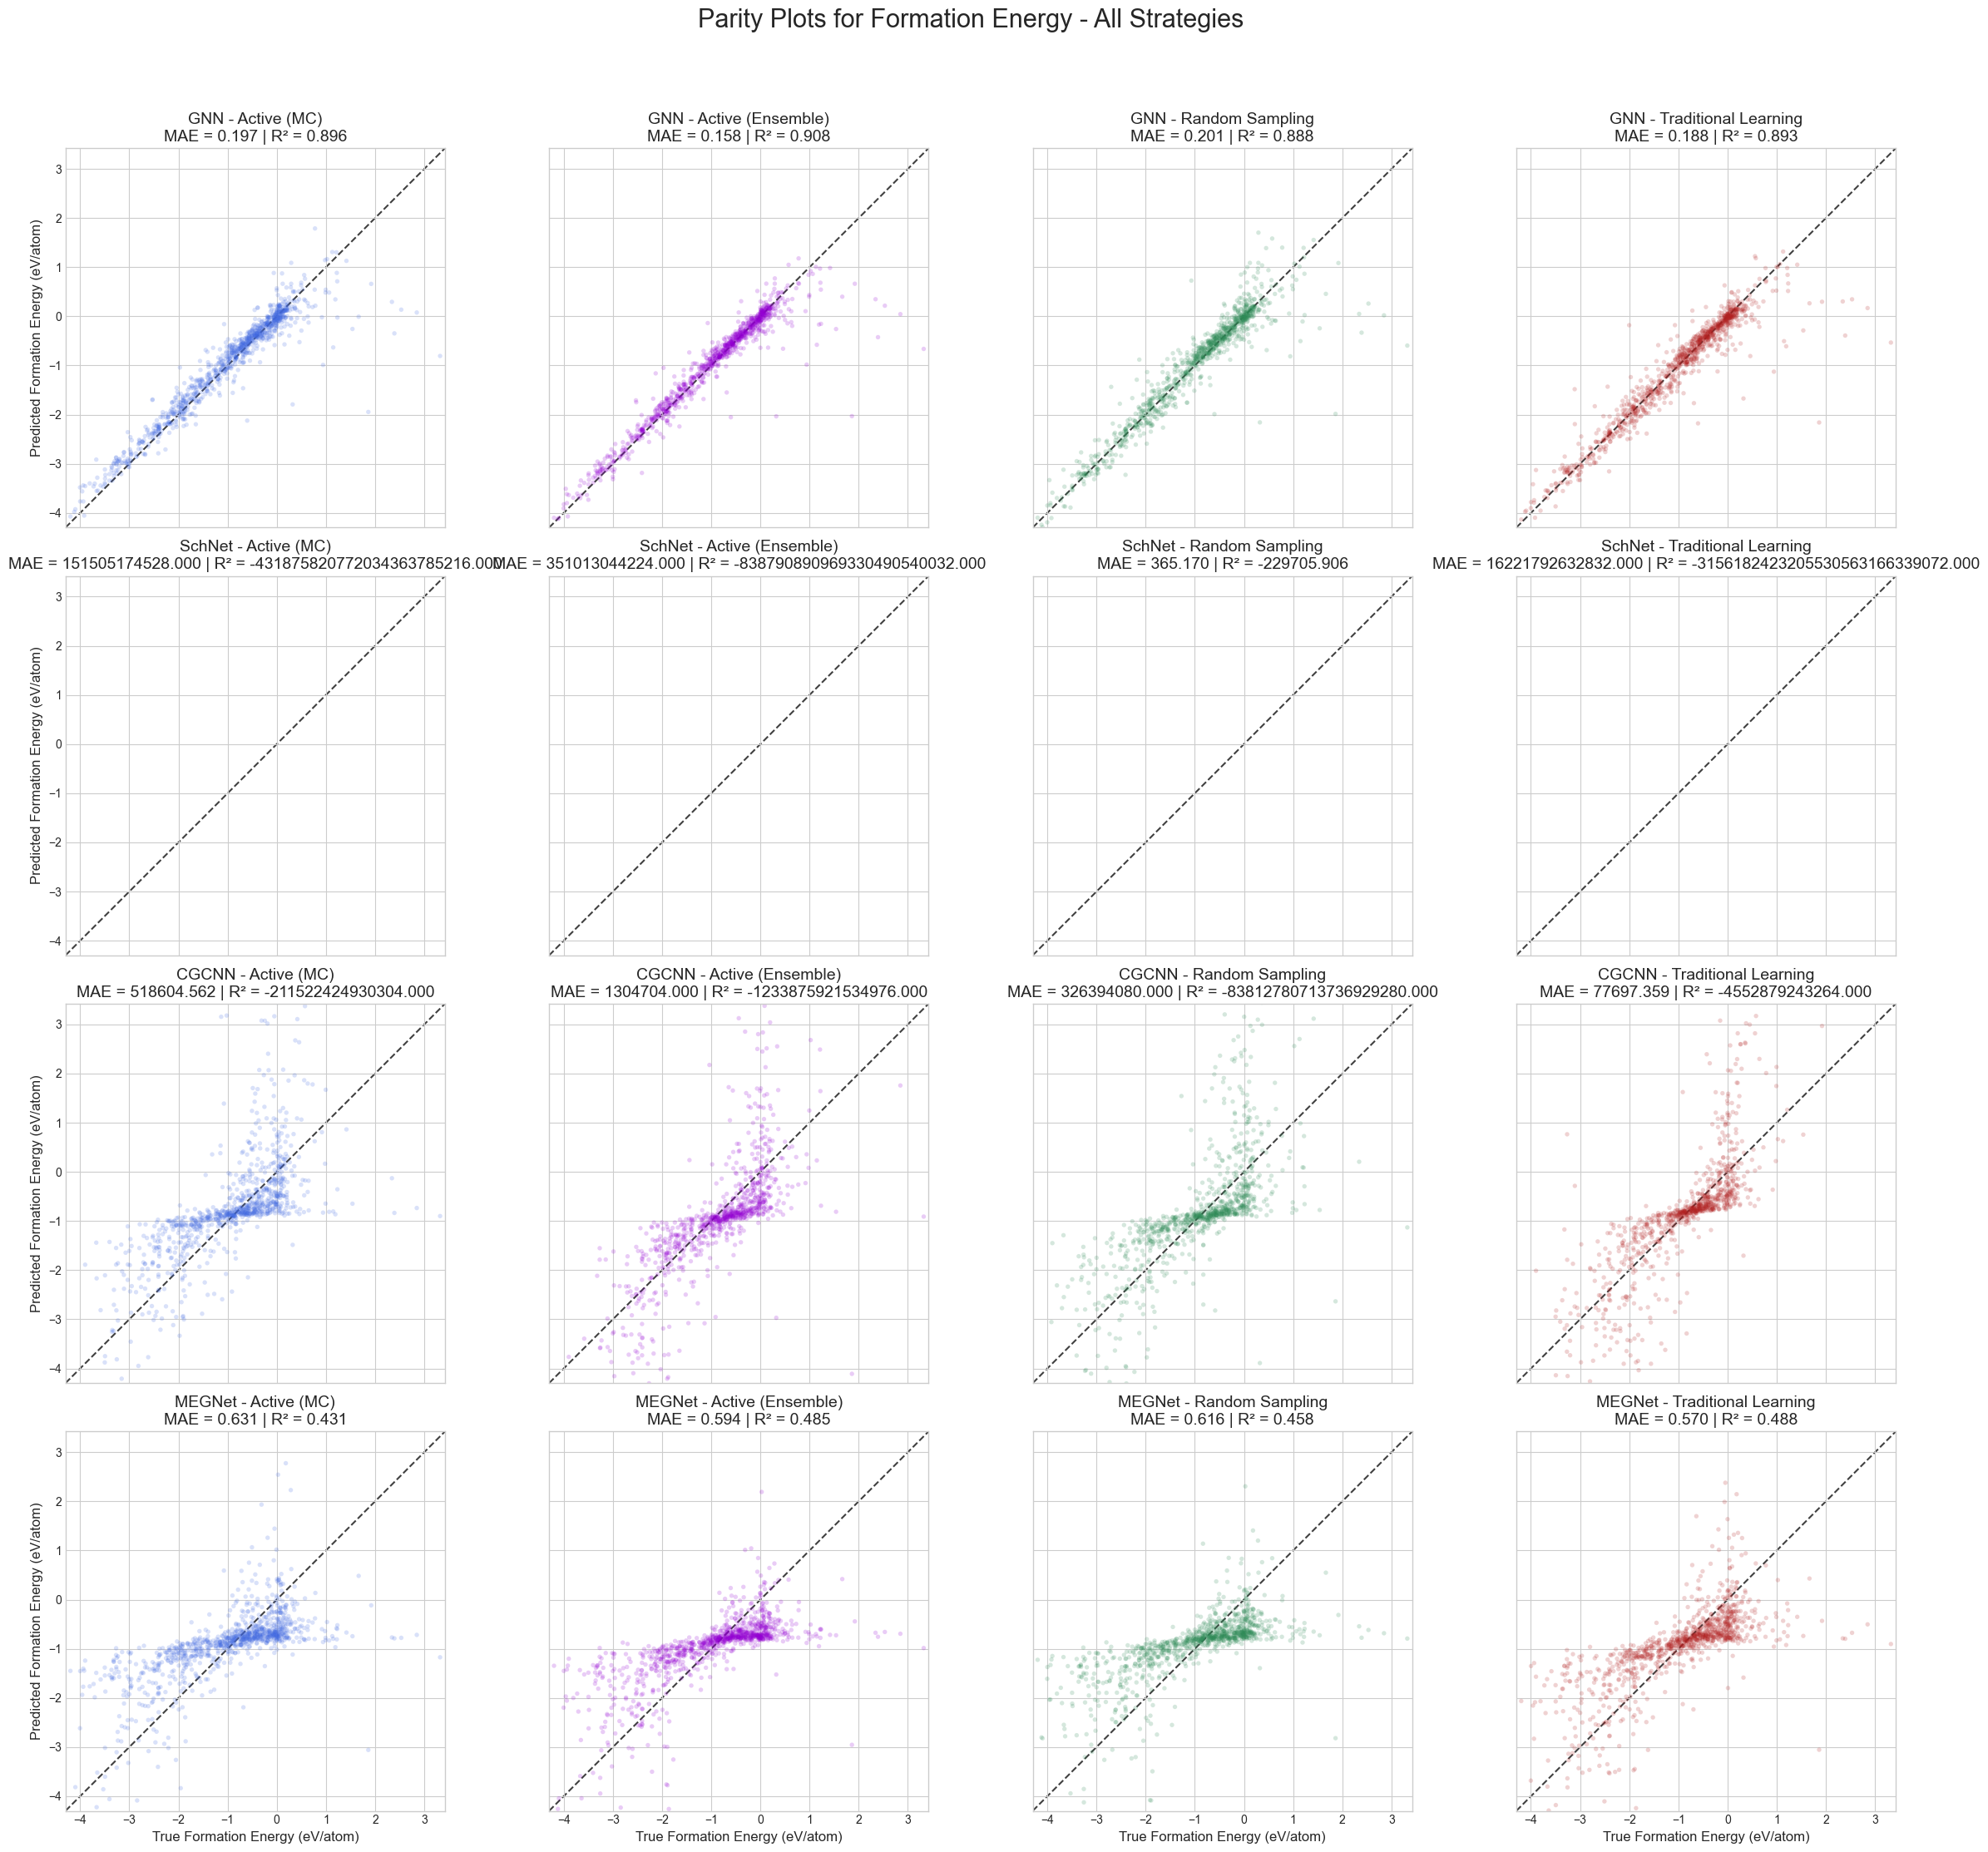


--- Generating Parity Plots for Band Gap ---
All parity plots for Band Gap saved to 'Results/parity_plots_all_models_all_strategies_band_gap.png'


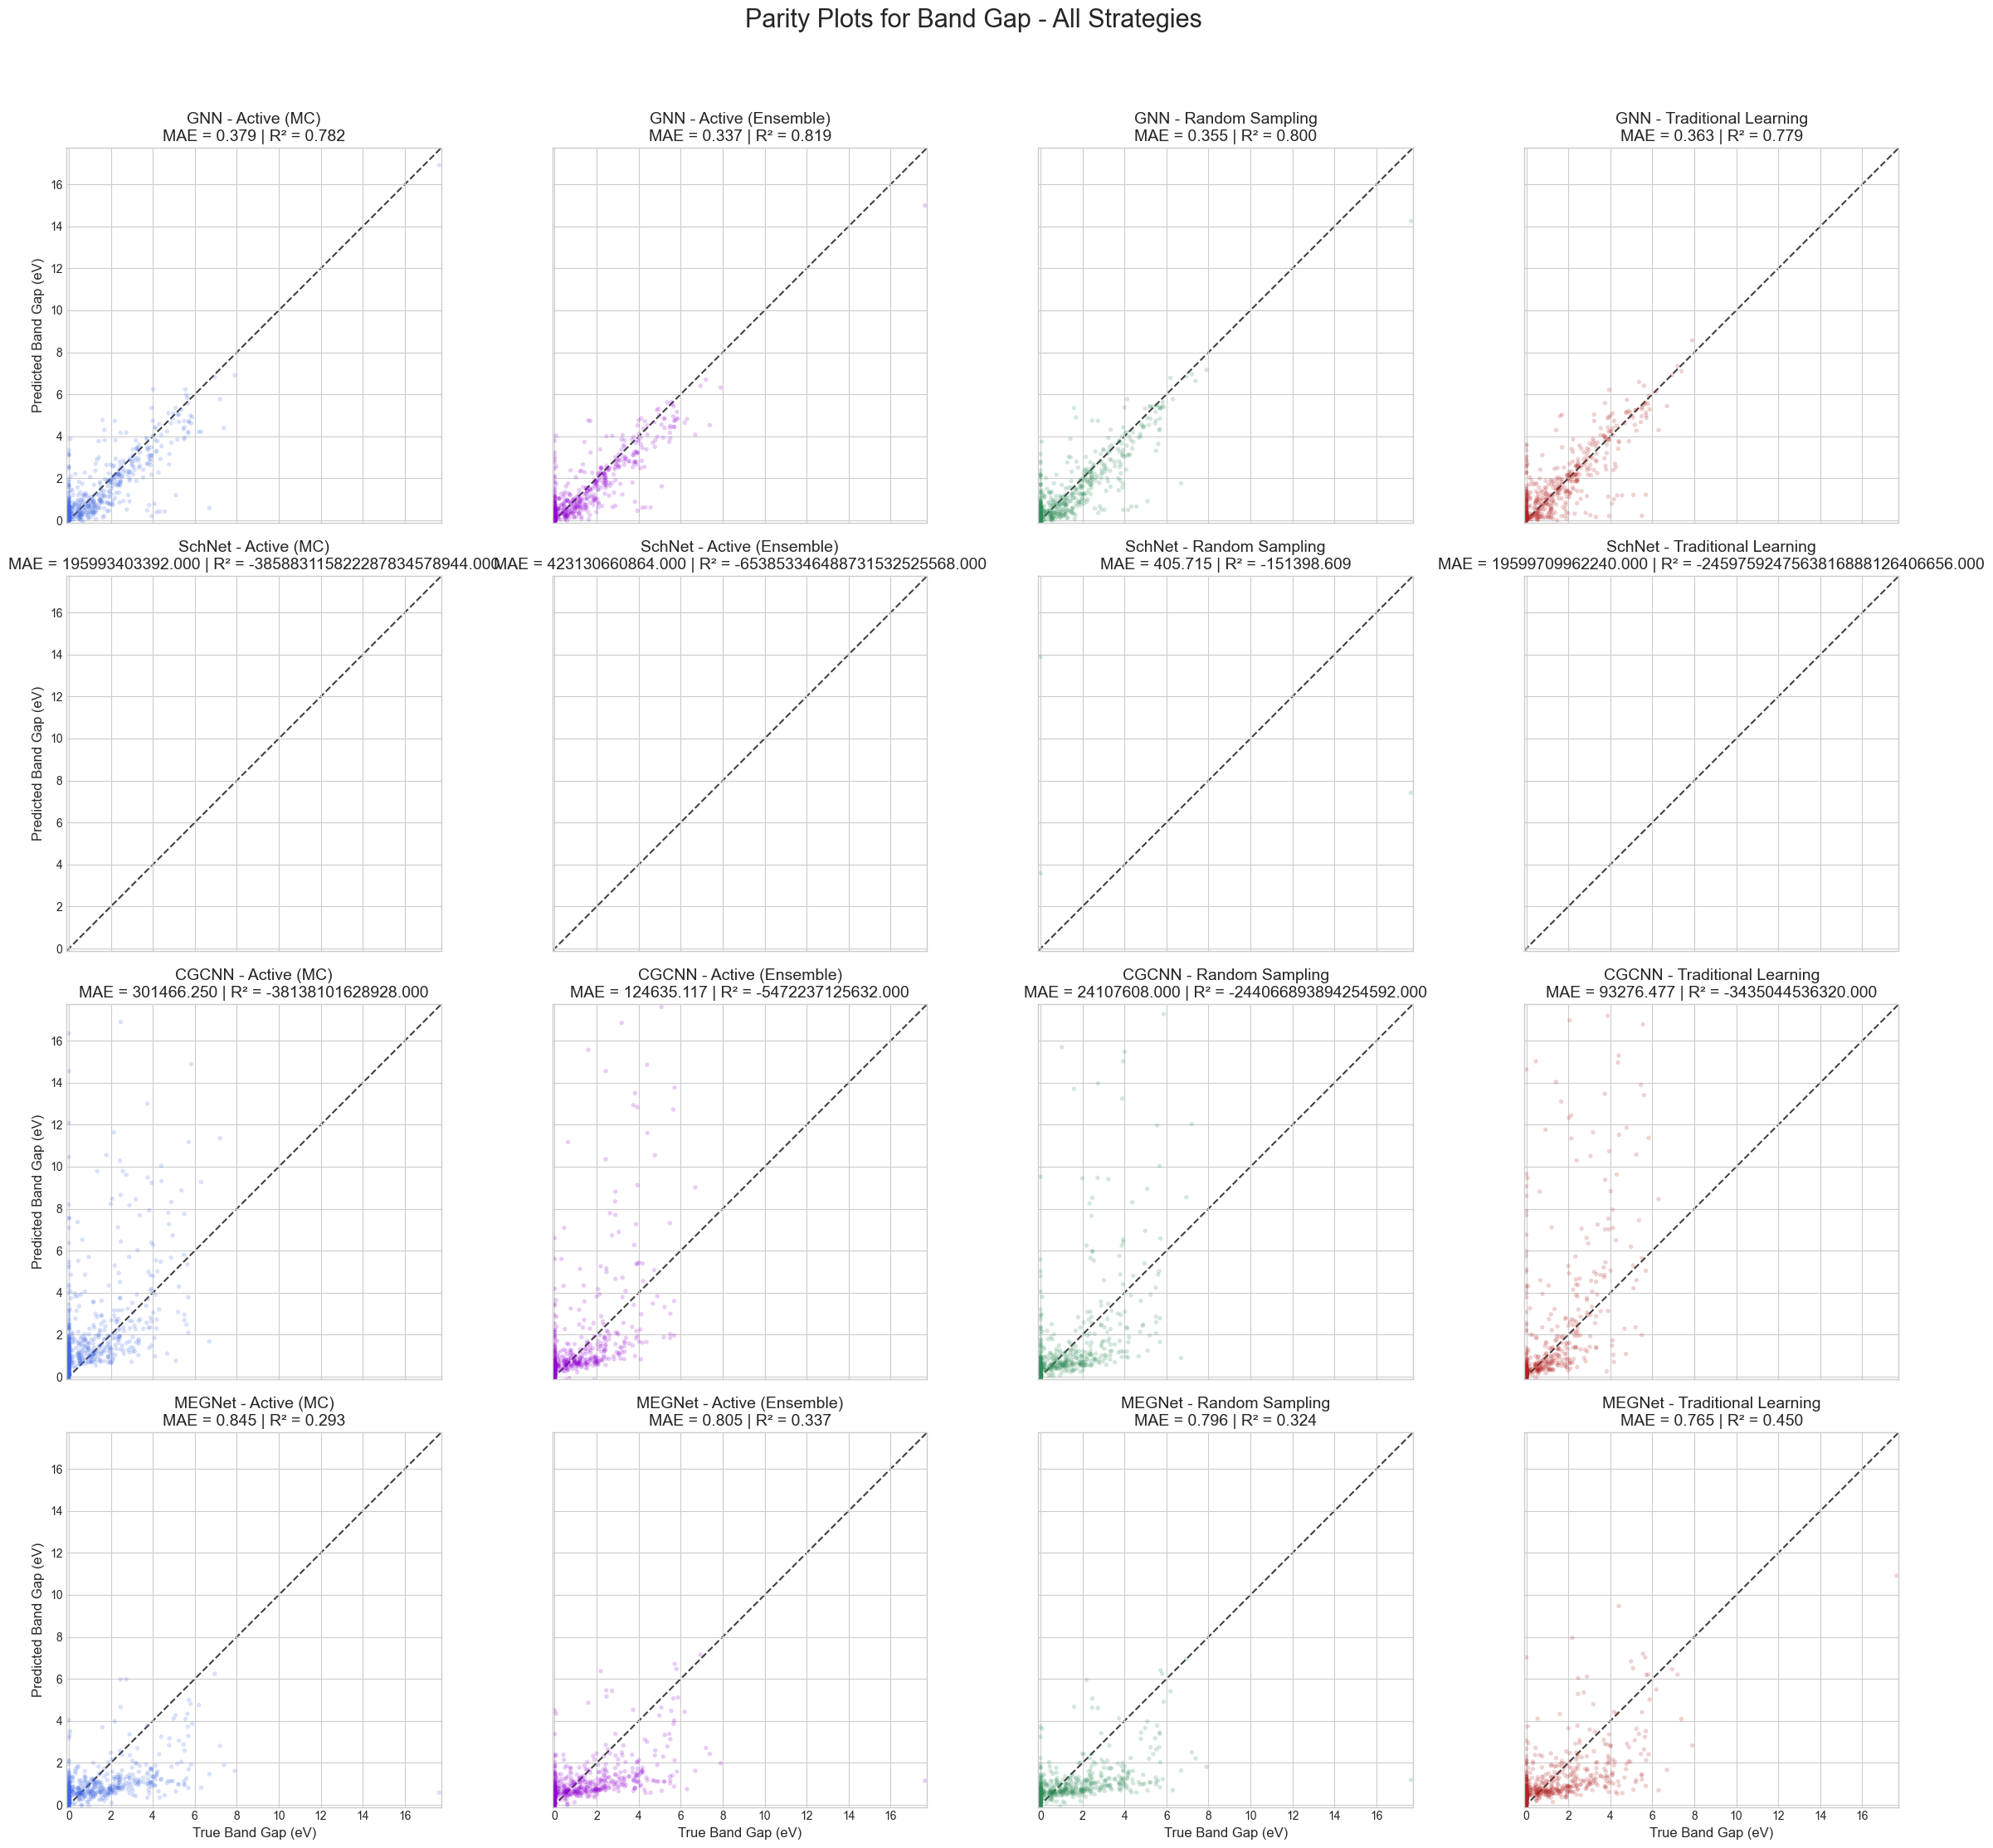

In [15]:

# --- Utility Functions ---

def get_predictions(model_name, model_path, test_loader, device):
    """Loads a SINGLE trained model and gets its predictions for the test set."""
    model = get_model(model_name, device, out_channels=2)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        raise FileNotFoundError(f"Model file not found at {model_path}")
    model.eval()
    
    all_preds, all_truths = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            all_preds.append(output.cpu().numpy())
            all_truths.append(batch.y.cpu().numpy())
    return np.concatenate(all_truths, axis=0), np.concatenate(all_preds, axis=0)

def get_ensemble_predictions(model_name, ensemble_dir, test_loader, device):
    """Loads a full ENSEMBLE of models and returns their mean predictions."""
    ensemble_models = []
    try:
        for i in range(NUM_ENSEMBLE_MEMBERS):
            model_path = os.path.join(ensemble_dir, f'member_{i}.pth')
            model = get_model(model_name, device, out_channels=2)
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            ensemble_models.append(model)
    except FileNotFoundError:
        raise FileNotFoundError(f"Ensemble model file not found in {ensemble_dir}")

    all_member_preds = []
    all_truths = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            # Get prediction from each member for the current batch
            batch_preds = [model(batch).cpu().numpy() for model in ensemble_models]
            all_member_preds.append(np.stack(batch_preds))
            all_truths.append(batch.y.cpu().numpy())
    
    # Concatenate batches: shape becomes [num_samples, num_members, 2]
    all_truths = np.concatenate(all_truths, axis=0)
    all_member_preds = np.concatenate(all_member_preds, axis=1)
    
    # Calculate the mean prediction across the ensemble members (axis=0)
    mean_preds = np.mean(all_member_preds, axis=0)
    
    return all_truths, mean_preds

def plot_all_parity_plots_for_target(target_index, target_name, unit, scaler):
    """Generates and saves a grid of parity plots for a specific target, including all strategies."""
    print(f"\n--- Generating Parity Plots for {target_name} ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_names = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
    # CHANGED: Added the new Ensemble strategy
    strategies = ['Active (MC)', 'Active (Ensemble)', 'Random Sampling', 'Traditional Learning']
    
    full_dataset = torch.load(test_graphs_path)
    all_indices = list(range(len(full_dataset)))
    random.seed(42)
    random.shuffle(all_indices)
    test_indices = all_indices[:1000]
    test_set = [full_dataset[i] for i in test_indices]
    test_loader = DataLoader(test_set, batch_size=64)

    # --- Plotting Setup ---
    plt.style.use('seaborn-v0_8-whitegrid')
    # CHANGED: Grid is now 4x4
    fig, axes = plt.subplots(len(model_names), len(strategies), figsize=(24, 22), sharex=True, sharey=True)

    # Calculate common limits for all plots
    y_true_scaled_all = np.concatenate([batch.y.cpu().numpy() for batch in test_loader], axis=0)
    y_true_unscaled_all = scaler.inverse_transform(y_true_scaled_all)[:, target_index]
    lims = [np.min(y_true_unscaled_all) - 0.1, np.max(y_true_unscaled_all) + 0.1]

    for i, model_name in enumerate(model_names):
        for j, strategy in enumerate(strategies):
            ax = axes[i, j]
            y_true_scaled, y_pred_scaled = None, None
            
            try:
                # --- UPDATED LOGIC to handle different strategies ---
                if strategy == 'Active (Ensemble)':
                    ensemble_dir = f'EnsembleActiveLearning/ensemble_{model_name}_multi_target'
                    y_true_scaled, y_pred_scaled = get_ensemble_predictions(model_name, ensemble_dir, test_loader, device)
                else:
                    folder = 'ActiveLearning' if 'Active' in strategy else \
                             'RandomSampling' if 'Random' in strategy else 'TraditionalLearning'
                    prefix = 'active' if 'Active' in strategy else \
                             'random' if 'Random' in strategy else 'traditional'
                    # For MC Dropout, use the original multi_target filename
                    model_path = f'{folder}/{prefix}_model_{model_name}_multi_target.pth'
                    y_true_scaled, y_pred_scaled = get_predictions(model_name, model_path, test_loader, device)

                # Inverse transform to get original units
                y_true_unscaled = scaler.inverse_transform(y_true_scaled)[:, target_index]
                y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)[:, target_index]
                
            except FileNotFoundError as e:
                print(f"Skipping plot for {model_name}/{strategy}: {e}")
                ax.text(0.5, 0.5, 'Model file(s)\nnot found.', ha='center', va='center', fontsize=12, transform=ax.transAxes)
                ax.set_title(f'{model_name}\n{strategy}', fontsize=14)
                continue

            mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
            r2 = r2_score(y_true_unscaled, y_pred_unscaled)

            strategy_colors = {'Active (MC)': 'royalblue', 'Active (Ensemble)': 'darkviolet', 'Random Sampling': 'seagreen', 'Traditional Learning': 'firebrick'}
            ax.scatter(y_true_unscaled, y_pred_unscaled, alpha=0.2, s=15, edgecolor='none', color=strategy_colors[strategy])
            ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
            
            ax.set_title(f'{model_name} - {strategy}\nMAE = {mae:.3f} | R² = {r2:.3f}', fontsize=14)
            ax.set_aspect('equal', 'box')
            ax.set_xlim(lims)
            ax.set_ylim(lims)

            if j == 0:
                ax.set_ylabel(f'Predicted {target_name} ({unit})', fontsize=12)
            if i == len(model_names) - 1:
                ax.set_xlabel(f'True {target_name} ({unit})', fontsize=12)

    fig.suptitle(f'Parity Plots for {target_name} - All Strategies', fontsize=22, y=1.01)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    
    output_filename = f"Results/parity_plots_all_models_all_strategies_{target_name.replace(' ', '_').lower()}.png"
    if not os.path.exists("Results"):
        os.makedirs("Results")
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"All parity plots for {target_name} saved to '{output_filename}'")
    plt.show()

if __name__ == '__main__':
    try:
        scaler = joblib.load(scaler_path)
    except FileNotFoundError:
        print(f"Error: Scaler file not found at '{scaler_path}'. Cannot un-scale predictions.")
        exit()

    # Generate plots for both targets
    plot_all_parity_plots_for_target(
        target_index=0, target_name='Formation Energy', unit='eV/atom', scaler=scaler
    )
    plot_all_parity_plots_for_target(
        target_index=1, target_name='Band Gap', unit='eV', scaler=scaler
    )

## <span style="font-family: 'Courier New'; color: #ffffffff;">Save to CSV File</span>

In [16]:

# --- Utility Functions ---

def get_predictions(model_name, model_path, test_loader, device):
    """Loads a SINGLE trained model and gets its predictions for the test set."""
    model = get_model(model_name, device, out_channels=2)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        raise FileNotFoundError(f"Model file not found at {model_path}")
    model.eval()
    
    all_preds, all_truths = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            all_preds.append(output.cpu().numpy())
            all_truths.append(batch.y.cpu().numpy())
    return np.concatenate(all_truths, axis=0), np.concatenate(all_preds, axis=0)

def get_ensemble_predictions(model_name, ensemble_dir, test_loader, device):
    """Loads a full ENSEMBLE of models and returns their mean predictions."""
    ensemble_models = []
    try:
        for i in range(NUM_ENSEMBLE_MEMBERS):
            model_path = os.path.join(ensemble_dir, f'member_{i}.pth')
            model = get_model(model_name, device, out_channels=2)
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            ensemble_models.append(model)
    except FileNotFoundError:
        raise FileNotFoundError(f"Ensemble model file not found in {ensemble_dir}")

    all_member_preds_batches = []
    all_truths_batches = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            # Get prediction from each member for the current batch and stack them
            batch_preds = torch.stack([model(batch) for model in ensemble_models])
            all_member_preds_batches.append(batch_preds.cpu().numpy())
            all_truths_batches.append(batch.y.cpu().numpy())
    
    # Concatenate all batches
    all_truths = np.concatenate(all_truths_batches, axis=0)
    # Shape: [num_members, num_samples, 2]
    all_member_preds = np.concatenate(all_member_preds_batches, axis=1)
    
    # Calculate the mean prediction across the ensemble members (axis=0)
    mean_preds = np.mean(all_member_preds, axis=0)
    
    return all_truths, mean_preds


# --- Main Metric Calculation and CSV Saving ---

def evaluate_all_models(test_graphs_path, scaler_path):
    """Evaluate all models and all strategies, compute metrics for each target, and save to CSV."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_names = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
    # CHANGED: Expanded strategies list for clarity
    strategies = ['Active (MC)', 'Active (Ensemble)', 'Random Sampling', 'Traditional Learning']

    try:
        full_dataset = torch.load(test_graphs_path)
        scaler = joblib.load(scaler_path)
    except FileNotFoundError as e:
        print(f"Error: A required file was not found. {e}")
        return

    # Create a fixed test split
    all_indices = list(range(len(full_dataset)))
    random.seed(42)
    random.shuffle(all_indices)
    test_indices = all_indices[:1000]
    test_set = [full_dataset[i] for i in test_indices]
    test_loader = DataLoader(test_set, batch_size=64)

    results = []
    for model_name in model_names:
        for strategy in strategies:
            print(f"Computing metrics for {model_name} - {strategy}...")
            y_true_scaled, y_pred_scaled = None, None
            try:
                # --- UPDATED LOGIC to handle different strategies ---
                if strategy == 'Active (Ensemble)':
                    ensemble_dir = f'EnsembleActiveLearning/ensemble_{model_name}_multi_target'
                    y_true_scaled, y_pred_scaled = get_ensemble_predictions(model_name, ensemble_dir, test_loader, device)
                else: # For MC, Random, and Traditional
                    folder = 'ActiveLearning' if 'Active' in strategy else \
                             'RandomSampling' if 'Random' in strategy else 'TraditionalLearning'
                    prefix = 'active' if 'Active' in strategy else \
                             'random' if 'Random' in strategy else 'traditional'
                    # For MC Dropout, use the original multi_target filename
                    model_path = f'{folder}/{prefix}_model_{model_name}_multi_target.pth'
                    y_true_scaled, y_pred_scaled = get_predictions(model_name, model_path, test_loader, device)

            except FileNotFoundError as e:
                print(f"Warning: Model file(s) not found for {model_name}/{strategy}. Skipping. Error: {e}")
                continue

            # Un-scale the data to get physically meaningful metrics
            y_true_unscaled = scaler.inverse_transform(y_true_scaled)
            y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

            # Compute metrics for each target
            fe_true, fe_pred = y_true_unscaled[:, 0], y_pred_unscaled[:, 0]
            fe_mae = mean_absolute_error(fe_true, fe_pred)
            fe_rmse = np.sqrt(mean_squared_error(fe_true, fe_pred))
            fe_r2 = r2_score(fe_true, fe_pred)

            bg_true, bg_pred = y_true_unscaled[:, 1], y_pred_unscaled[:, 1]
            bg_mae = mean_absolute_error(bg_true, bg_pred)
            bg_rmse = np.sqrt(mean_squared_error(bg_true, bg_pred))
            bg_r2 = r2_score(bg_true, bg_pred)

            results.append({
                'Model': model_name, 'Strategy': strategy,
                'FE_MAE': fe_mae, 'FE_RMSE': fe_rmse, 'FE_R2': fe_r2,
                'BG_MAE': bg_mae, 'BG_RMSE': bg_rmse, 'BG_R2': bg_r2
            })
            
    # Create and save the final DataFrame
    df_results = pd.DataFrame(results)
    output_dir = "Results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output_path = os.path.join(output_dir, "model_metrics_test_set_all_strategies.csv")
    df_results.to_csv(output_path, index=False)
    print(f"\nAll metrics saved to '{output_path}'")
    
    # --- Format the DataFrame for neater printing ---
    # Set a multi-level index to group by Model and then by Strategy
    df_formatted = df_results.set_index(['Model', 'Strategy'])
    # Sort the index to ensure a logical order
    # df_formatted = df_formatted.sort_index()
    print("\n--- Final Metrics Summary ---")
    display(df_formatted.round(4))


# --- Run ---
if __name__ == '__main__':  
    evaluate_all_models(test_graphs_path, scaler_path)

Computing metrics for GNN - Active (MC)...
Computing metrics for GNN - Active (Ensemble)...
Computing metrics for GNN - Random Sampling...
Computing metrics for GNN - Traditional Learning...
Computing metrics for SchNet - Active (MC)...
Computing metrics for SchNet - Active (Ensemble)...
Computing metrics for SchNet - Random Sampling...
Computing metrics for SchNet - Traditional Learning...
Computing metrics for CGCNN - Active (MC)...
Computing metrics for CGCNN - Active (Ensemble)...
Computing metrics for CGCNN - Random Sampling...
Computing metrics for CGCNN - Traditional Learning...
Computing metrics for MEGNet - Active (MC)...
Computing metrics for MEGNet - Active (Ensemble)...
Computing metrics for MEGNet - Random Sampling...
Computing metrics for MEGNet - Traditional Learning...

All metrics saved to 'Results\model_metrics_test_set_all_strategies.csv'

--- Final Metrics Summary ---


FE_MAE       FE_RMSE         FE_R2  \
Model  Strategy                                                         
GNN    Active (MC)           1.965000e-01  3.628000e-01  8.964000e-01   
       Active (Ensemble)     1.581000e-01  3.413000e-01  9.084000e-01   
       Random Sampling       2.009000e-01  3.773000e-01  8.880000e-01   
       Traditional Learning  1.876000e-01  3.682000e-01  8.933000e-01   
SchNet Active (MC)           1.515052e+11  7.409079e+11 -4.318760e+23   
       Active (Ensemble)     3.510130e+11  1.032551e+12 -8.387909e+23   
       Random Sampling       3.651701e+02  5.403458e+02 -2.297059e+05   
       Traditional Learning  1.622180e+13  6.333822e+13 -3.156183e+27   
CGCNN  Active (MC)           5.186046e+05  1.639695e+07 -2.115224e+14   
       Active (Ensemble)     1.304704e+06  3.960230e+07 -1.233876e+15   
       Random Sampling       3.263941e+08  1.032143e+10 -8.381278e+19   
       Traditional Learning  7.769735e+04  2.405624e+06 -4.552879e+12   
MEGNet Active (MC)           6.313000e-01  8.506000e-01  4.308000e-01   
       Active (Ensemble)     5.940000e-01  8.089000e-01  4.853000e-01   
       Random Sampling       6.157000e-01  8.299000e-01  4.582000e-01   
       Traditional Learning  5.703000e-01  8.070000e-01  4.876000e-01   

                                   BG_MAE       BG_RMSE         BG_R2  
Model  Strategy                                                        
GNN    Active (MC)           3.786000e-01  7.210000e-01  7.817000e-01  
       Active (Ensemble)     3.366000e-01  6.560000e-01  8.192000e-01  
       Random Sampling       3.551000e-01  6.892000e-01  8.005000e-01  
       Traditional Learning  3.628000e-01  7.247000e-01  7.794000e-01  
SchNet Active (MC)           1.959935e+11  9.584695e+11 -3.858835e+23  
       Active (Ensemble)     4.231307e+11  1.247643e+12 -6.538533e+23  
       Random Sampling       4.057150e+02  6.003611e+02 -1.513986e+05  
       Traditional Learning  1.959971e+13  7.652382e+13 -2.459761e+27  
CGCNN  Active (MC)           3.014664e+05  9.528618e+06 -3.813814e+13  
       Active (Ensemble)     1.246351e+05  3.609380e+06 -5.472237e+12  
       Random Sampling       2.410761e+07  7.622628e+08 -2.440670e+17  
       Traditional Learning  9.327652e+04  2.859674e+06 -3.435047e+12  
MEGNet Active (MC)           8.453000e-01  1.297500e+00  2.929000e-01  
       Active (Ensemble)     8.055000e-01  1.256300e+00  3.371000e-01  
       Random Sampling       7.965000e-01  1.268200e+00  3.244000e-01  
       Traditional Learning  7.650000e-01  1.144800e+00  4.495000e-01

## <span style="font-family: 'Courier New'; color: #ffffffff;">Prediction on new Data</span>


In [17]:

# --- 1. Featurization Function (must be IDENTICAL to the one used for training) ---
def structure_to_graph_for_prediction(structure: Structure, radius: float = 5.0):
    try:
        atomic_numbers = torch.tensor([site.specie.Z for site in structure], dtype=torch.long)
        pos = torch.tensor(structure.cart_coords, dtype=torch.float)
        all_neighbors = structure.get_all_neighbors(r=radius, include_index=True)
        edge_indices = [[i, neighbor[2]] for i, neighbors in enumerate(all_neighbors) for neighbor in neighbors]
        edge_attrs = [neighbor[1] for neighbors in all_neighbors for neighbor in neighbors]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices else torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.tensor(edge_attrs, dtype=torch.float).view(-1, 1) if edge_attrs else torch.empty((0, 1), dtype=torch.float)
        y = torch.tensor([[0.0, 0.0]], dtype=torch.float) # Dummy 'y'
        data = Data(x=atomic_numbers.view(-1, 1), z=atomic_numbers, pos=pos, 
                    edge_index=edge_index, edge_attr=edge_attr, y=y)
        return data
    except Exception as e:
        print(f"Error during featurization: {e}")
        return None

# --- 2. UPDATED Main Prediction Function for ALL Models ---
# def predict_with_all_models(material_id, val_graphs, scaler, api_key):
#     """
#     Predicts properties for a single material using all 16 trained models
#     and displays the results in a summary table.
#     """
#     print(f"--- Running predictions for {material_id} across all 16 models ---")
    
#     # Step A: Get True Values and Structure (ONCE)
#     found_graph = next((g for g in val_graphs if g.material_id == material_id), None)
#     if not found_graph:
#         print(f"Error: Material ID '{material_id}' not found in the validation set.")
#         return

#     true_unscaled_y = scaler.inverse_transform(found_graph.y.cpu().numpy())
#     true_fe, true_bg = true_unscaled_y[0, 0], true_unscaled_y[0, 1]

#     print("Fetching structure from Materials Project...")
#     try:
#         with MPRester(api_key) as mpr:
#             structure = mpr.get_structure_by_material_id(material_id)
#     except Exception as e:
#         print(f"Error fetching structure from MP: {e}")
#         return
        
#     prediction_graph = structure_to_graph_for_prediction(structure)
#     if prediction_graph is None: return
    
#     # Step B: Loop Through All Models and Predict
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     loader = DataLoader([prediction_graph], batch_size=1)
#     batch = next(iter(loader)).to(device)
    
#     model_names = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
#     strategies = ['Active (MC)', 'Active (Ensemble)', 'Random Sampling', 'Traditional Learning']
#     results_list = []

#     for model_name in model_names:
#         for strategy in strategies:
#             predicted_fe, predicted_bg = None, None
#             # unc_fe, unc_bg = np.nan, np.nan # Default uncertainty is Not a Number

#             try:
#                 if strategy == 'Active (Ensemble)':
#                     # --- ENSEMBLE PREDICTION LOGIC ---
#                     ensemble_dir = f'EnsembleActiveLearning/ensemble_{model_name}_multi_target'
#                     ensemble_models = []
#                     for i in range(NUM_ENSEMBLE_MEMBERS):
#                         model_path = os.path.join(ensemble_dir, f'member_{i}.pth')
#                         model = get_model(model_name, device, out_channels=2)
#                         model.load_state_dict(torch.load(model_path, map_location=device))
#                         model.eval()
#                         ensemble_models.append(model)
                    
#                     with torch.no_grad():
#                         preds_scaled = torch.stack([m(batch) for m in ensemble_models])
                    
#                     mean_pred_scaled = preds_scaled.mean(dim=0)
#                     std_dev_pred_scaled = preds_scaled.std(dim=0)
                    
#                     mean_pred_unscaled = scaler.inverse_transform(mean_pred_scaled.cpu().numpy())
#                     std_dev_unscaled = std_dev_pred_scaled.cpu().numpy() * scaler.scale_
                    
#                     predicted_fe, predicted_bg = mean_pred_unscaled[0, 0], mean_pred_unscaled[0, 1]
#                     # unc_fe, unc_bg = std_dev_unscaled[0, 0], std_dev_unscaled[0, 1]

#                 else:
#                     # --- SINGLE MODEL PREDICTION LOGIC (MC, Random, Traditional) ---
#                     folder = 'ActiveLearning' if 'Active' in strategy else \
#                              'RandomSampling' if 'Random' in strategy else 'TraditionalLearning'
#                     prefix = 'active' if 'Active' in strategy else \
#                              'random' if 'Random' in strategy else 'traditional'
#                     model_path = f'{folder}/{prefix}_model_{model_name}_multi_target.pth'
                    
#                     model = get_model(model_name, device, out_channels=2)
#                     model.load_state_dict(torch.load(model_path, map_location=device))
#                     model.eval()
                    
#                     with torch.no_grad():
#                         predicted_scaled_y = model(batch)
                    
#                     predicted_unscaled_y = scaler.inverse_transform(predicted_scaled_y.cpu().numpy())
#                     predicted_fe, predicted_bg = predicted_unscaled_y[0, 0], predicted_unscaled_y[0, 1]

#                 results_list.append({
#                     'Model': model_name, 'Strategy': strategy,
#                     'Predicted_FE': predicted_fe, 
#                     # 'Uncertainty_FE': unc_fe,
#                     'Predicted_BG': predicted_bg,
#                     #   'Uncertainty_BG': unc_bg
#                 })

#             except FileNotFoundError:
#                 print(f"Warning: Model file(s) not found for {model_name}/{strategy}. Skipping.")
#                 continue
    
#     # --- Step C: Display Results in a DataFrame ---
#     if not results_list:
#         print("No predictions were made. Check if model files exist.")
#         return
        
#     df_results = pd.DataFrame(results_list)
#     df_results['Original_FE'] = true_fe
#     df_results['Original_BG'] = true_bg
    
#     # Reorder columns for clarity and set index
#     df_results = df_results.set_index(['Model', 'Strategy'])
#     df_results = df_results[[
#         'Predicted_FE', 
#         # 'Uncertainty_FE', 
#         'Original_FE', 
#         'Predicted_BG', 
#         # 'Uncertainty_BG', 
#         'Original_BG'
#     ]]
    
#     print("\n--- PREDICTION SUMMARY ---")
#     print(f"Material ID: {material_id}")
#     display(df_results.round(4))


def predict_with_all_models(material_id, val_graphs, scaler, api_key, force_cpu=False):
    """
    Predicts properties for a single material using all models/strategies.
    Robust to CUDA device mismatch by collecting model outputs on CPU before stacking.
    Set force_cpu=True to run everything on CPU.
    """
    print(f"--- Running predictions for {material_id} across all models/strategies ---")

    # Find true values in validation graphs
    found_graph = next((g for g in val_graphs if getattr(g, 'material_id', None) == material_id), None)
    if not found_graph:
        print(f"Error: Material ID '{material_id}' not found in the validation set.")
        return

    # true_unscaled_y shape: (1,2)
    true_unscaled_y = scaler.inverse_transform(found_graph.y.cpu().numpy())
    true_fe, true_bg = true_unscaled_y[0, 0], true_unscaled_y[0, 1]

    # Fetch structure once
    print("Fetching structure from Materials Project...")
    try:
        with MPRester(api_key) as mpr:
            structure = mpr.get_structure_by_material_id(material_id)
    except Exception as e:
        print(f"Error fetching structure from MP: {e}")
        return

    prediction_graph = structure_to_graph_for_prediction(structure)
    if prediction_graph is None:
        print("Featurization failed for structure.")
        return

    device = torch.device('cpu') if force_cpu or not torch.cuda.is_available() else torch.device('cuda')
    print(f"Using device for model forward passes: {device}")

    # Put single-sample batch on device for faster inference; we'll .cpu() outputs afterwards
    loader = DataLoader([prediction_graph], batch_size=1)
    batch = next(iter(loader))
    batch_device = batch.to(device)

    model_names = ['GNN', 'SchNet', 'CGCNN', 'MEGNet']
    strategies = ['Active (MC)', 'Active (Ensemble)', 'Random Sampling', 'Traditional Learning']
    results_list = []

    for model_name in model_names:
        for strategy in strategies:
            predicted_fe = predicted_bg = None
            try:
                # Determine file/folder for this strategy
                if strategy == 'Active (Ensemble)':
                    ensemble_dir = f'EnsembleActiveLearning/ensemble_{model_name}_multi_target'
                    ensemble_models = []

                    # Load ensemble members (weights loaded to CPU, then model moved to device)
                    for i in range(NUM_ENSEMBLE_MEMBERS):
                        model_path = os.path.join(ensemble_dir, f'member_{i}.pth')
                        if not os.path.exists(model_path):
                            raise FileNotFoundError(f"Missing ensemble member: {model_path}")

                        model = get_model(model_name, device, out_channels=2)            # instantiate
                        state = torch.load(model_path, map_location='cpu')              # load safely on cpu
                        model.load_state_dict(state)                                   # load weights
                        model.to(device)                                               # move parameters/buffers
                        model.eval()
                        ensemble_models.append(model)

                    # Run each member, store outputs on CPU
                    try:
                        with torch.no_grad():
                            preds_cpu = []
                            for m in ensemble_models:
                                out = m(batch_device)           # on device
                                preds_cpu.append(out.detach().cpu())  # move to CPU
                            # preds_cpu: list of tensors [1,2] on CPU
                            preds_scaled = torch.stack(preds_cpu, dim=0)  # CPU tensor shape: [num_members, 1, 2]

                    except RuntimeError as e:
                        # Try fallback to CPU-only evaluation
                        print(f"RuntimeError during GPU ensemble forward: {e}\nRetrying ensemble inference on CPU...")
                        torch.cuda.empty_cache()
                        preds_cpu = []
                        with torch.no_grad():
                            for m in ensemble_models:
                                m_cpu = m.to('cpu')
                                m_cpu.eval()
                                out = m_cpu(batch.to('cpu'))
                                preds_cpu.append(out.detach().cpu())
                        preds_scaled = torch.stack(preds_cpu, dim=0)

                    # Compute mean/std on CPU
                    mean_pred_scaled = preds_scaled.mean(dim=0)   # shape [1,2]
                    std_dev_pred_scaled = preds_scaled.std(dim=0)

                    mean_pred_unscaled = scaler.inverse_transform(mean_pred_scaled.numpy())
                    # If scaler.scale_ exists, std_dev_pred_scaled.numpy() * scaler.scale_
                    try:
                        std_dev_unscaled = std_dev_pred_scaled.numpy() * scaler.scale_
                    except Exception:
                        std_dev_unscaled = std_dev_pred_scaled.numpy()

                    predicted_fe, predicted_bg = float(mean_pred_unscaled[0, 0]), float(mean_pred_unscaled[0, 1])

                else:
                    folder = 'ActiveLearning' if 'Active' in strategy else \
                             'RandomSampling' if 'Random' in strategy else 'TraditionalLearning'
                    prefix = 'active' if 'Active' in strategy else \
                             'random' if 'Random' in strategy else 'traditional'
                    model_path = f'{folder}/{prefix}_model_{model_name}_multi_target.pth'

                    if not os.path.exists(model_path):
                        raise FileNotFoundError(f"Missing model file: {model_path}")

                    # Instantiate and load model properly
                    model = get_model(model_name, device, out_channels=2)
                    state = torch.load(model_path, map_location='cpu')
                    model.load_state_dict(state)
                    model.to(device)
                    model.eval()

                    # Forward pass and move result to CPU
                    try:
                        with torch.no_grad():
                            predicted_scaled_y = model(batch_device)  # on device
                            predicted_scaled_y_cpu = predicted_scaled_y.detach().cpu()
                    except RuntimeError as e:
                        # fallback to CPU
                        print(f"RuntimeError during GPU forward for {model_name}/{strategy}: {e}\nRetrying on CPU...")
                        torch.cuda.empty_cache()
                        model_cpu = model.to('cpu')
                        model_cpu.eval()
                        with torch.no_grad():
                            predicted_scaled_y_cpu = model_cpu(batch.to('cpu')).detach().cpu()

                    predicted_unscaled_y = scaler.inverse_transform(predicted_scaled_y_cpu.numpy())
                    predicted_fe, predicted_bg = float(predicted_unscaled_y[0, 0]), float(predicted_unscaled_y[0, 1])

                results_list.append({
                    'Model': model_name,
                    'Strategy': strategy,
                    'Predicted_FE': predicted_fe,
                    'Predicted_BG': predicted_bg,
                })

            except FileNotFoundError as e:
                print(f"Warning: {e}. Skipping this model/strategy.")
                continue
            except Exception as e:
                print(f"Unexpected error for {model_name}/{strategy}: {e}")
                continue

    # Display results
    if not results_list:
        print("No predictions were made. Check that model files exist and paths are correct.")
        return

    df_results = pd.DataFrame(results_list)
    df_results['Original_FE'] = true_fe
    df_results['Original_BG'] = true_bg
    df_results = df_results.set_index(['Model', 'Strategy'])
    df_results = df_results[['Predicted_FE', 'Original_FE', 'Predicted_BG', 'Original_BG']]

    print("\n--- PREDICTION SUMMARY ---")
    print(f"Material ID: {material_id}")
    display(df_results.round(4))
    return df_results



# --- 3. Example Usage ---
# Load the necessary files ONCE at the top of the cell
try:
    scaler = joblib.load(cleaned_scaler_path)
    val_graphs = torch.load(val_graphs_path)
    print("✅ Scaler and validation graphs loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    scaler, val_graphs = None, None

if scaler and val_graphs and API_KEY != "YOUR_API_KEY_HERE":
    # Pick a material_id from your validation set to test
    material_to_predict = val_graphs[50].material_id # Using the 51st material as an example
    
    # Call the new function to get a full report from all 16 models
    predict_with_all_models(
        material_id=material_to_predict,
        val_graphs=val_graphs,
        scaler=scaler,
        api_key=API_KEY
    )
else:
    if not scaler or not val_graphs:
        print("\nCould not run prediction because scaler/validation graphs failed to load.")
    if API_KEY == "YOUR_API_KEY_HERE":
        print("\nCould not run prediction. Please enter your Materials Project API Key.")

✅ Scaler and validation graphs loaded successfully.
--- Running predictions for mp-2767524 across all models/strategies ---
Fetching structure from Materials Project...


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Using device for model forward passes: cuda

--- PREDICTION SUMMARY ---
Material ID: mp-2767524


Predicted_FE  Original_FE  Predicted_BG  \
Model  Strategy                                                        
GNN    Active (MC)          -2.002500e+00      -1.8809  7.855000e-01   
       Active (Ensemble)    -2.003700e+00      -1.8809  1.566700e+00   
       Random Sampling      -1.950500e+00      -1.8809  6.434000e-01   
       Traditional Learning -2.409600e+00      -1.8809  2.324200e+00   
SchNet Active (MC)           1.772643e+11      -1.8809 -2.293166e+11   
       Active (Ensemble)     7.194258e+11      -1.8809 -8.683513e+11   
       Random Sampling      -5.430303e+02      -1.8809  6.030624e+02   
       Traditional Learning -5.236823e+13      -1.8809  6.326915e+13   
CGCNN  Active (MC)          -3.767500e+00      -1.8809  3.406000e+00   
       Active (Ensemble)    -2.299000e+00      -1.8809  3.765000e-01   
       Random Sampling      -2.558600e+00      -1.8809  8.940000e-01   
       Traditional Learning -1.934800e+00      -1.8809  1.348200e+00   
MEGNet Active (MC)          -1.169100e+00      -1.8809  4.464000e-01   
       Active (Ensemble)    -1.261700e+00      -1.8809  3.347000e-01   
       Random Sampling      -1.217500e+00      -1.8809  3.167000e-01   
       Traditional Learning -1.462300e+00      -1.8809  3.466000e-01   

                             Original_BG  
Model  Strategy                           
GNN    Active (MC)                0.8233  
       Active (Ensemble)          0.8233  
       Random Sampling            0.8233  
       Traditional Learning       0.8233  
SchNet Active (MC)                0.8233  
       Active (Ensemble)          0.8233  
       Random Sampling            0.8233  
       Traditional Learning       0.8233  
CGCNN  Active (MC)                0.8233  
       Active (Ensemble)          0.8233  
       Random Sampling            0.8233  
       Traditional Learning       0.8233  
MEGNet Active (MC)                0.8233  
       Active (Ensemble)          0.8233  
       Random Sampling            0.8233  
       Traditional Learning       0.8233